In [1]:
!pip install transformers datasets tokenizers
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -qq cornell_movie_dialogs_corpus.zip
!rm cornell_movie_dialogs_corpus.zip
!mkdir datasets
!mv cornell\ movie-dialogs\ corpus/movie_conversations.txt ./datasets
!mv cornell\ movie-dialogs\ corpus/movie_lines.txt ./datasets

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 9.5 MB/s eta 0:00:00:00:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 435.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.7 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 417.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 248.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 675.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 412.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam

/home/ubuntu/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1 ) Tokenization (Word Piece Tokenizer)

To begin our implementation of BERT, we first import the necessary libraries and preprocess the dataset by storing it into memory.

- The data corpus is divided into two files, ‘movie_conversations.txt’ and ‘movie_lines.txt’.
- We then split the text in ‘movie_lines.txt’ using a special delimiter (‘+++ $ +++’) to separate the line’s ID, character ID, movie ID, and dialogue text, and store them in a dictionary called line_dic.
- Next, we generate question-answer pairs by iterating over each conversation in ‘movie_conversations.txt’ and pairing the current line’s text with the next line’s text for each conversation.
- Finally, we limit the maximum length of the input sequence to 64 tokens, which is a common length used in many NLP tasks, by splitting the text and taking only the first 64 tokens.

In [3]:
### data processing
MAX_LEN = 64

### loading all data into memory
corpus_movie_conv = './datasets/movie_conversations.txt'
corpus_movie_lines = './datasets/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

### splitting text using special lines
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

### generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []
        
        if i == len(ids) - 1:
            break

        first = lines_dic[ids[i]].strip()  
        second = lines_dic[ids[i+1]].strip() 

        qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
        qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
        pairs.append(qa_pairs)

# sample
print(pairs[20])

["I really, really, really wanna go, but I can't. Not unless my sister goes.", "I'm workin' on it. But she doesn't seem to be goin' for him."]


WordPiece Tokenization
The initial stage of creating a fresh BERT model involves training a new tokenizer. Tokenization is the process of breaking down a text into smaller units called “tokens,” which are then converted into a numerical representation. An example of this would be splitting the sentence

 “I like surfboarding!” → [‘[CLS]’, ‘i’, ‘like’, ‘surf’, ‘##board’, ‘##ing’, ‘!’, ‘[SEP]’] → [1, 48, 250, 4033, 3588, 154, 5, 2]
A tokenized BERT input always starts with a special [CLS] token and ends with a special [SEP] token, which are used for specific purposes that will be explained later. BERT employs a WordPiece tokenizer, which can split a single word into multiple tokens. For instance, in the example given earlier, the word “surfboarding” is broken down into ['surf', '##boarding', '##ing']. This technique helps the model to understand that words like surfboardand snowboardhave shared meaning through the common wordpiece ##board. By referring to the explanation from HuggingFace, WordPiece computes a score for each pair, using the following

score = (freq_of_pair) / (freq_of_first_element × freq_of_second_element)

By dividing the frequency of the pair by the product of the frequencies of each of its parts, the algorithm prioritizes the merging of pairs where the individual parts are less frequent in the vocabulary. For instance, it won’t necessarily merge ("un", "##able") even if that pair occurs very frequently in the vocabulary, because the two pairs "un" and "##able" will likely each appear in a lot of other words and have a high frequency. In contrast, a pair like ("hu", "##gging") will probably be merged faster (assuming the word “hugging” appears often in the vocabulary) since "hu" and "##gging" are likely to be less frequent individually.

To train the tokenizer, the BertWordPieceTokenizer from the transformer library was used with the steps below:

- Saving the conversation text into multiple .txt files (with batch of N=10000)
- Define BertWordPieceTokenizer with some parameters likeclean_text to remove control characters, handle_chinese_chars to include spaces around Chinese characters, stripe_accents to remove accents and make é → e, ô → o, andlowercase to view capital and lowercase characters as equal.
- Train the tokenizer based on the file path to .txt files with parameters like vocab_size defines the total number of tokens, min_frequency for minimum frequency for a pair of tokens to be merged, special_tokens defines a list of the special tokens that BERT uses, limit_alphabet for a maximum number of different characters, workpieces_prefix the prefix added to pieces of words (like ##ing).

In [4]:
# WordPiece tokenizer

### save data as txt file
os.mkdir('./data')
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]
print(len(paths))

100%|██████████| 221616/221616 [00:00<00:00, 1797117.49it/s]

22


To specifically highlight these special tokens for BERT:

- CLS stands for classification. It serves as the the Start of Sentence (SOS) and represent the meaning of the entire sentence.
- SEP serves as End of Sentence (EOS) and also the separation token between first and second sentences.
- PADto be added into sentences so that all of them would be in equal length. During the training process, please note that the [PAD] token with id of 0 will not contribute to the gradient .
- MASK for word replacement during masked language prediction
- UNK serves as a replacement for token if it’s not being found in the tokenizer’s vocab.


In [5]:
### training own tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train( 
    files=paths,
    vocab_size=30_000, 
    min_frequency=5,
    limit_alphabet=1000, 
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1', 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)
token_ids = tokenizer('I like surfboarding!')['input_ids']
print(token_ids)
print(tokenizer.convert_ids_to_tokens(token_ids))




[1, 48, 250, 4033, 3588, 154, 5, 2]
['[CLS]', 'i', 'like', 'surf', '##board', '##ing', '!', '[SEP]']


/home/ubuntu/miniconda3/envs/torch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


# 2) Pre-processing

The code below defines a custom PyTorch Dataset class named BERTDataset, which is intended to be used for training a Bidirectional Encoder Representations from Transformers (BERT) model. The random_word method of the BERTDataset class performs the random replacement of tokens in each sentence using the given tokenizer object. The get_sent method returns a random sentence pair and corresponding is_next label. Finally, the get_corpus_line and get_random_line methods are used to retrieve individual sentences from the input pairs for negative sentence pairs.
It took multiple steps to prepare the data for the two training strategies

- Step 1:
Select a random sentence pair, either positive or negative, and save the is_next indicating whether the two sentences are consecutive in the original text or not.
- Step 2:
Masking random words in first and second sentences based on predefined probabilities, at the same time recording the actual word as bert_label. After which, it converts the sequence string into integer (list of token ids).
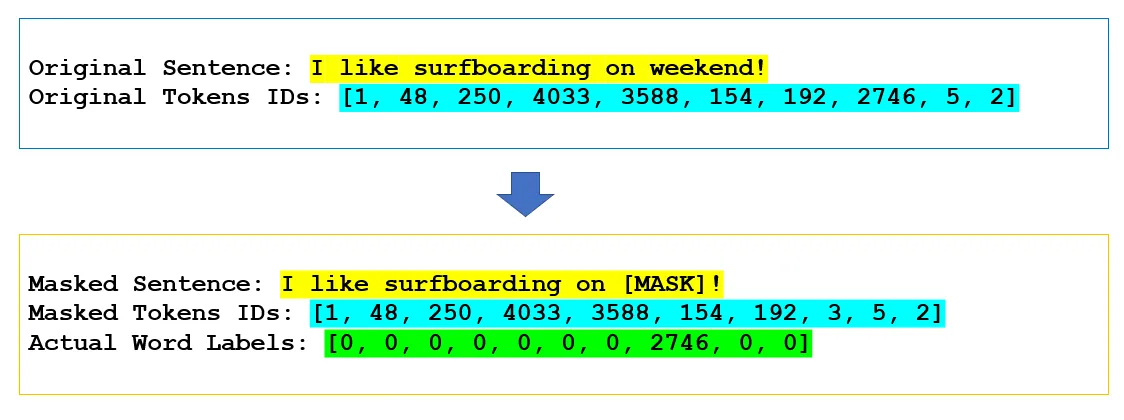
- Step 3:
Add special [CLS] and [SEP] tokens to the start and end of each sentence.
- Step 4:
Combine first and second sentences as single output (but separated by SEPtoken) and then followed by padding with PAD token to the sentence pairs and labels to max length. At this step, a segment label is created by assigning 1 for first sentence and 2 for second, whereas 0 for padded tokens.

By printing a sample output from the prepared dataset, we will see 4 keys output

- bert_input for tokenized sentences
- bert_label stores original words of selected masking tokens
- segment_label as the identifier for sentence A or B, this allows the model to distinguish between sentences
- is_next as truth label for whether the two sentences are related

In [6]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

In [7]:
# test
print("\n")
train_data = BERTDataset(pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
sample_data = next(iter(train_loader))
print('Batch Size', sample_data['bert_input'].size())

result = train_data[random.randrange(len(train_data))]
result



Batch Size torch.Size([32, 64])


{'bert_input': tensor([   1,  558,    3,    3,    2, 4039,   17, 6013,  162,   17,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'bert_label': tensor([  0,   0, 839,  17,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0]),
 'segment_label': tensor([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# 3) Modeling

In NLP model, the order of the words and their position in a sentence matters and the meaning of the entire sentence can change if the words are re-ordered. As such, transformer model did a position embedding for each token in the input using the formula

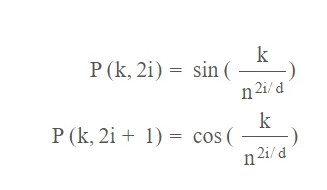!

where

- k: Position of an object in input sequence, 0 < k < L/2
- d: Dimension of the output embedding space
- n: User defined scalar. Default by 10,000
- i: Used for mapping to column indices 0 < i < d/2. A single value of i maps to both sine and cosine functions
For all three different type of embeddings, they must be in the similar output size (768 in this case), so that all three of them can be summed together to be a single embedded output. You may notice thepadding_idx is specified as 0, this is to make pad token remains as 0 and not being updated during training.

In [8]:
### embedding
class PositionalEmbedding(torch.nn.Module):

    def __init__(self, d_model, max_len=128):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        for pos in range(max_len):   
            # for each dimension of the each position
            for i in range(0, d_model, 2):   
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)   
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

class BERTEmbedding(torch.nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, seq_len=64, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """

        super().__init__()
        self.embed_size = embed_size
        # (m, seq_len) --> (m, seq_len, embed_size)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)
       
    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

### testing
embed_layer = BERTEmbedding(vocab_size=len(tokenizer.vocab), embed_size=768, seq_len=MAX_LEN)
embed_result = embed_layer(sample_data['bert_input'], sample_data['segment_label'])
print(embed_result.size())

torch.Size([32, 64, 768])


### The details of the class MultiHeadedAttention ###

- It’s called multi-head attention because the hidden size: d_model(768) is split by heads(12), this allows the model to jointly attend to information at different positions from different representational spaces.
- It takes the query, key, and value as inputs, and the size is permuted from (batch_size, max_len, hidden_size) → (batch_size, num_heads, max_len, hidden_size / num_heads ). This indicates that all the 3 inpurs are linearly projected from the d_model dimensional space to heads sets of d_k dimensional vectors.
- Attention score matrix is computed using matrix multiplication between the query(Q) and key(K) tensors, followed by scaling by the square root of the key tensor’s dimension
- The mask is applied to the attention matrix and filled with -1e9 (close to negative infinity). This is done because the large negative inputs to softmax are near zero in the output.
- The final output is a weighted sum of the value(V) tensors, where the weights are determined by the softmax of the scaled dot-product between the query and key vectors.
The EncoderLayer class contains 2 sublayers:.

- MultiHeadedAttention: A multi-headed self-attention module that computes the attention weights between each element in the input sequence
- FeedForward: A feedforward network with one hidden layer that applies a non-linear activation function (GELU) to the output of the first linear layer and produces a d_model dimensional output.
- Each of these sublayers has a residual connection around it followed by a layer normalization LayerNorm(x + Sublayer(x)). Residual connections help in avoiding the vanishing gradient problem in deep networks.

In [9]:
### attention layers
class MultiHeadedAttention(torch.nn.Module):
    
    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)    

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)           
        weights = self.dropout(weights)

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)

class FeedForward(torch.nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()
        
        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class EncoderLayer(torch.nn.Module):
    def __init__(
        self, 
        d_model=768,
        heads=12, 
        feed_forward_hidden=768 * 4, 
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

### testing
mask = (sample_data['bert_input'] > 0).unsqueeze(1).repeat(1, sample_data['bert_input'].size(1), 1).unsqueeze(1)
transformer_block = EncoderLayer()
transformer_result = transformer_block(embed_result, mask)
transformer_result.size()

torch.Size([32, 64, 768])

### The details of the class MultiHeadedAttention ###

- It’s called multi-head attention because the hidden size: **d_model(768) is split by heads(12)**, this allows the model to jointly attend to information at different positions from different representational spaces.
- It takes the query, key, and value as inputs, and the size is permuted from **(batch_size, max_len, hidden_size) → (batch_size, num_heads, max_len, hidden_size / num_heads )**. This indicates that all the 3 inpurs are linearly projected from the d_model dimensional space to heads sets of d_k dimensional vectors.
- Attention score matrix is computed using matrix multiplication between the query(Q) and key(K) tensors, followed by scaling by the square root of the key tensor’s dimension
- **The mask is applied to the attention matrix and filled with -1e9 (close to negative infinity)**. This is done because the large negative inputs to softmax are near zero in the output.   
        ** per my understanding this means the mask for padding?? correct? not [mask] token... ..  "" def forward(self, query, key, value, mask): ""**
- The final output is a weighted sum of the value(V) tensors, where the weights are determined by the softmax of the scaled dot-product between the query and key vectors.

The EncoderLayer class contains 2 sublayers:.

- MultiHeadedAttention: A multi-headed self-attention module that computes the attention weights between each element in the input sequence
- FeedForward: A feedforward network with one hidden layer that applies a non-linear activation function (GELU) to the output of the first linear layer and produces a d_model dimensional output.
Each of these sublayers has a residual connection around it followed by a layer normalization LayerNorm(x + Sublayer(x)). Residual connections help in avoiding the vanishing gradient problem in deep networks.

### Final BERT Model ###
Coming next, we are going to incorporate the encoder layer with attention mechanism into the final BERT’s construction.
- The BERT class initializes the embedding layer for the input sequence, as well as multi layers of EncoderLayer blocks. The forward method of this class takes in the input sequence and a segment info tensor, applies attention masking to the input(for padded token), embeds the input sequence, and then passes it through the encoder blocks to obtain the output.
- The NextSentencePrediction class is a 2-class classification model that takes in the output of the BERT class and predicts whether the input sequence contains two consecutive sentences or not. The forward method applies applies linear transformation and log softmax function to obtain the predicted probabilities of the two classes.
- The MaskedLanguageModel class is a multi-class classification model that takes in the output of the BERT class and predicts the original tokens for the masked input sequence. The forward method applies a linear transformation and log softmax function to obtain the predicted probabilities of each token in the vocabulary.
- The BERTLM class combines the BERT, NextSentencePrediction, and MaskedLanguageModel classes to create a complete BERT language model.

In [10]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # paper noted they used 4*hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)

### test
bert_model = BERT(len(tokenizer.vocab))
bert_result = bert_model(sample_data['bert_input'], sample_data['segment_label'])
print(bert_result.size())

bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
final_result = bert_lm(sample_data['bert_input'], sample_data['segment_label'])
print(final_result[0].size(), final_result[1].size())

torch.Size([32, 64, 768])
torch.Size([32, 2]) torch.Size([32, 64, 21159])


# 4) Training

### Optimizer ###
The original BERT model was trained using Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).
$$
l r a t e=d_{\text {model }}^{-0.5} * \min \left(step\_num^{-0.5}, step\_num * warmup_steps^{-1.5}\right)
$$


In [11]:
### optimizer
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

Trainer
We came a long way to finally combine what we have discussed above and start training a new BERT model

In [12]:
### trainer
class BERTTrainer:
    def __init__(
        self, 
        model, 
        train_dataloader, 
        test_dataloader=None, 
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
    
    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        
        avg_loss = 0.0
        total_correct = 0
        total_element = 0
        
        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        ) 

### test
train_data = BERTDataset(pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
bert_model = BERT(len(tokenizer.vocab))
bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')   
epochs = 2

for epoch in range(epochs):
    bert_trainer.train(epoch)

Total Parameters: 117561257


EP_train:0:   0%|| 1/6926 [00:04<9:01:10,  4.69s/it]

{'epoch': 0, 'iter': 0, 'avg_loss': 10.89798355102539, 'avg_acc': 53.125, 'loss': 10.89798355102539}


EP_train:0:   0%|| 11/6926 [00:39<6:37:53,  3.45s/it]

{'epoch': 0, 'iter': 10, 'avg_loss': 10.867982777682217, 'avg_acc': 50.0, 'loss': 10.717849731445312}


EP_train:0:   0%|| 21/6926 [01:14<6:35:39,  3.44s/it]

{'epoch': 0, 'iter': 20, 'avg_loss': 10.625354085649763, 'avg_acc': 50.0, 'loss': 10.077768325805664}


EP_train:0:   0%|| 31/6926 [01:48<6:36:18,  3.45s/it]

{'epoch': 0, 'iter': 30, 'avg_loss': 10.422906321863975, 'avg_acc': 49.29435483870967, 'loss': 9.897195816040039}


EP_train:0:   1%|| 41/6926 [02:23<6:41:40,  3.50s/it]

{'epoch': 0, 'iter': 40, 'avg_loss': 10.273156724325041, 'avg_acc': 49.84756097560975, 'loss': 9.698206901550293}


EP_train:0:   1%|| 51/6926 [02:57<6:33:31,  3.43s/it]

{'epoch': 0, 'iter': 50, 'avg_loss': 10.160286865982355, 'avg_acc': 49.754901960784316, 'loss': 9.699801445007324}


EP_train:0:   1%|| 61/6926 [03:32<6:38:19,  3.48s/it]

{'epoch': 0, 'iter': 60, 'avg_loss': 10.034004461569864, 'avg_acc': 50.25614754098361, 'loss': 9.232473373413086}


EP_train:0:   1%|| 71/6926 [04:06<6:35:02,  3.46s/it]

{'epoch': 0, 'iter': 70, 'avg_loss': 9.914001276795293, 'avg_acc': 50.26408450704225, 'loss': 9.27730941772461}


EP_train:0:   1%|| 81/6926 [04:41<6:33:04,  3.45s/it]

{'epoch': 0, 'iter': 80, 'avg_loss': 9.792469695762351, 'avg_acc': 50.1929012345679, 'loss': 8.917365074157715}


EP_train:0:   1%|| 91/6926 [05:15<6:28:32,  3.41s/it]

{'epoch': 0, 'iter': 90, 'avg_loss': 9.684995368286804, 'avg_acc': 50.24038461538461, 'loss': 8.476027488708496}


EP_train:0:   1%|| 101/6926 [05:50<6:35:22,  3.48s/it]

{'epoch': 0, 'iter': 100, 'avg_loss': 9.58456044149871, 'avg_acc': 49.93811881188119, 'loss': 8.499567985534668}


EP_train:0:   2%|| 111/6926 [06:24<6:31:06,  3.44s/it]

{'epoch': 0, 'iter': 110, 'avg_loss': 9.4917702288241, 'avg_acc': 49.74662162162162, 'loss': 8.589751243591309}


EP_train:0:   2%|| 121/6926 [06:59<6:29:42,  3.44s/it]

{'epoch': 0, 'iter': 120, 'avg_loss': 9.402804642669425, 'avg_acc': 49.43181818181818, 'loss': 8.433043479919434}


EP_train:0:   2%|| 131/6926 [07:33<6:29:06,  3.44s/it]

{'epoch': 0, 'iter': 130, 'avg_loss': 9.320094690978072, 'avg_acc': 49.666030534351144, 'loss': 8.0137300491333}


EP_train:0:   2%|| 141/6926 [08:08<6:28:28,  3.44s/it]

{'epoch': 0, 'iter': 140, 'avg_loss': 9.249869021963566, 'avg_acc': 49.933510638297875, 'loss': 8.34340763092041}


EP_train:0:   2%|| 151/6926 [08:42<6:29:39,  3.45s/it]

{'epoch': 0, 'iter': 150, 'avg_loss': 9.182195328718779, 'avg_acc': 49.544701986754966, 'loss': 8.372312545776367}


EP_train:0:   2%|| 161/6926 [09:16<6:28:02,  3.44s/it]

{'epoch': 0, 'iter': 160, 'avg_loss': 9.11899014881679, 'avg_acc': 49.631211180124225, 'loss': 8.272394180297852}


EP_train:0:   2%|| 171/6926 [09:51<6:30:13,  3.47s/it]

{'epoch': 0, 'iter': 170, 'avg_loss': 9.060561514737314, 'avg_acc': 49.45175438596491, 'loss': 8.310636520385742}


EP_train:0:   3%|| 181/6926 [10:25<6:27:49,  3.45s/it]

{'epoch': 0, 'iter': 180, 'avg_loss': 8.996443795894391, 'avg_acc': 49.51657458563536, 'loss': 8.046950340270996}


EP_train:0:   3%|| 191/6926 [11:00<6:28:24,  3.46s/it]

{'epoch': 0, 'iter': 190, 'avg_loss': 8.946776854430194, 'avg_acc': 49.85274869109947, 'loss': 7.704115390777588}


EP_train:0:   3%|| 201/6926 [11:34<6:25:56,  3.44s/it]

{'epoch': 0, 'iter': 200, 'avg_loss': 8.900923088415345, 'avg_acc': 49.98445273631841, 'loss': 7.938549518585205}


EP_train:0:   3%|| 211/6926 [12:09<6:27:00,  3.46s/it]

{'epoch': 0, 'iter': 210, 'avg_loss': 8.856869426383792, 'avg_acc': 49.703791469194314, 'loss': 8.166866302490234}


EP_train:0:   3%|| 221/6926 [12:43<6:23:55,  3.44s/it]

{'epoch': 0, 'iter': 220, 'avg_loss': 8.813115471628457, 'avg_acc': 49.872737556561084, 'loss': 8.149380683898926}


EP_train:0:   3%|| 231/6926 [13:18<6:23:50,  3.44s/it]

{'epoch': 0, 'iter': 230, 'avg_loss': 8.776155362397562, 'avg_acc': 49.91883116883117, 'loss': 7.758193492889404}


EP_train:0:   3%|| 241/6926 [13:52<6:28:36,  3.49s/it]

{'epoch': 0, 'iter': 240, 'avg_loss': 8.742853582152687, 'avg_acc': 49.7795643153527, 'loss': 8.106270790100098}


EP_train:0:   4%|| 251/6926 [14:27<6:23:08,  3.44s/it]

{'epoch': 0, 'iter': 250, 'avg_loss': 8.702998539366096, 'avg_acc': 49.93774900398406, 'loss': 7.42200231552124}


EP_train:0:   4%|| 261/6926 [15:02<6:21:51,  3.44s/it]

{'epoch': 0, 'iter': 260, 'avg_loss': 8.672737653228058, 'avg_acc': 49.724616858237546, 'loss': 7.538005352020264}


EP_train:0:   4%|| 271/6926 [15:36<6:24:18,  3.46s/it]

{'epoch': 0, 'iter': 270, 'avg_loss': 8.637632560026162, 'avg_acc': 49.8270295202952, 'loss': 7.825370788574219}


EP_train:0:   4%|| 281/6926 [16:10<6:20:35,  3.44s/it]

{'epoch': 0, 'iter': 280, 'avg_loss': 8.606602544886362, 'avg_acc': 50.011120996441285, 'loss': 7.539271354675293}


EP_train:0:   4%|| 291/6926 [16:45<6:21:08,  3.45s/it]

{'epoch': 0, 'iter': 290, 'avg_loss': 8.573296895961171, 'avg_acc': 49.96778350515464, 'loss': 7.512895107269287}


EP_train:0:   4%|| 301/6926 [17:19<6:17:24,  3.42s/it]

{'epoch': 0, 'iter': 300, 'avg_loss': 8.538208223260519, 'avg_acc': 49.91694352159469, 'loss': 7.337748050689697}


EP_train:0:   4%|| 311/6926 [17:54<6:22:07,  3.47s/it]

{'epoch': 0, 'iter': 310, 'avg_loss': 8.508915681930983, 'avg_acc': 49.85932475884244, 'loss': 7.346322536468506}


EP_train:0:   5%|| 321/6926 [18:29<6:22:02,  3.47s/it]

{'epoch': 0, 'iter': 320, 'avg_loss': 8.483167216042492, 'avg_acc': 49.84423676012461, 'loss': 7.777610778808594}


EP_train:0:   5%|| 331/6926 [19:04<6:25:17,  3.51s/it]

{'epoch': 0, 'iter': 330, 'avg_loss': 8.454026497382772, 'avg_acc': 49.94335347432024, 'loss': 7.688755512237549}


EP_train:0:   5%|| 341/6926 [19:39<6:25:37,  3.51s/it]

{'epoch': 0, 'iter': 340, 'avg_loss': 8.425729666287598, 'avg_acc': 50.0274926686217, 'loss': 7.76571798324585}


EP_train:0:   5%|| 351/6926 [20:13<6:18:38,  3.46s/it]

{'epoch': 0, 'iter': 350, 'avg_loss': 8.397578780128066, 'avg_acc': 50.089031339031344, 'loss': 7.333456039428711}


EP_train:0:   5%|| 361/6926 [20:48<6:15:35,  3.43s/it]

{'epoch': 0, 'iter': 360, 'avg_loss': 8.373832571869741, 'avg_acc': 50.181786703601105, 'loss': 7.28127384185791}


EP_train:0:   5%|| 371/6926 [21:23<6:23:48,  3.51s/it]

{'epoch': 0, 'iter': 370, 'avg_loss': 8.34467096919962, 'avg_acc': 50.10950134770889, 'loss': 7.208791255950928}


EP_train:0:   6%|| 381/6926 [21:58<6:23:20,  3.51s/it]

{'epoch': 0, 'iter': 380, 'avg_loss': 8.318920097951814, 'avg_acc': 50.14763779527559, 'loss': 7.3540472984313965}


EP_train:0:   6%|| 391/6926 [22:33<6:16:44,  3.46s/it]

{'epoch': 0, 'iter': 390, 'avg_loss': 8.294580609597208, 'avg_acc': 50.22378516624041, 'loss': 7.1569037437438965}


EP_train:0:   6%|| 401/6926 [23:08<6:16:49,  3.47s/it]

{'epoch': 0, 'iter': 400, 'avg_loss': 8.26598995522668, 'avg_acc': 50.194825436408976, 'loss': 7.342164993286133}


EP_train:0:   6%|| 411/6926 [23:42<6:17:28,  3.48s/it]

{'epoch': 0, 'iter': 410, 'avg_loss': 8.244329189152033, 'avg_acc': 50.159671532846716, 'loss': 7.136423587799072}


EP_train:0:   6%|| 421/6926 [24:17<6:15:41,  3.47s/it]

{'epoch': 0, 'iter': 420, 'avg_loss': 8.217572627894386, 'avg_acc': 50.24495249406176, 'loss': 6.9360151290893555}


EP_train:0:   6%|| 431/6926 [24:52<6:17:11,  3.48s/it]

{'epoch': 0, 'iter': 430, 'avg_loss': 8.190027959385494, 'avg_acc': 50.16676334106729, 'loss': 6.8516340255737305}


EP_train:0:   6%|| 441/6926 [25:26<6:16:11,  3.48s/it]

{'epoch': 0, 'iter': 440, 'avg_loss': 8.163161752445628, 'avg_acc': 50.09920634920635, 'loss': 6.856698036193848}


EP_train:0:   7%|| 451/6926 [26:01<6:14:24,  3.47s/it]

{'epoch': 0, 'iter': 450, 'avg_loss': 8.137615378310041, 'avg_acc': 50.0, 'loss': 7.232318878173828}


EP_train:0:   7%|| 461/6926 [26:36<6:09:12,  3.43s/it]

{'epoch': 0, 'iter': 460, 'avg_loss': 8.112295510712, 'avg_acc': 50.074566160520604, 'loss': 7.3403191566467285}


EP_train:0:   7%|| 471/6926 [27:10<6:11:22,  3.45s/it]

{'epoch': 0, 'iter': 470, 'avg_loss': 8.08871301622654, 'avg_acc': 50.1526008492569, 'loss': 6.741003513336182}


EP_train:0:   7%|| 481/6926 [27:44<6:10:50,  3.45s/it]

{'epoch': 0, 'iter': 480, 'avg_loss': 8.062562408169688, 'avg_acc': 50.11044698544699, 'loss': 7.173391819000244}


EP_train:0:   7%|| 491/6926 [28:19<6:07:40,  3.43s/it]

{'epoch': 0, 'iter': 490, 'avg_loss': 8.039472820802521, 'avg_acc': 50.10819755600815, 'loss': 6.775766372680664}


EP_train:0:   7%|| 501/6926 [28:53<6:10:09,  3.46s/it]

{'epoch': 0, 'iter': 500, 'avg_loss': 8.015938852123634, 'avg_acc': 50.1746506986028, 'loss': 6.762749195098877}


EP_train:0:   7%|| 511/6926 [29:28<6:06:51,  3.43s/it]

{'epoch': 0, 'iter': 510, 'avg_loss': 7.990972069144949, 'avg_acc': 50.28131115459883, 'loss': 6.97685432434082}


EP_train:0:   8%|| 521/6926 [30:02<6:05:00,  3.42s/it]

{'epoch': 0, 'iter': 520, 'avg_loss': 7.968726086753802, 'avg_acc': 50.38987523992322, 'loss': 6.717159748077393}


EP_train:0:   8%|| 531/6926 [30:37<6:08:22,  3.46s/it]

{'epoch': 0, 'iter': 530, 'avg_loss': 7.9469300663403875, 'avg_acc': 50.32956685499058, 'loss': 6.882143020629883}


EP_train:0:   8%|| 541/6926 [31:11<6:07:26,  3.45s/it]

{'epoch': 0, 'iter': 540, 'avg_loss': 7.923942721925689, 'avg_acc': 50.27148798521257, 'loss': 6.626901626586914}


EP_train:0:   8%|| 551/6926 [31:46<6:07:35,  3.46s/it]

{'epoch': 0, 'iter': 550, 'avg_loss': 7.900415689672619, 'avg_acc': 50.25521778584392, 'loss': 6.582065105438232}


EP_train:0:   8%|| 561/6926 [32:20<6:04:30,  3.44s/it]

{'epoch': 0, 'iter': 560, 'avg_loss': 7.878857596460298, 'avg_acc': 50.217245989304814, 'loss': 6.515105247497559}


EP_train:0:   8%|| 571/6926 [32:55<6:05:31,  3.45s/it]

{'epoch': 0, 'iter': 570, 'avg_loss': 7.854935056482639, 'avg_acc': 50.333844133099824, 'loss': 6.567478179931641}


EP_train:0:   8%|| 581/6926 [33:29<6:01:53,  3.42s/it]

{'epoch': 0, 'iter': 580, 'avg_loss': 7.830255449331156, 'avg_acc': 50.371127366609294, 'loss': 6.469046592712402}


EP_train:0:   9%|| 591/6926 [34:04<6:06:36,  3.47s/it]

{'epoch': 0, 'iter': 590, 'avg_loss': 7.807632289763836, 'avg_acc': 50.34369712351946, 'loss': 6.447710037231445}


EP_train:0:   9%|| 601/6926 [34:38<6:03:22,  3.45s/it]

{'epoch': 0, 'iter': 600, 'avg_loss': 7.785173703350759, 'avg_acc': 50.33797836938436, 'loss': 6.640997886657715}


EP_train:0:   9%|| 611/6926 [35:13<6:02:34,  3.44s/it]

{'epoch': 0, 'iter': 610, 'avg_loss': 7.764555183448104, 'avg_acc': 50.32221767594108, 'loss': 6.900795936584473}


EP_train:0:   9%|| 621/6926 [35:47<6:01:05,  3.44s/it]

{'epoch': 0, 'iter': 620, 'avg_loss': 7.744011157952645, 'avg_acc': 50.31702898550725, 'loss': 6.4761457443237305}


EP_train:0:   9%|| 631/6926 [36:22<6:00:15,  3.43s/it]

{'epoch': 0, 'iter': 630, 'avg_loss': 7.723728686996194, 'avg_acc': 50.38629160063392, 'loss': 6.653886795043945}


EP_train:0:   9%|| 641/6926 [36:56<6:02:31,  3.46s/it]

{'epoch': 0, 'iter': 640, 'avg_loss': 7.703406612884236, 'avg_acc': 50.35588923556942, 'loss': 6.2323832511901855}


EP_train:0:   9%|| 651/6926 [37:31<6:02:14,  3.46s/it]

{'epoch': 0, 'iter': 650, 'avg_loss': 7.682767451999741, 'avg_acc': 50.360023041474655, 'loss': 6.42466402053833}


EP_train:0:  10%|| 661/6926 [38:06<5:58:39,  3.43s/it]

{'epoch': 0, 'iter': 660, 'avg_loss': 7.663271325438899, 'avg_acc': 50.34512102874432, 'loss': 6.657591342926025}


EP_train:0:  10%|| 671/6926 [38:40<6:00:59,  3.46s/it]

{'epoch': 0, 'iter': 670, 'avg_loss': 7.643598909704944, 'avg_acc': 50.293405365126674, 'loss': 6.493916034698486}


EP_train:0:  10%|| 681/6926 [39:15<6:01:43,  3.48s/it]

{'epoch': 0, 'iter': 680, 'avg_loss': 7.625312284225934, 'avg_acc': 50.293685756240826, 'loss': 6.703272819519043}


EP_train:0:  10%|| 691/6926 [39:50<5:57:29,  3.44s/it]

{'epoch': 0, 'iter': 690, 'avg_loss': 7.606728428179552, 'avg_acc': 50.23064399421129, 'loss': 6.424178600311279}


EP_train:0:  10%|| 701/6926 [40:24<6:01:32,  3.48s/it]

{'epoch': 0, 'iter': 700, 'avg_loss': 7.587192697973973, 'avg_acc': 50.17831669044222, 'loss': 6.348569869995117}


EP_train:0:  10%|| 711/6926 [40:59<5:56:46,  3.44s/it]

{'epoch': 0, 'iter': 710, 'avg_loss': 7.569472739465126, 'avg_acc': 50.210970464135016, 'loss': 6.120439052581787}


EP_train:0:  10%|| 721/6926 [41:33<6:00:29,  3.49s/it]

{'epoch': 0, 'iter': 720, 'avg_loss': 7.552519568788526, 'avg_acc': 50.186373092926495, 'loss': 5.9562296867370605}


EP_train:0:  11%|| 731/6926 [42:08<5:57:57,  3.47s/it]

{'epoch': 0, 'iter': 730, 'avg_loss': 7.534771291077871, 'avg_acc': 50.14962380300958, 'loss': 6.235836505889893}


EP_train:0:  11%|| 741/6926 [42:43<5:58:59,  3.48s/it]

{'epoch': 0, 'iter': 740, 'avg_loss': 7.516607673222881, 'avg_acc': 50.10964912280702, 'loss': 5.814441204071045}


EP_train:0:  11%|| 751/6926 [43:18<5:58:59,  3.49s/it]

{'epoch': 0, 'iter': 750, 'avg_loss': 7.499122726298204, 'avg_acc': 50.178928095872166, 'loss': 5.808696269989014}


EP_train:0:  11%|| 761/6926 [43:52<5:54:51,  3.45s/it]

{'epoch': 0, 'iter': 760, 'avg_loss': 7.481864879698383, 'avg_acc': 50.193002628120894, 'loss': 6.158096790313721}


EP_train:0:  11%|| 771/6926 [44:27<5:55:41,  3.47s/it]

{'epoch': 0, 'iter': 770, 'avg_loss': 7.4656713172774065, 'avg_acc': 50.15402075226978, 'loss': 6.347654819488525}


EP_train:0:  11%|| 781/6926 [45:01<6:02:42,  3.54s/it]

{'epoch': 0, 'iter': 780, 'avg_loss': 7.4503515539034995, 'avg_acc': 50.11203585147247, 'loss': 6.144024848937988}


EP_train:0:  11%|| 791/6926 [45:36<5:50:23,  3.43s/it]

{'epoch': 0, 'iter': 790, 'avg_loss': 7.433421123494994, 'avg_acc': 50.11061946902655, 'loss': 5.9156012535095215}


EP_train:0:  12%|| 801/6926 [46:10<5:50:32,  3.43s/it]

{'epoch': 0, 'iter': 800, 'avg_loss': 7.416626945714676, 'avg_acc': 50.105337078651694, 'loss': 6.050990581512451}


EP_train:0:  12%|| 811/6926 [46:44<5:48:55,  3.42s/it]

{'epoch': 0, 'iter': 810, 'avg_loss': 7.4007179522484945, 'avg_acc': 50.1040382244143, 'loss': 6.308589458465576}


EP_train:0:  12%|| 821/6926 [47:19<5:50:34,  3.45s/it]

{'epoch': 0, 'iter': 820, 'avg_loss': 7.385387445628716, 'avg_acc': 50.106577344701584, 'loss': 5.797635078430176}


EP_train:0:  12%|| 831/6926 [47:54<5:50:21,  3.45s/it]

{'epoch': 0, 'iter': 830, 'avg_loss': 7.3701629587028865, 'avg_acc': 50.157942238267154, 'loss': 6.100361347198486}


EP_train:0:  12%|| 841/6926 [48:28<5:53:21,  3.48s/it]

{'epoch': 0, 'iter': 840, 'avg_loss': 7.355489640683822, 'avg_acc': 50.182074910820454, 'loss': 6.523128986358643}


EP_train:0:  12%|| 851/6926 [49:03<5:51:57,  3.48s/it]

{'epoch': 0, 'iter': 850, 'avg_loss': 7.338581892634391, 'avg_acc': 50.146886016451234, 'loss': 5.890628814697266}


EP_train:0:  12%|| 861/6926 [49:38<5:55:22,  3.52s/it]

{'epoch': 0, 'iter': 860, 'avg_loss': 7.3246063903649095, 'avg_acc': 50.13792102206737, 'loss': 5.798765659332275}


EP_train:0:  13%|| 871/6926 [50:13<6:16:19,  3.73s/it]

{'epoch': 0, 'iter': 870, 'avg_loss': 7.309846629505179, 'avg_acc': 50.11839839265212, 'loss': 6.017465591430664}


EP_train:0:  13%|| 881/6926 [50:48<5:49:03,  3.46s/it]

{'epoch': 0, 'iter': 880, 'avg_loss': 7.294576557756959, 'avg_acc': 50.152525539160045, 'loss': 6.191736698150635}


EP_train:0:  13%|| 891/6926 [51:22<5:46:13,  3.44s/it]

{'epoch': 0, 'iter': 890, 'avg_loss': 7.280248526370887, 'avg_acc': 50.14029180695847, 'loss': 5.8434906005859375}


EP_train:0:  13%|| 901/6926 [51:57<5:47:59,  3.47s/it]

{'epoch': 0, 'iter': 900, 'avg_loss': 7.267267483849901, 'avg_acc': 50.11098779134295, 'loss': 6.437450885772705}


EP_train:0:  13%|| 911/6926 [52:32<5:49:36,  3.49s/it]

{'epoch': 0, 'iter': 910, 'avg_loss': 7.252066610149965, 'avg_acc': 50.12692096597146, 'loss': 5.577602863311768}


EP_train:0:  13%|| 921/6926 [53:07<5:55:37,  3.55s/it]

{'epoch': 0, 'iter': 920, 'avg_loss': 7.2393625836160105, 'avg_acc': 50.139115092290986, 'loss': 6.020793914794922}


EP_train:0:  13%|| 931/6926 [53:42<5:50:26,  3.51s/it]

{'epoch': 0, 'iter': 930, 'avg_loss': 7.2262739520579995, 'avg_acc': 50.137620837808804, 'loss': 6.0215888023376465}


EP_train:0:  14%|| 941/6926 [54:16<5:43:23,  3.44s/it]

{'epoch': 0, 'iter': 940, 'avg_loss': 7.215727404250855, 'avg_acc': 50.13283740701382, 'loss': 6.280351161956787}


EP_train:0:  14%|| 951/6926 [54:51<5:43:46,  3.45s/it]

{'epoch': 0, 'iter': 950, 'avg_loss': 7.203543867598572, 'avg_acc': 50.1215825446898, 'loss': 6.030501842498779}


EP_train:0:  14%|| 961/6926 [55:25<5:49:09,  3.51s/it]

{'epoch': 0, 'iter': 960, 'avg_loss': 7.191026379985194, 'avg_acc': 50.11381373569199, 'loss': 6.155196189880371}


EP_train:0:  14%|| 971/6926 [56:00<5:42:05,  3.45s/it]

{'epoch': 0, 'iter': 970, 'avg_loss': 7.177859566115941, 'avg_acc': 50.13838825952626, 'loss': 6.143617153167725}


EP_train:0:  14%|| 981/6926 [56:35<5:48:32,  3.52s/it]

{'epoch': 0, 'iter': 980, 'avg_loss': 7.165363018179766, 'avg_acc': 50.11786442405708, 'loss': 6.266634464263916}


EP_train:0:  14%|| 991/6926 [57:09<5:45:55,  3.50s/it]

{'epoch': 0, 'iter': 990, 'avg_loss': 7.1547578408427, 'avg_acc': 50.12613521695257, 'loss': 5.8587799072265625}


EP_train:0:  14%|| 1001/6926 [57:44<5:40:42,  3.45s/it]

{'epoch': 0, 'iter': 1000, 'avg_loss': 7.143188433690028, 'avg_acc': 50.19043456543456, 'loss': 5.374644756317139}


EP_train:0:  15%|| 1011/6926 [58:19<5:40:44,  3.46s/it]

{'epoch': 0, 'iter': 1010, 'avg_loss': 7.130960667758266, 'avg_acc': 50.09891196834817, 'loss': 5.900915622711182}


EP_train:0:  15%|| 1021/6926 [58:53<5:41:47,  3.47s/it]

{'epoch': 0, 'iter': 1020, 'avg_loss': 7.118152967746298, 'avg_acc': 50.0765181194907, 'loss': 5.907759666442871}


EP_train:0:  15%|| 1031/6926 [59:28<5:40:24,  3.46s/it]

{'epoch': 0, 'iter': 1030, 'avg_loss': 7.106619142537899, 'avg_acc': 50.054558680892335, 'loss': 5.74845552444458}


EP_train:0:  15%|| 1041/6926 [1:00:02<5:35:59,  3.43s/it]

{'epoch': 0, 'iter': 1040, 'avg_loss': 7.0948704202855355, 'avg_acc': 50.03302113352546, 'loss': 6.052654266357422}


EP_train:0:  15%|| 1051/6926 [1:00:37<5:40:52,  3.48s/it]

{'epoch': 0, 'iter': 1050, 'avg_loss': 7.082714090338216, 'avg_acc': 50.04757373929591, 'loss': 5.714799880981445}


EP_train:0:  15%|| 1061/6926 [1:01:12<5:42:37,  3.51s/it]

{'epoch': 0, 'iter': 1060, 'avg_loss': 7.0725709513377515, 'avg_acc': 50.047125353440144, 'loss': 5.841132164001465}


EP_train:0:  15%|| 1071/6926 [1:01:47<5:42:38,  3.51s/it]

{'epoch': 0, 'iter': 1070, 'avg_loss': 7.062578005839685, 'avg_acc': 50.04668534080299, 'loss': 6.043107986450195}


EP_train:0:  16%|| 1081/6926 [1:02:21<5:36:16,  3.45s/it]

{'epoch': 0, 'iter': 1080, 'avg_loss': 7.052328350144774, 'avg_acc': 50.01156336725254, 'loss': 5.979182243347168}


EP_train:0:  16%|| 1091/6926 [1:02:56<5:35:00,  3.44s/it]

{'epoch': 0, 'iter': 1090, 'avg_loss': 7.042487336341446, 'avg_acc': 50.01432172318974, 'loss': 5.883883953094482}


EP_train:0:  16%|| 1101/6926 [1:03:31<5:37:29,  3.48s/it]

{'epoch': 0, 'iter': 1100, 'avg_loss': 7.031923555223429, 'avg_acc': 50.00851498637602, 'loss': 5.748727321624756}


EP_train:0:  16%|| 1111/6926 [1:04:05<5:37:39,  3.48s/it]

{'epoch': 0, 'iter': 1110, 'avg_loss': 7.0224045612702595, 'avg_acc': 49.991561656165615, 'loss': 5.702943801879883}


EP_train:0:  16%|| 1121/6926 [1:04:40<5:34:33,  3.46s/it]

{'epoch': 0, 'iter': 1120, 'avg_loss': 7.012452934598625, 'avg_acc': 49.99442462087422, 'loss': 5.645112991333008}


EP_train:0:  16%|| 1131/6926 [1:05:15<5:37:45,  3.50s/it]

{'epoch': 0, 'iter': 1130, 'avg_loss': 7.002737390583959, 'avg_acc': 49.98065870910698, 'loss': 6.049877643585205}


EP_train:0:  16%|| 1141/6926 [1:05:50<5:31:52,  3.44s/it]

{'epoch': 0, 'iter': 1140, 'avg_loss': 6.99303060660333, 'avg_acc': 49.98904469763366, 'loss': 5.958681106567383}


EP_train:0:  17%|| 1151/6926 [1:06:25<5:33:18,  3.46s/it]

{'epoch': 0, 'iter': 1150, 'avg_loss': 6.98393302332516, 'avg_acc': 50.00271503040834, 'loss': 5.5045552253723145}


EP_train:0:  17%|| 1161/6926 [1:06:59<5:33:59,  3.48s/it]

{'epoch': 0, 'iter': 1160, 'avg_loss': 6.974377678551621, 'avg_acc': 50.00538329026701, 'loss': 5.9710164070129395}


EP_train:0:  17%|| 1171/6926 [1:07:34<5:30:32,  3.45s/it]

{'epoch': 0, 'iter': 1170, 'avg_loss': 6.963725277341196, 'avg_acc': 50.00266865926558, 'loss': 5.79750394821167}


EP_train:0:  17%|| 1181/6926 [1:08:08<5:28:49,  3.43s/it]

{'epoch': 0, 'iter': 1180, 'avg_loss': 6.954753385167521, 'avg_acc': 50.04498306519899, 'loss': 5.537152290344238}


EP_train:0:  17%|| 1191/6926 [1:08:43<5:30:47,  3.46s/it]

{'epoch': 0, 'iter': 1190, 'avg_loss': 6.94566969907554, 'avg_acc': 50.07871536523929, 'loss': 5.853878021240234}


EP_train:0:  17%|| 1201/6926 [1:09:17<5:29:13,  3.45s/it]

{'epoch': 0, 'iter': 1200, 'avg_loss': 6.937208781532205, 'avg_acc': 50.07285595337218, 'loss': 6.008646488189697}


EP_train:0:  17%|| 1211/6926 [1:09:52<5:32:25,  3.49s/it]

{'epoch': 0, 'iter': 1210, 'avg_loss': 6.928555098769095, 'avg_acc': 50.05677126341867, 'loss': 5.945259094238281}


EP_train:0:  18%|| 1221/6926 [1:10:26<5:28:31,  3.46s/it]

{'epoch': 0, 'iter': 1220, 'avg_loss': 6.920036094487446, 'avg_acc': 50.05374692874693, 'loss': 6.105030536651611}


EP_train:0:  18%|| 1231/6926 [1:11:01<5:31:22,  3.49s/it]

{'epoch': 0, 'iter': 1230, 'avg_loss': 6.91204860518368, 'avg_acc': 50.00507717303005, 'loss': 5.601499557495117}


EP_train:0:  18%|| 1241/6926 [1:11:36<5:27:26,  3.46s/it]

{'epoch': 0, 'iter': 1240, 'avg_loss': 6.90380984136503, 'avg_acc': 49.97481869460113, 'loss': 5.824779987335205}


EP_train:0:  18%|| 1251/6926 [1:12:10<5:26:24,  3.45s/it]

{'epoch': 0, 'iter': 1250, 'avg_loss': 6.8957438419381685, 'avg_acc': 49.95503597122302, 'loss': 5.898371696472168}


EP_train:0:  18%|| 1261/6926 [1:12:45<5:27:33,  3.47s/it]

{'epoch': 0, 'iter': 1260, 'avg_loss': 6.8863400270974795, 'avg_acc': 49.960348929421095, 'loss': 5.912337779998779}


EP_train:0:  18%|| 1271/6926 [1:13:19<5:23:54,  3.44s/it]

{'epoch': 0, 'iter': 1270, 'avg_loss': 6.878045447880035, 'avg_acc': 49.955743509048, 'loss': 5.8559770584106445}


EP_train:0:  18%|| 1281/6926 [1:13:54<5:25:14,  3.46s/it]

{'epoch': 0, 'iter': 1280, 'avg_loss': 6.870755708189703, 'avg_acc': 49.98536299765808, 'loss': 5.950345993041992}


EP_train:0:  19%|| 1291/6926 [1:14:29<5:24:31,  3.46s/it]

{'epoch': 0, 'iter': 1290, 'avg_loss': 6.863620923158275, 'avg_acc': 49.961270333075134, 'loss': 5.999393463134766}


EP_train:0:  19%|| 1301/6926 [1:15:03<5:21:48,  3.43s/it]

{'epoch': 0, 'iter': 1300, 'avg_loss': 6.856247264178875, 'avg_acc': 50.00240199846272, 'loss': 5.7338080406188965}


EP_train:0:  19%|| 1311/6926 [1:15:38<5:23:22,  3.46s/it]

{'epoch': 0, 'iter': 1310, 'avg_loss': 6.849443752105503, 'avg_acc': 50.030987795575896, 'loss': 6.524251937866211}


EP_train:0:  19%|| 1321/6926 [1:16:13<5:25:18,  3.48s/it]

{'epoch': 0, 'iter': 1320, 'avg_loss': 6.8420479512413195, 'avg_acc': 50.021290688872064, 'loss': 6.1805219650268555}


EP_train:0:  19%|| 1331/6926 [1:16:47<5:24:17,  3.48s/it]

{'epoch': 0, 'iter': 1330, 'avg_loss': 6.834033288246344, 'avg_acc': 50.02347858752817, 'loss': 5.730384826660156}


EP_train:0:  19%|| 1341/6926 [1:17:22<5:22:45,  3.47s/it]

{'epoch': 0, 'iter': 1340, 'avg_loss': 6.826291152205954, 'avg_acc': 50.044276659209544, 'loss': 5.616055011749268}


EP_train:0:  20%|| 1351/6926 [1:17:56<5:22:55,  3.48s/it]

{'epoch': 0, 'iter': 1350, 'avg_loss': 6.8185702647922835, 'avg_acc': 50.03932272390822, 'loss': 5.9452009201049805}


EP_train:0:  20%|| 1361/6926 [1:18:31<5:22:40,  3.48s/it]

{'epoch': 0, 'iter': 1360, 'avg_loss': 6.811983755631625, 'avg_acc': 50.04362601028656, 'loss': 5.786157608032227}


EP_train:0:  20%|| 1371/6926 [1:19:06<5:19:56,  3.46s/it]

{'epoch': 0, 'iter': 1370, 'avg_loss': 6.805471073181241, 'avg_acc': 50.0, 'loss': 5.986886024475098}


EP_train:0:  20%|| 1381/6926 [1:19:41<5:18:20,  3.44s/it]

{'epoch': 0, 'iter': 1380, 'avg_loss': 6.8000097996423765, 'avg_acc': 49.97963432295438, 'loss': 6.026611328125}


EP_train:0:  20%|| 1391/6926 [1:20:15<5:17:38,  3.44s/it]

{'epoch': 0, 'iter': 1390, 'avg_loss': 6.793595924212896, 'avg_acc': 49.96630122214235, 'loss': 6.366022109985352}


EP_train:0:  20%|| 1401/6926 [1:20:50<5:18:58,  3.46s/it]

{'epoch': 0, 'iter': 1400, 'avg_loss': 6.786099822243821, 'avg_acc': 49.95538900785154, 'loss': 5.348405838012695}


EP_train:0:  20%|| 1411/6926 [1:21:24<5:18:42,  3.47s/it]

{'epoch': 0, 'iter': 1410, 'avg_loss': 6.779374823174859, 'avg_acc': 49.96456413890857, 'loss': 6.062073707580566}


EP_train:0:  21%|| 1421/6926 [1:21:59<5:15:47,  3.44s/it]

{'epoch': 0, 'iter': 1420, 'avg_loss': 6.772841719319332, 'avg_acc': 49.931826178747365, 'loss': 5.9784393310546875}


EP_train:0:  21%|| 1431/6926 [1:22:34<5:17:28,  3.47s/it]

{'epoch': 0, 'iter': 1430, 'avg_loss': 6.76654654328928, 'avg_acc': 49.951956673654784, 'loss': 5.905849933624268}


EP_train:0:  21%|| 1441/6926 [1:23:08<5:16:11,  3.46s/it]

{'epoch': 0, 'iter': 1440, 'avg_loss': 6.760677034204656, 'avg_acc': 49.97831367106176, 'loss': 6.101155757904053}


EP_train:0:  21%|| 1451/6926 [1:23:43<5:13:33,  3.44s/it]

{'epoch': 0, 'iter': 1450, 'avg_loss': 6.754288878135235, 'avg_acc': 49.956926257753274, 'loss': 5.826649188995361}


EP_train:0:  21%|| 1461/6926 [1:24:18<5:16:22,  3.47s/it]

{'epoch': 0, 'iter': 1460, 'avg_loss': 6.748312718080054, 'avg_acc': 49.9679158110883, 'loss': 5.891135215759277}


EP_train:0:  21%|| 1471/6926 [1:24:52<5:17:34,  3.49s/it]

{'epoch': 0, 'iter': 1470, 'avg_loss': 6.743577530236571, 'avg_acc': 49.98725356900068, 'loss': 5.77427864074707}


EP_train:0:  21%|| 1481/6926 [1:25:27<5:15:40,  3.48s/it]

{'epoch': 0, 'iter': 1480, 'avg_loss': 6.737167069591597, 'avg_acc': 49.99366981769075, 'loss': 5.330727577209473}


EP_train:0:  22%|| 1491/6926 [1:26:02<5:13:14,  3.46s/it]

{'epoch': 0, 'iter': 1490, 'avg_loss': 6.7310639086543596, 'avg_acc': 50.046109993293086, 'loss': 6.10654878616333}


EP_train:0:  22%|| 1501/6926 [1:26:36<5:12:21,  3.45s/it]

{'epoch': 0, 'iter': 1500, 'avg_loss': 6.724842217348163, 'avg_acc': 50.03331112591606, 'loss': 5.758561611175537}


EP_train:0:  22%|| 1511/6926 [1:27:11<5:16:13,  3.50s/it]

{'epoch': 0, 'iter': 1510, 'avg_loss': 6.719215481743601, 'avg_acc': 50.018613500992714, 'loss': 5.708592414855957}


EP_train:0:  22%|| 1521/6926 [1:27:46<5:11:33,  3.46s/it]

{'epoch': 0, 'iter': 1520, 'avg_loss': 6.712945926824265, 'avg_acc': 50.055473372781066, 'loss': 5.535630226135254}


EP_train:0:  22%|| 1531/6926 [1:28:20<5:10:00,  3.45s/it]

{'epoch': 0, 'iter': 1530, 'avg_loss': 6.707054874151069, 'avg_acc': 50.03878184193338, 'loss': 5.712316036224365}


EP_train:0:  22%|| 1541/6926 [1:28:55<5:12:20,  3.48s/it]

{'epoch': 0, 'iter': 1540, 'avg_loss': 6.701259867700951, 'avg_acc': 50.05069759896171, 'loss': 5.39851188659668}


EP_train:0:  22%|| 1551/6926 [1:29:30<5:13:45,  3.50s/it]

{'epoch': 0, 'iter': 1550, 'avg_loss': 6.695485569445415, 'avg_acc': 50.04029658284978, 'loss': 5.813269138336182}


EP_train:0:  23%|| 1561/6926 [1:30:05<5:15:53,  3.53s/it]

{'epoch': 0, 'iter': 1560, 'avg_loss': 6.690367103615761, 'avg_acc': 50.03002882767456, 'loss': 5.805647850036621}


EP_train:0:  23%|| 1571/6926 [1:30:40<5:12:01,  3.50s/it]

{'epoch': 0, 'iter': 1570, 'avg_loss': 6.685033302865614, 'avg_acc': 50.08553469127944, 'loss': 6.341202735900879}


EP_train:0:  23%|| 1581/6926 [1:31:14<5:06:20,  3.44s/it]

{'epoch': 0, 'iter': 1580, 'avg_loss': 6.679796560891892, 'avg_acc': 50.1166192283365, 'loss': 5.751227378845215}


EP_train:0:  23%|| 1591/6926 [1:31:49<5:11:54,  3.51s/it]

{'epoch': 0, 'iter': 1590, 'avg_loss': 6.674660406945862, 'avg_acc': 50.133563796354494, 'loss': 5.759082317352295}


EP_train:0:  23%|| 1601/6926 [1:32:24<5:08:01,  3.47s/it]

{'epoch': 0, 'iter': 1600, 'avg_loss': 6.668804914783046, 'avg_acc': 50.119066208619614, 'loss': 5.621526718139648}


EP_train:0:  23%|| 1611/6926 [1:32:58<5:03:46,  3.43s/it]

{'epoch': 0, 'iter': 1610, 'avg_loss': 6.663902772575487, 'avg_acc': 50.11444754810677, 'loss': 5.824803829193115}


EP_train:0:  23%|| 1621/6926 [1:33:32<5:03:55,  3.44s/it]

{'epoch': 0, 'iter': 1620, 'avg_loss': 6.659484281428135, 'avg_acc': 50.113741517581744, 'loss': 5.608224391937256}


EP_train:0:  24%|| 1631/6926 [1:34:07<5:02:43,  3.43s/it]

{'epoch': 0, 'iter': 1630, 'avg_loss': 6.6549554376935465, 'avg_acc': 50.12837216431637, 'loss': 6.16309928894043}


EP_train:0:  24%|| 1641/6926 [1:34:41<5:03:30,  3.45s/it]

{'epoch': 0, 'iter': 1640, 'avg_loss': 6.6503012007434945, 'avg_acc': 50.114259597806225, 'loss': 5.619045257568359}


EP_train:0:  24%|| 1651/6926 [1:35:16<5:06:07,  3.48s/it]

{'epoch': 0, 'iter': 1650, 'avg_loss': 6.644976955843578, 'avg_acc': 50.111674742580256, 'loss': 5.851489067077637}


EP_train:0:  24%|| 1661/6926 [1:35:50<5:01:16,  3.43s/it]

{'epoch': 0, 'iter': 1660, 'avg_loss': 6.640191291772336, 'avg_acc': 50.109121011438894, 'loss': 5.876086235046387}


EP_train:0:  24%|| 1671/6926 [1:36:25<5:03:36,  3.47s/it]

{'epoch': 0, 'iter': 1670, 'avg_loss': 6.6346327164157435, 'avg_acc': 50.11407839616996, 'loss': 5.317509651184082}


EP_train:0:  24%|| 1681/6926 [1:36:59<5:06:07,  3.50s/it]

{'epoch': 0, 'iter': 1680, 'avg_loss': 6.630361939100621, 'avg_acc': 50.10596371207614, 'loss': 6.142337322235107}


EP_train:0:  24%|| 1691/6926 [1:37:34<4:59:59,  3.44s/it]

{'epoch': 0, 'iter': 1690, 'avg_loss': 6.625920400613867, 'avg_acc': 50.114577173270256, 'loss': 5.6801605224609375}


EP_train:0:  25%|| 1701/6926 [1:38:09<5:01:27,  3.46s/it]

{'epoch': 0, 'iter': 1700, 'avg_loss': 6.62068870556768, 'avg_acc': 50.10288065843621, 'loss': 6.168246269226074}


EP_train:0:  25%|| 1711/6926 [1:38:43<5:00:26,  3.46s/it]

{'epoch': 0, 'iter': 1710, 'avg_loss': 6.6155091547116, 'avg_acc': 50.08218877849211, 'loss': 5.276941299438477}


EP_train:0:  25%|| 1721/6926 [1:39:18<4:58:53,  3.45s/it]

{'epoch': 0, 'iter': 1720, 'avg_loss': 6.61112783011969, 'avg_acc': 50.063553166763505, 'loss': 5.9864277839660645}


EP_train:0:  25%|| 1731/6926 [1:39:52<4:58:41,  3.45s/it]

{'epoch': 0, 'iter': 1730, 'avg_loss': 6.607044134024318, 'avg_acc': 50.036106296938186, 'loss': 6.244937419891357}


EP_train:0:  25%|| 1741/6926 [1:40:27<4:59:28,  3.47s/it]

{'epoch': 0, 'iter': 1740, 'avg_loss': 6.601897341023226, 'avg_acc': 50.05743825387709, 'loss': 5.8550496101379395}


EP_train:0:  25%|| 1751/6926 [1:41:01<5:00:35,  3.49s/it]

{'epoch': 0, 'iter': 1750, 'avg_loss': 6.5980474860378155, 'avg_acc': 50.057110222729875, 'loss': 6.101003646850586}


EP_train:0:  25%|| 1761/6926 [1:41:36<4:57:21,  3.45s/it]

{'epoch': 0, 'iter': 1760, 'avg_loss': 6.592984796856562, 'avg_acc': 50.03371663827371, 'loss': 5.774938106536865}


EP_train:0:  26%|| 1771/6926 [1:42:11<5:00:09,  3.49s/it]

{'epoch': 0, 'iter': 1770, 'avg_loss': 6.589065146540465, 'avg_acc': 50.01588085827217, 'loss': 5.664983749389648}


EP_train:0:  26%|| 1781/6926 [1:42:46<4:59:42,  3.50s/it]

{'epoch': 0, 'iter': 1780, 'avg_loss': 6.585036697312729, 'avg_acc': 50.00701852891633, 'loss': 5.618933200836182}


EP_train:0:  26%|| 1791/6926 [1:43:21<4:57:17,  3.47s/it]

{'epoch': 0, 'iter': 1790, 'avg_loss': 6.581039176847201, 'avg_acc': 50.0034896705751, 'loss': 5.975118160247803}


EP_train:0:  26%|| 1801/6926 [1:43:55<4:57:44,  3.49s/it]

{'epoch': 0, 'iter': 1800, 'avg_loss': 6.576796160745065, 'avg_acc': 50.01041088284287, 'loss': 5.964684009552002}


EP_train:0:  26%|| 1811/6926 [1:44:30<4:56:40,  3.48s/it]

{'epoch': 0, 'iter': 1810, 'avg_loss': 6.572977085787574, 'avg_acc': 50.00690226394258, 'loss': 5.743773937225342}


EP_train:0:  26%|| 1821/6926 [1:45:05<4:52:57,  3.44s/it]

{'epoch': 0, 'iter': 1820, 'avg_loss': 6.568574661870764, 'avg_acc': 49.98970345963756, 'loss': 5.717203617095947}


EP_train:0:  26%|| 1831/6926 [1:45:39<4:51:06,  3.43s/it]

{'epoch': 0, 'iter': 1830, 'avg_loss': 6.564488740907478, 'avg_acc': 50.006826870562534, 'loss': 5.563779830932617}


EP_train:0:  27%|| 1841/6926 [1:46:14<4:58:22,  3.52s/it]

{'epoch': 0, 'iter': 1840, 'avg_loss': 6.559978160309053, 'avg_acc': 50.025461705594786, 'loss': 5.8036932945251465}


EP_train:0:  27%|| 1851/6926 [1:46:49<4:51:01,  3.44s/it]

{'epoch': 0, 'iter': 1850, 'avg_loss': 6.556545357263649, 'avg_acc': 50.047271745002696, 'loss': 5.616850852966309}


EP_train:0:  27%|| 1861/6926 [1:47:23<4:50:29,  3.44s/it]

{'epoch': 0, 'iter': 1860, 'avg_loss': 6.553398664762486, 'avg_acc': 50.06380977968834, 'loss': 5.406038761138916}


EP_train:0:  27%|| 1871/6926 [1:47:58<4:52:47,  3.48s/it]

{'epoch': 0, 'iter': 1870, 'avg_loss': 6.550090259182969, 'avg_acc': 50.058458043826825, 'loss': 5.88486385345459}


EP_train:0:  27%|| 1881/6926 [1:48:33<4:52:38,  3.48s/it]

{'epoch': 0, 'iter': 1880, 'avg_loss': 6.546166201717735, 'avg_acc': 50.063131313131315, 'loss': 5.72655725479126}


EP_train:0:  27%|| 1891/6926 [1:49:07<4:51:40,  3.48s/it]

{'epoch': 0, 'iter': 1890, 'avg_loss': 6.541274296676337, 'avg_acc': 50.0462718138551, 'loss': 5.617991924285889}


EP_train:0:  27%|| 1901/6926 [1:49:42<4:50:29,  3.47s/it]

{'epoch': 0, 'iter': 1900, 'avg_loss': 6.537737650221614, 'avg_acc': 50.05589163598106, 'loss': 5.472006797790527}


EP_train:0:  28%|| 1911/6926 [1:50:17<4:47:35,  3.44s/it]

{'epoch': 0, 'iter': 1910, 'avg_loss': 6.534674536926094, 'avg_acc': 50.05069335426479, 'loss': 6.121761798858643}


EP_train:0:  28%|| 1921/6926 [1:50:51<4:48:22,  3.46s/it]

{'epoch': 0, 'iter': 1920, 'avg_loss': 6.531029757579622, 'avg_acc': 50.06832378969287, 'loss': 5.909574031829834}


EP_train:0:  28%|| 1931/6926 [1:51:26<4:51:06,  3.50s/it]

{'epoch': 0, 'iter': 1930, 'avg_loss': 6.5268044886596455, 'avg_acc': 50.074443293630246, 'loss': 5.91326904296875}


EP_train:0:  28%|| 1941/6926 [1:52:01<4:47:34,  3.46s/it]

{'epoch': 0, 'iter': 1940, 'avg_loss': 6.52398176969541, 'avg_acc': 50.08049974240082, 'loss': 5.717437744140625}


EP_train:0:  28%|| 1951/6926 [1:52:36<4:44:04,  3.43s/it]

{'epoch': 0, 'iter': 1950, 'avg_loss': 6.520226235880966, 'avg_acc': 50.08489236289082, 'loss': 5.268540382385254}


EP_train:0:  28%|| 1961/6926 [1:53:10<4:44:00,  3.43s/it]

{'epoch': 0, 'iter': 1960, 'avg_loss': 6.516827085564053, 'avg_acc': 50.08605303416624, 'loss': 5.840364933013916}


EP_train:0:  28%|| 1971/6926 [1:53:44<4:42:27,  3.42s/it]

{'epoch': 0, 'iter': 1970, 'avg_loss': 6.513644299974059, 'avg_acc': 50.06817605276509, 'loss': 5.865345001220703}


EP_train:0:  29%|| 1981/6926 [1:54:19<4:46:37,  3.48s/it]

{'epoch': 0, 'iter': 1980, 'avg_loss': 6.510300359961843, 'avg_acc': 50.075719333669866, 'loss': 5.67856502532959}


EP_train:0:  29%|| 1991/6926 [1:54:54<4:44:53,  3.46s/it]

{'epoch': 0, 'iter': 1990, 'avg_loss': 6.50666828457283, 'avg_acc': 50.08632596685083, 'loss': 6.040983200073242}


EP_train:0:  29%|| 2001/6926 [1:55:28<4:43:45,  3.46s/it]

{'epoch': 0, 'iter': 2000, 'avg_loss': 6.504097387112718, 'avg_acc': 50.08277111444278, 'loss': 6.24128532409668}


EP_train:0:  29%|| 2011/6926 [1:56:03<4:45:20,  3.48s/it]

{'epoch': 0, 'iter': 2010, 'avg_loss': 6.501077034057284, 'avg_acc': 50.083913475882646, 'loss': 5.284446716308594}


EP_train:0:  29%|| 2021/6926 [1:56:38<4:43:23,  3.47s/it]

{'epoch': 0, 'iter': 2020, 'avg_loss': 6.49810962945975, 'avg_acc': 50.07267441860465, 'loss': 5.207293510437012}


EP_train:0:  29%|| 2031/6926 [1:57:12<4:39:20,  3.42s/it]

{'epoch': 0, 'iter': 2030, 'avg_loss': 6.495085201141342, 'avg_acc': 50.0492368291482, 'loss': 5.453665256500244}


EP_train:0:  29%|| 2041/6926 [1:57:47<4:42:35,  3.47s/it]

{'epoch': 0, 'iter': 2040, 'avg_loss': 6.4921762126733835, 'avg_acc': 50.045933365997065, 'loss': 6.171324729919434}


EP_train:0:  30%|| 2051/6926 [1:58:22<4:46:53,  3.53s/it]

{'epoch': 0, 'iter': 2050, 'avg_loss': 6.4887599893920545, 'avg_acc': 50.0365675280351, 'loss': 5.483743667602539}


EP_train:0:  30%|| 2061/6926 [1:58:56<4:40:38,  3.46s/it]

{'epoch': 0, 'iter': 2060, 'avg_loss': 6.484664882981968, 'avg_acc': 50.06823144104804, 'loss': 5.602869033813477}


EP_train:0:  30%|| 2071/6926 [1:59:31<4:39:56,  3.46s/it]

{'epoch': 0, 'iter': 2070, 'avg_loss': 6.482191278300154, 'avg_acc': 50.05733944954128, 'loss': 6.08825159072876}


EP_train:0:  30%|| 2081/6926 [2:00:05<4:38:57,  3.45s/it]

{'epoch': 0, 'iter': 2080, 'avg_loss': 6.479258142257756, 'avg_acc': 50.066074002883234, 'loss': 6.080234050750732}


EP_train:0:  30%|| 2091/6926 [2:00:40<4:36:59,  3.44s/it]

{'epoch': 0, 'iter': 2090, 'avg_loss': 6.47677060874782, 'avg_acc': 50.058285509325685, 'loss': 6.058839321136475}


EP_train:0:  30%|| 2101/6926 [2:01:14<4:34:48,  3.42s/it]

{'epoch': 0, 'iter': 2100, 'avg_loss': 6.473212983368806, 'avg_acc': 50.068419800095185, 'loss': 5.553353309631348}


EP_train:0:  30%|| 2111/6926 [2:01:49<4:39:11,  3.48s/it]

{'epoch': 0, 'iter': 2110, 'avg_loss': 6.470080981939001, 'avg_acc': 50.07549739459971, 'loss': 6.045713901519775}


EP_train:0:  31%|| 2121/6926 [2:02:23<4:37:06,  3.46s/it]

{'epoch': 0, 'iter': 2120, 'avg_loss': 6.467039516769114, 'avg_acc': 50.079561527581326, 'loss': 6.144732475280762}


EP_train:0:  31%|| 2131/6926 [2:02:58<4:35:43,  3.45s/it]

{'epoch': 0, 'iter': 2130, 'avg_loss': 6.464385775767934, 'avg_acc': 50.07625527921164, 'loss': 5.405893802642822}


EP_train:0:  31%|| 2141/6926 [2:03:33<4:33:47,  3.43s/it]

{'epoch': 0, 'iter': 2140, 'avg_loss': 6.461514957816397, 'avg_acc': 50.086116300794025, 'loss': 6.083144187927246}


EP_train:0:  41%|| 2871/6926 [2:45:37<3:52:44,  3.44s/it]

{'epoch': 0, 'iter': 2870, 'avg_loss': 6.30501551480295, 'avg_acc': 50.143678160919535, 'loss': 6.170657634735107}


EP_train:0:  42%|| 2881/6926 [2:46:13<3:55:59,  3.50s/it]

{'epoch': 0, 'iter': 2880, 'avg_loss': 6.303754466724495, 'avg_acc': 50.14209475876432, 'loss': 5.637953758239746}


EP_train:0:  42%|| 2891/6926 [2:46:47<3:53:27,  3.47s/it]

{'epoch': 0, 'iter': 2890, 'avg_loss': 6.302581706454456, 'avg_acc': 50.12971290211, 'loss': 6.26906156539917}


EP_train:0:  42%|| 2901/6926 [2:47:22<3:54:26,  3.49s/it]

{'epoch': 0, 'iter': 2900, 'avg_loss': 6.301098016162282, 'avg_acc': 50.13249741468459, 'loss': 5.8243937492370605}


EP_train:0:  42%|| 2911/6926 [2:47:57<3:51:17,  3.46s/it]

{'epoch': 0, 'iter': 2910, 'avg_loss': 6.29952759531428, 'avg_acc': 50.12667468223978, 'loss': 5.761030197143555}


EP_train:0:  42%|| 2921/6926 [2:48:31<3:49:00,  3.43s/it]

{'epoch': 0, 'iter': 2920, 'avg_loss': 6.298045401130788, 'avg_acc': 50.11875213967819, 'loss': 6.2981743812561035}


EP_train:0:  42%|| 2931/6926 [2:49:06<3:50:01,  3.45s/it]

{'epoch': 0, 'iter': 2930, 'avg_loss': 6.296928513298178, 'avg_acc': 50.12474411463664, 'loss': 5.463428497314453}


EP_train:0:  42%|| 2941/6926 [2:49:40<3:47:51,  3.43s/it]

{'epoch': 0, 'iter': 2940, 'avg_loss': 6.295126533151605, 'avg_acc': 50.113694321659295, 'loss': 5.533849716186523}


EP_train:0:  43%|| 2951/6926 [2:50:15<3:49:19,  3.46s/it]

{'epoch': 0, 'iter': 2950, 'avg_loss': 6.293472126030348, 'avg_acc': 50.101660454083365, 'loss': 5.400457859039307}


EP_train:0:  43%|| 2961/6926 [2:50:49<3:48:26,  3.46s/it]

{'epoch': 0, 'iter': 2960, 'avg_loss': 6.2923729253032645, 'avg_acc': 50.11292637622425, 'loss': 6.580233097076416}


EP_train:0:  43%|| 2971/6926 [2:51:24<3:47:24,  3.45s/it]

{'epoch': 0, 'iter': 2970, 'avg_loss': 6.291031072052269, 'avg_acc': 50.115701783911135, 'loss': 5.922897815704346}


EP_train:0:  43%|| 2981/6926 [2:51:58<3:47:07,  3.45s/it]

{'epoch': 0, 'iter': 2980, 'avg_loss': 6.289031018510196, 'avg_acc': 50.121603488762155, 'loss': 6.050359725952148}


EP_train:0:  43%|| 2991/6926 [2:52:33<3:48:34,  3.49s/it]

{'epoch': 0, 'iter': 2990, 'avg_loss': 6.287773423591851, 'avg_acc': 50.118062520896025, 'loss': 6.4279704093933105}


EP_train:0:  43%|| 3001/6926 [2:53:08<3:45:44,  3.45s/it]

{'epoch': 0, 'iter': 3000, 'avg_loss': 6.286346402020504, 'avg_acc': 50.11037987337554, 'loss': 5.731723785400391}


EP_train:0:  43%|| 3011/6926 [2:53:43<3:47:59,  3.49s/it]

{'epoch': 0, 'iter': 3010, 'avg_loss': 6.284757147909042, 'avg_acc': 50.122467618731314, 'loss': 5.829910755157471}


EP_train:0:  44%|| 3021/6926 [2:54:18<3:45:44,  3.47s/it]

{'epoch': 0, 'iter': 3020, 'avg_loss': 6.282995776126259, 'avg_acc': 50.13137206223105, 'loss': 5.287047386169434}


EP_train:0:  44%|| 3031/6926 [2:54:52<3:46:00,  3.48s/it]

{'epoch': 0, 'iter': 3030, 'avg_loss': 6.281364510610763, 'avg_acc': 50.122690531177824, 'loss': 5.5934367179870605}


EP_train:0:  44%|| 3041/6926 [2:55:27<3:44:25,  3.47s/it]

{'epoch': 0, 'iter': 3040, 'avg_loss': 6.279620425084122, 'avg_acc': 50.10790036172311, 'loss': 5.831112861633301}


EP_train:0:  44%|| 3051/6926 [2:56:01<3:41:25,  3.43s/it]

{'epoch': 0, 'iter': 3050, 'avg_loss': 6.278026736161624, 'avg_acc': 50.11266797771222, 'loss': 5.961607933044434}


EP_train:0:  44%|| 3061/6926 [2:56:36<3:41:55,  3.45s/it]

{'epoch': 0, 'iter': 3060, 'avg_loss': 6.276269334159385, 'avg_acc': 50.12046716759229, 'loss': 5.718508720397949}


EP_train:0:  44%|| 3071/6926 [2:57:10<3:40:21,  3.43s/it]

{'epoch': 0, 'iter': 3070, 'avg_loss': 6.274964790629937, 'avg_acc': 50.117022142624556, 'loss': 5.907179355621338}


EP_train:0:  44%|| 3081/6926 [2:57:45<3:45:56,  3.53s/it]

{'epoch': 0, 'iter': 3080, 'avg_loss': 6.273098578046027, 'avg_acc': 50.12272801038624, 'loss': 5.667904376983643}


EP_train:0:  45%|| 3091/6926 [2:58:20<3:43:04,  3.49s/it]

{'epoch': 0, 'iter': 3090, 'avg_loss': 6.271562425884295, 'avg_acc': 50.11424296344226, 'loss': 5.675585746765137}


EP_train:0:  45%|| 3101/6926 [2:58:55<3:40:41,  3.46s/it]

{'epoch': 0, 'iter': 3100, 'avg_loss': 6.269683937379061, 'avg_acc': 50.12193647210578, 'loss': 6.055880069732666}


EP_train:0:  45%|| 3111/6926 [2:59:30<3:40:51,  3.47s/it]

{'epoch': 0, 'iter': 3110, 'avg_loss': 6.268129614226422, 'avg_acc': 50.12455801992929, 'loss': 5.9486918449401855}


EP_train:0:  45%|| 3121/6926 [3:00:04<3:39:49,  3.47s/it]

{'epoch': 0, 'iter': 3120, 'avg_loss': 6.266449210048677, 'avg_acc': 50.11815123357898, 'loss': 6.4969987869262695}


EP_train:0:  45%|| 3131/6926 [3:00:39<3:40:10,  3.48s/it]

{'epoch': 0, 'iter': 3130, 'avg_loss': 6.264453706860124, 'avg_acc': 50.1287527946343, 'loss': 5.43622350692749}


EP_train:0:  45%|| 3141/6926 [3:01:14<3:38:18,  3.46s/it]

{'epoch': 0, 'iter': 3140, 'avg_loss': 6.26304022956904, 'avg_acc': 50.13033269659344, 'loss': 5.587998390197754}


EP_train:0:  45%|| 3151/6926 [3:01:48<3:37:03,  3.45s/it]

{'epoch': 0, 'iter': 3150, 'avg_loss': 6.2617480554341585, 'avg_acc': 50.13289431926372, 'loss': 6.050402641296387}


EP_train:0:  46%|| 3161/6926 [3:02:23<3:34:28,  3.42s/it]

{'epoch': 0, 'iter': 3160, 'avg_loss': 6.260293862820426, 'avg_acc': 50.12654223347042, 'loss': 5.674601078033447}


EP_train:0:  46%|| 3171/6926 [3:02:58<3:36:37,  3.46s/it]

{'epoch': 0, 'iter': 3170, 'avg_loss': 6.258769833676937, 'avg_acc': 50.13599810785241, 'loss': 5.690023899078369}


EP_train:0:  46%|| 3181/6926 [3:03:32<3:38:46,  3.50s/it]

{'epoch': 0, 'iter': 3180, 'avg_loss': 6.257336515182596, 'avg_acc': 50.141464948129524, 'loss': 6.035431861877441}


EP_train:0:  46%|| 3191/6926 [3:04:07<3:36:37,  3.48s/it]

{'epoch': 0, 'iter': 3190, 'avg_loss': 6.255578008052213, 'avg_acc': 50.140042306487, 'loss': 6.241879940032959}


EP_train:0:  46%|| 3201/6926 [3:04:42<3:32:27,  3.42s/it]

{'epoch': 0, 'iter': 3200, 'avg_loss': 6.254713234697346, 'avg_acc': 50.131794751640115, 'loss': 5.585864067077637}


EP_train:0:  46%|| 3211/6926 [3:05:16<3:33:26,  3.45s/it]

{'epoch': 0, 'iter': 3210, 'avg_loss': 6.253378930473506, 'avg_acc': 50.13138430395515, 'loss': 5.481635570526123}


EP_train:0:  47%|| 3221/6926 [3:05:50<3:31:02,  3.42s/it]

{'epoch': 0, 'iter': 3220, 'avg_loss': 6.25171201090678, 'avg_acc': 50.1397081651661, 'loss': 5.6242523193359375}


EP_train:0:  47%|| 3231/6926 [3:06:25<3:31:05,  3.43s/it]

{'epoch': 0, 'iter': 3230, 'avg_loss': 6.250507676317315, 'avg_acc': 50.125735066542866, 'loss': 5.807900428771973}


EP_train:0:  47%|| 3241/6926 [3:07:00<3:32:40,  3.46s/it]

{'epoch': 0, 'iter': 3240, 'avg_loss': 6.248571161354298, 'avg_acc': 50.121490280777536, 'loss': 6.13726806640625}


EP_train:0:  47%|| 3251/6926 [3:07:34<3:30:37,  3.44s/it]

{'epoch': 0, 'iter': 3250, 'avg_loss': 6.247323126691703, 'avg_acc': 50.10285296831745, 'loss': 6.156318187713623}


EP_train:0:  47%|| 3261/6926 [3:08:09<3:30:17,  3.44s/it]

{'epoch': 0, 'iter': 3260, 'avg_loss': 6.245429852885434, 'avg_acc': 50.10732904017172, 'loss': 5.416029930114746}


EP_train:0:  47%|| 3271/6926 [3:08:44<3:30:44,  3.46s/it]

{'epoch': 0, 'iter': 3270, 'avg_loss': 6.244244876238812, 'avg_acc': 50.108911647814125, 'loss': 6.065566062927246}


EP_train:0:  47%|| 3281/6926 [3:09:18<3:29:30,  3.45s/it]

{'epoch': 0, 'iter': 3280, 'avg_loss': 6.242680059123134, 'avg_acc': 50.106674794270035, 'loss': 5.227103233337402}


EP_train:0:  48%|| 3291/6926 [3:09:53<3:28:19,  3.44s/it]

{'epoch': 0, 'iter': 3290, 'avg_loss': 6.241573854624337, 'avg_acc': 50.10445153448799, 'loss': 6.120715618133545}


EP_train:0:  48%|| 3301/6926 [3:10:27<3:28:53,  3.46s/it]

{'epoch': 0, 'iter': 3300, 'avg_loss': 6.240098802438832, 'avg_acc': 50.11360193880642, 'loss': 5.652524948120117}


EP_train:0:  48%|| 3311/6926 [3:11:02<3:28:46,  3.47s/it]

{'epoch': 0, 'iter': 3310, 'avg_loss': 6.23900456429968, 'avg_acc': 50.110427363334345, 'loss': 5.927626132965088}


EP_train:0:  48%|| 3321/6926 [3:11:36<3:25:19,  3.42s/it]

{'epoch': 0, 'iter': 3320, 'avg_loss': 6.237606107309187, 'avg_acc': 50.11385877747666, 'loss': 5.536543846130371}


EP_train:0:  48%|| 3331/6926 [3:12:11<3:28:12,  3.47s/it]

{'epoch': 0, 'iter': 3330, 'avg_loss': 6.23606965564028, 'avg_acc': 50.116331432002404, 'loss': 6.248320579528809}


EP_train:0:  48%|| 3341/6926 [3:12:46<3:28:05,  3.48s/it]

{'epoch': 0, 'iter': 3340, 'avg_loss': 6.234930654586842, 'avg_acc': 50.11691858724932, 'loss': 5.643083572387695}


EP_train:0:  48%|| 3351/6926 [3:13:20<3:26:52,  3.47s/it]

{'epoch': 0, 'iter': 3350, 'avg_loss': 6.23354035183694, 'avg_acc': 50.11750223813787, 'loss': 6.102465629577637}


EP_train:0:  49%|| 3361/6926 [3:13:55<3:24:27,  3.44s/it]

{'epoch': 0, 'iter': 3360, 'avg_loss': 6.232676638694294, 'avg_acc': 50.109714370723005, 'loss': 5.754641056060791}


EP_train:0:  49%|| 3371/6926 [3:14:30<3:23:22,  3.43s/it]

{'epoch': 0, 'iter': 3370, 'avg_loss': 6.231407767267264, 'avg_acc': 50.09919163452982, 'loss': 6.043362140655518}


EP_train:0:  49%|| 3381/6926 [3:15:05<3:25:20,  3.48s/it]

{'epoch': 0, 'iter': 3380, 'avg_loss': 6.23005606654973, 'avg_acc': 50.09612540668441, 'loss': 5.88515567779541}


EP_train:0:  49%|| 3391/6926 [3:15:40<3:23:18,  3.45s/it]

{'epoch': 0, 'iter': 3390, 'avg_loss': 6.228594171652855, 'avg_acc': 50.104135948097905, 'loss': 5.32595682144165}


EP_train:0:  49%|| 3401/6926 [3:16:14<3:22:35,  3.45s/it]

{'epoch': 0, 'iter': 3400, 'avg_loss': 6.226963288852026, 'avg_acc': 50.10566745074978, 'loss': 6.132233142852783}


EP_train:0:  49%|| 3411/6926 [3:16:49<3:24:39,  3.49s/it]

{'epoch': 0, 'iter': 3410, 'avg_loss': 6.225550739201099, 'avg_acc': 50.08886690120199, 'loss': 5.387300968170166}


EP_train:0:  49%|| 3421/6926 [3:17:23<3:21:58,  3.46s/it]

{'epoch': 0, 'iter': 3420, 'avg_loss': 6.224329726105718, 'avg_acc': 50.083126278865834, 'loss': 5.836758136749268}


EP_train:0:  50%|| 3431/6926 [3:17:58<3:22:44,  3.48s/it]

{'epoch': 0, 'iter': 3430, 'avg_loss': 6.22317759673125, 'avg_acc': 50.08197318566015, 'loss': 5.096984386444092}


EP_train:0:  50%|| 3441/6926 [3:18:33<3:19:53,  3.44s/it]

{'epoch': 0, 'iter': 3440, 'avg_loss': 6.222500560797082, 'avg_acc': 50.08264312699796, 'loss': 5.920487880706787}


EP_train:0:  50%|| 3451/6926 [3:19:08<3:21:19,  3.48s/it]

{'epoch': 0, 'iter': 3450, 'avg_loss': 6.221058753496389, 'avg_acc': 50.08783685888149, 'loss': 5.709464073181152}


EP_train:0:  50%|| 3461/6926 [3:19:43<3:19:30,  3.45s/it]

{'epoch': 0, 'iter': 3460, 'avg_loss': 6.219895183609524, 'avg_acc': 50.09480641433112, 'loss': 5.588047504425049}


EP_train:0:  50%|| 3471/6926 [3:20:18<3:21:18,  3.50s/it]

{'epoch': 0, 'iter': 3470, 'avg_loss': 6.2184577888042565, 'avg_acc': 50.101735811005476, 'loss': 5.708352565765381}


EP_train:0:  50%|| 3481/6926 [3:20:53<3:20:55,  3.50s/it]

{'epoch': 0, 'iter': 3480, 'avg_loss': 6.217134620087888, 'avg_acc': 50.10144355070382, 'loss': 5.452094554901123}


EP_train:0:  50%|| 3491/6926 [3:21:27<3:17:30,  3.45s/it]

{'epoch': 0, 'iter': 3490, 'avg_loss': 6.216033760984318, 'avg_acc': 50.11189487252936, 'loss': 5.774087429046631}


EP_train:0:  51%|| 3501/6926 [3:22:02<3:17:42,  3.46s/it]

{'epoch': 0, 'iter': 3500, 'avg_loss': 6.214568872514435, 'avg_acc': 50.11514567266495, 'loss': 5.287735462188721}


EP_train:0:  51%|| 3511/6926 [3:22:36<3:16:18,  3.45s/it]

{'epoch': 0, 'iter': 3510, 'avg_loss': 6.2134798007010055, 'avg_acc': 50.11570777556251, 'loss': 6.348851680755615}


EP_train:0:  51%|| 3521/6926 [3:23:11<3:16:45,  3.47s/it]

{'epoch': 0, 'iter': 3520, 'avg_loss': 6.21255720721426, 'avg_acc': 50.10916642999148, 'loss': 6.2176971435546875}


EP_train:0:  51%|| 3531/6926 [3:23:45<3:15:46,  3.46s/it]

{'epoch': 0, 'iter': 3530, 'avg_loss': 6.212049034829519, 'avg_acc': 50.10974228263948, 'loss': 5.880690574645996}


EP_train:0:  51%|| 3541/6926 [3:24:20<3:15:22,  3.46s/it]

{'epoch': 0, 'iter': 3540, 'avg_loss': 6.211238995880368, 'avg_acc': 50.10413724936459, 'loss': 5.573653221130371}


EP_train:0:  51%|| 3551/6926 [3:24:55<3:15:41,  3.48s/it]

{'epoch': 0, 'iter': 3550, 'avg_loss': 6.209664390846495, 'avg_acc': 50.095923683469444, 'loss': 5.674375057220459}


EP_train:0:  51%|| 3561/6926 [3:25:29<3:13:05,  3.44s/it]

{'epoch': 0, 'iter': 3560, 'avg_loss': 6.208728829383582, 'avg_acc': 50.099164560516705, 'loss': 5.379258632659912}


EP_train:0:  52%|| 3571/6926 [3:26:04<3:13:15,  3.46s/it]

{'epoch': 0, 'iter': 3570, 'avg_loss': 6.207470196029846, 'avg_acc': 50.086635396247544, 'loss': 5.845820903778076}


EP_train:0:  52%|| 3581/6926 [3:26:38<3:12:16,  3.45s/it]

{'epoch': 0, 'iter': 3580, 'avg_loss': 6.206407408380069, 'avg_acc': 50.09337475565484, 'loss': 5.866831302642822}


EP_train:0:  52%|| 3591/6926 [3:27:13<3:11:23,  3.44s/it]

{'epoch': 0, 'iter': 3590, 'avg_loss': 6.205047326843508, 'avg_acc': 50.09224450013924, 'loss': 5.758725166320801}


EP_train:0:  52%|| 3601/6926 [3:27:48<3:12:51,  3.48s/it]

{'epoch': 0, 'iter': 3600, 'avg_loss': 6.204162875866433, 'avg_acc': 50.098063038044984, 'loss': 6.484498500823975}


EP_train:0:  52%|| 3611/6926 [3:28:23<3:12:40,  3.49s/it]

{'epoch': 0, 'iter': 3610, 'avg_loss': 6.203004776028443, 'avg_acc': 50.09000276931598, 'loss': 6.100214004516602}


EP_train:0:  52%|| 3621/6926 [3:28:58<3:12:27,  3.49s/it]

{'epoch': 0, 'iter': 3620, 'avg_loss': 6.201920005242096, 'avg_acc': 50.08716514774923, 'loss': 5.938502311706543}


EP_train:0:  52%|| 3631/6926 [3:29:32<3:11:30,  3.49s/it]

{'epoch': 0, 'iter': 3630, 'avg_loss': 6.200789731844369, 'avg_acc': 50.07659735610025, 'loss': 5.771533489227295}


EP_train:0:  53%|| 3641/6926 [3:30:07<3:09:35,  3.46s/it]

{'epoch': 0, 'iter': 3640, 'avg_loss': 6.199535256327917, 'avg_acc': 50.0781035429827, 'loss': 5.855103492736816}


EP_train:0:  53%|| 3651/6926 [3:30:42<3:08:25,  3.45s/it]

{'epoch': 0, 'iter': 3650, 'avg_loss': 6.198270769257704, 'avg_acc': 50.06676253081348, 'loss': 5.2879838943481445}


EP_train:0:  53%|| 3661/6926 [3:31:17<3:08:31,  3.46s/it]

{'epoch': 0, 'iter': 3660, 'avg_loss': 6.196909987968814, 'avg_acc': 50.07084812892653, 'loss': 5.845424652099609}


EP_train:0:  53%|| 3671/6926 [3:31:52<3:10:26,  3.51s/it]

{'epoch': 0, 'iter': 3670, 'avg_loss': 6.195943700036507, 'avg_acc': 50.07065513484065, 'loss': 5.753200531005859}


EP_train:0:  53%|| 3681/6926 [3:32:26<3:09:28,  3.50s/it]

{'epoch': 0, 'iter': 3680, 'avg_loss': 6.194556915704986, 'avg_acc': 50.06791632708503, 'loss': 5.695070743560791}


EP_train:0:  53%|| 3691/6926 [3:33:01<3:07:07,  3.47s/it]

{'epoch': 0, 'iter': 3690, 'avg_loss': 6.193383834123676, 'avg_acc': 50.071965591980494, 'loss': 5.697078704833984}


EP_train:0:  53%|| 3701/6926 [3:33:36<3:06:18,  3.47s/it]

{'epoch': 0, 'iter': 3700, 'avg_loss': 6.192638800228586, 'avg_acc': 50.075148608484184, 'loss': 6.033320903778076}


EP_train:0:  54%|| 3711/6926 [3:34:11<3:07:59,  3.51s/it]

{'epoch': 0, 'iter': 3710, 'avg_loss': 6.191417550565226, 'avg_acc': 50.077472379412555, 'loss': 5.891236305236816}


EP_train:0:  54%|| 3721/6926 [3:34:46<3:08:51,  3.54s/it]

{'epoch': 0, 'iter': 3720, 'avg_loss': 6.190265684991522, 'avg_acc': 50.06298710024188, 'loss': 5.223845958709717}


EP_train:0:  54%|| 3731/6926 [3:35:21<3:07:19,  3.52s/it]

{'epoch': 0, 'iter': 3730, 'avg_loss': 6.189020359685484, 'avg_acc': 50.06030554811043, 'loss': 5.904521465301514}


EP_train:0:  54%|| 3741/6926 [3:35:56<3:04:07,  3.47s/it]

{'epoch': 0, 'iter': 3740, 'avg_loss': 6.187715866896469, 'avg_acc': 50.05095562683775, 'loss': 5.292939186096191}


EP_train:0:  54%|| 3751/6926 [3:36:31<3:06:14,  3.52s/it]

{'epoch': 0, 'iter': 3750, 'avg_loss': 6.186928363394273, 'avg_acc': 50.05165289256198, 'loss': 6.4447832107543945}


EP_train:0:  54%|| 3761/6926 [3:37:06<3:05:05,  3.51s/it]

{'epoch': 0, 'iter': 3760, 'avg_loss': 6.185825161273351, 'avg_acc': 50.04819197022069, 'loss': 5.809656620025635}


EP_train:0:  54%|| 3771/6926 [3:37:41<3:04:04,  3.50s/it]

{'epoch': 0, 'iter': 3770, 'avg_loss': 6.184727871711992, 'avg_acc': 50.05137894457704, 'loss': 5.74653434753418}


EP_train:0:  55%|| 3781/6926 [3:38:17<3:09:17,  3.61s/it]

{'epoch': 0, 'iter': 3780, 'avg_loss': 6.1832064308523655, 'avg_acc': 50.04959005554086, 'loss': 5.981086254119873}


EP_train:0:  55%|| 3791/6926 [3:38:53<3:06:29,  3.57s/it]

{'epoch': 0, 'iter': 3790, 'avg_loss': 6.182036062244123, 'avg_acc': 50.052756528620414, 'loss': 5.522501468658447}


EP_train:0:  55%|| 3801/6926 [3:39:29<3:06:51,  3.59s/it]

{'epoch': 0, 'iter': 3800, 'avg_loss': 6.180774577069803, 'avg_acc': 50.056728492501975, 'loss': 5.973437786102295}


EP_train:0:  55%|| 3811/6926 [3:40:05<3:09:11,  3.64s/it]

{'epoch': 0, 'iter': 3810, 'avg_loss': 6.179361567601104, 'avg_acc': 50.064779585410655, 'loss': 6.320959568023682}


EP_train:0:  55%|| 3821/6926 [3:40:42<3:06:18,  3.60s/it]

{'epoch': 0, 'iter': 3820, 'avg_loss': 6.1784018083755585, 'avg_acc': 50.0711528395708, 'loss': 5.407601356506348}


EP_train:0:  55%|| 3831/6926 [3:41:19<3:12:49,  3.74s/it]

{'epoch': 0, 'iter': 3830, 'avg_loss': 6.1772821021123585, 'avg_acc': 50.0693356825894, 'loss': 6.021275043487549}


EP_train:0:  55%|| 3841/6926 [3:41:57<3:17:26,  3.84s/it]

{'epoch': 0, 'iter': 3840, 'avg_loss': 6.176352686138396, 'avg_acc': 50.0561377245509, 'loss': 5.442045211791992}


EP_train:0:  56%|| 3851/6926 [3:42:35<3:14:48,  3.80s/it]

{'epoch': 0, 'iter': 3850, 'avg_loss': 6.175828560765023, 'avg_acc': 50.05355751752791, 'loss': 5.861415386199951}


EP_train:0:  56%|| 3861/6926 [3:43:13<3:12:28,  3.77s/it]

{'epoch': 0, 'iter': 3860, 'avg_loss': 6.174891271420755, 'avg_acc': 50.03965941465941, 'loss': 5.797309875488281}


EP_train:0:  56%|| 3871/6926 [3:43:52<3:23:00,  3.99s/it]

{'epoch': 0, 'iter': 3870, 'avg_loss': 6.174061799474355, 'avg_acc': 50.04036424696461, 'loss': 5.4632720947265625}


EP_train:0:  56%|| 3881/6926 [3:44:33<3:31:56,  4.18s/it]

{'epoch': 0, 'iter': 3880, 'avg_loss': 6.172991682223148, 'avg_acc': 50.03703942282917, 'loss': 6.058238506317139}


EP_train:0:  56%|| 3891/6926 [3:45:14<3:25:46,  4.07s/it]

{'epoch': 0, 'iter': 3890, 'avg_loss': 6.1719814577252174, 'avg_acc': 50.028912875867384, 'loss': 6.011285305023193}


EP_train:0:  56%|| 3901/6926 [3:45:56<3:37:35,  4.32s/it]

{'epoch': 0, 'iter': 3900, 'avg_loss': 6.170856231727591, 'avg_acc': 50.02483337605742, 'loss': 5.179987907409668}


EP_train:0:  56%|| 3911/6926 [3:46:41<3:45:07,  4.48s/it]

{'epoch': 0, 'iter': 3910, 'avg_loss': 6.169618224097896, 'avg_acc': 50.02556890820762, 'loss': 5.848067283630371}


EP_train:0:  57%|| 3921/6926 [3:47:25<3:42:56,  4.45s/it]

{'epoch': 0, 'iter': 3920, 'avg_loss': 6.168895365844664, 'avg_acc': 50.018330782963524, 'loss': 5.656007766723633}


EP_train:0:  57%|| 3931/6926 [3:48:12<3:52:49,  4.66s/it]

{'epoch': 0, 'iter': 3930, 'avg_loss': 6.167847494107414, 'avg_acc': 50.025438819638765, 'loss': 6.014158248901367}


EP_train:0:  57%|| 3941/6926 [3:48:59<3:55:27,  4.73s/it]

{'epoch': 0, 'iter': 3940, 'avg_loss': 6.166905548934917, 'avg_acc': 50.016651865008875, 'loss': 5.993920803070068}


EP_train:0:  57%|| 3951/6926 [3:49:49<4:15:00,  5.14s/it]

{'epoch': 0, 'iter': 3950, 'avg_loss': 6.165852081078694, 'avg_acc': 50.00237281700836, 'loss': 5.804994583129883}


EP_train:0:  57%|| 3961/6926 [3:50:41<4:22:36,  5.31s/it]

{'epoch': 0, 'iter': 3960, 'avg_loss': 6.164667328028208, 'avg_acc': 50.00157788437263, 'loss': 5.279772758483887}


EP_train:0:  57%|| 3971/6926 [3:51:34<4:23:10,  5.34s/it]

{'epoch': 0, 'iter': 3970, 'avg_loss': 6.163366601617833, 'avg_acc': 50.00944346512214, 'loss': 5.7298736572265625}


EP_train:0:  57%|| 3981/6926 [3:52:29<4:27:33,  5.45s/it]

{'epoch': 0, 'iter': 3980, 'avg_loss': 6.162418046509073, 'avg_acc': 50.00549485054007, 'loss': 5.988441467285156}


EP_train:0:  58%|| 3991/6926 [3:53:27<4:50:22,  5.94s/it]

{'epoch': 0, 'iter': 3990, 'avg_loss': 6.161358871068073, 'avg_acc': 50.007830117764975, 'loss': 5.854517936706543}


EP_train:0:  58%|| 4001/6926 [3:54:24<4:42:07,  5.79s/it]

{'epoch': 0, 'iter': 4000, 'avg_loss': 6.160307237905909, 'avg_acc': 50.007810547363164, 'loss': 5.7460832595825195}


EP_train:0:  58%|| 4011/6926 [3:55:26<5:18:21,  6.55s/it]

{'epoch': 0, 'iter': 4010, 'avg_loss': 6.159289666049589, 'avg_acc': 50.0, 'loss': 5.876718044281006}


EP_train:0:  58%|| 4021/6926 [3:56:29<5:02:01,  6.24s/it]

{'epoch': 0, 'iter': 4020, 'avg_loss': 6.158182346473965, 'avg_acc': 50.00466301914946, 'loss': 5.27029275894165}


EP_train:0:  58%|| 4031/6926 [3:57:34<5:20:27,  6.64s/it]

{'epoch': 0, 'iter': 4030, 'avg_loss': 6.15733044462741, 'avg_acc': 50.01162862813197, 'loss': 5.8875732421875}


EP_train:0:  58%|| 4041/6926 [3:58:39<5:16:20,  6.58s/it]

{'epoch': 0, 'iter': 4040, 'avg_loss': 6.1566401381092595, 'avg_acc': 50.02242637960901, 'loss': 5.774832725524902}


EP_train:0:  58%|| 4051/6926 [3:59:46<5:20:28,  6.69s/it]

{'epoch': 0, 'iter': 4050, 'avg_loss': 6.155588622741774, 'avg_acc': 50.035485065415955, 'loss': 6.138017177581787}


EP_train:0:  59%|| 4061/6926 [4:00:55<5:34:05,  7.00s/it]

{'epoch': 0, 'iter': 4060, 'avg_loss': 6.154778440372605, 'avg_acc': 50.032319625707956, 'loss': 5.674389362335205}


EP_train:0:  59%|| 4071/6926 [4:02:08<5:44:06,  7.23s/it]

{'epoch': 0, 'iter': 4070, 'avg_loss': 6.153988276322097, 'avg_acc': 50.02609923851633, 'loss': 5.415286064147949}


EP_train:0:  59%|| 4081/6926 [4:03:24<5:55:47,  7.50s/it]

{'epoch': 0, 'iter': 4080, 'avg_loss': 6.153260077719769, 'avg_acc': 50.01454913011517, 'loss': 5.970011234283447}


EP_train:0:  59%|| 4091/6926 [4:04:36<5:45:08,  7.30s/it]

{'epoch': 0, 'iter': 4090, 'avg_loss': 6.152195111197558, 'avg_acc': 50.013749694451235, 'loss': 5.845784664154053}


EP_train:0:  59%|| 4101/6926 [4:05:53<6:02:36,  7.70s/it]

{'epoch': 0, 'iter': 4100, 'avg_loss': 6.151107918544677, 'avg_acc': 50.023622287247015, 'loss': 5.969123363494873}


EP_train:0:  59%|| 4111/6926 [4:07:07<5:53:23,  7.53s/it]

{'epoch': 0, 'iter': 4110, 'avg_loss': 6.149992354273999, 'avg_acc': 50.02204451471661, 'loss': 5.289840221405029}


EP_train:0:  60%|| 4121/6926 [4:08:27<6:13:04,  7.98s/it]

{'epoch': 0, 'iter': 4120, 'avg_loss': 6.148857050166492, 'avg_acc': 50.03109075467119, 'loss': 5.793868541717529}


EP_train:0:  60%|| 4131/6926 [4:09:44<6:00:25,  7.74s/it]

{'epoch': 0, 'iter': 4130, 'avg_loss': 6.1480596452785505, 'avg_acc': 50.03631082062454, 'loss': 5.535717010498047}


EP_train:0:  60%|| 4141/6926 [4:11:07<6:19:39,  8.18s/it]

{'epoch': 0, 'iter': 4140, 'avg_loss': 6.147115438751943, 'avg_acc': 50.02943129678822, 'loss': 5.722696304321289}


EP_train:0:  60%|| 4151/6926 [4:12:24<5:52:41,  7.63s/it]

{'epoch': 0, 'iter': 4150, 'avg_loss': 6.146216990085603, 'avg_acc': 50.02484341122621, 'loss': 5.767571449279785}


EP_train:0:  60%|| 4161/6926 [4:13:46<6:18:56,  8.22s/it]

{'epoch': 0, 'iter': 4160, 'avg_loss': 6.145457845443546, 'avg_acc': 50.03304494111992, 'loss': 5.451801300048828}


EP_train:0:  60%|| 4171/6926 [4:15:07<6:13:32,  8.14s/it]

{'epoch': 0, 'iter': 4170, 'avg_loss': 6.14477330882096, 'avg_acc': 50.03521337808679, 'loss': 5.747236251831055}


EP_train:0:  60%|| 4181/6926 [4:16:33<6:16:33,  8.23s/it]

{'epoch': 0, 'iter': 4180, 'avg_loss': 6.143900096202632, 'avg_acc': 50.036624013393926, 'loss': 5.488006591796875}


EP_train:0:  61%|| 4191/6926 [4:17:56<6:14:32,  8.22s/it]

{'epoch': 0, 'iter': 4190, 'avg_loss': 6.142865265277598, 'avg_acc': 50.03802791696492, 'loss': 5.668560981750488}


EP_train:0:  61%|| 4201/6926 [4:19:20<6:25:45,  8.49s/it]

{'epoch': 0, 'iter': 4200, 'avg_loss': 6.1420037670948195, 'avg_acc': 50.026779338252794, 'loss': 5.94446325302124}


EP_train:0:  61%|| 4211/6926 [4:20:46<6:26:24,  8.54s/it]

{'epoch': 0, 'iter': 4210, 'avg_loss': 6.141215065204454, 'avg_acc': 50.02226312039896, 'loss': 5.621335506439209}


EP_train:0:  61%|| 4221/6926 [4:22:11<6:23:34,  8.51s/it]

{'epoch': 0, 'iter': 4220, 'avg_loss': 6.140289033371475, 'avg_acc': 50.01406657190239, 'loss': 5.930065631866455}


EP_train:0:  61%|| 4231/6926 [4:23:40<6:42:31,  8.96s/it]

{'epoch': 0, 'iter': 4230, 'avg_loss': 6.139495749080246, 'avg_acc': 50.02068069014417, 'loss': 6.0438127517700195}


EP_train:0:  61%|| 4241/6926 [4:25:07<6:25:31,  8.62s/it]

{'epoch': 0, 'iter': 4240, 'avg_loss': 6.138515166926007, 'avg_acc': 50.01252652676256, 'loss': 6.2702460289001465}


EP_train:0:  61%|| 4251/6926 [4:26:37<6:36:09,  8.89s/it]

{'epoch': 0, 'iter': 4250, 'avg_loss': 6.137436031538075, 'avg_acc': 50.02131851329099, 'loss': 5.432215690612793}


EP_train:0:  62%|| 4261/6926 [4:28:08<6:50:01,  9.23s/it]

{'epoch': 0, 'iter': 4260, 'avg_loss': 6.136874010461621, 'avg_acc': 50.023468669326455, 'loss': 5.911162376403809}


EP_train:0:  62%|| 4271/6926 [4:29:40<6:59:10,  9.47s/it]

{'epoch': 0, 'iter': 4270, 'avg_loss': 6.13604357348089, 'avg_acc': 50.02048700538515, 'loss': 5.512773036956787}


EP_train:0:  62%|| 4281/6926 [4:31:09<6:40:25,  9.08s/it]

{'epoch': 0, 'iter': 4280, 'avg_loss': 6.135322889249142, 'avg_acc': 50.01459939266526, 'loss': 5.481927871704102}


EP_train:0:  62%|| 4291/6926 [4:32:35<6:29:58,  8.88s/it]

{'epoch': 0, 'iter': 4290, 'avg_loss': 6.134688405383859, 'avg_acc': 50.023304591004425, 'loss': 5.839148044586182}


EP_train:0:  62%|| 4301/6926 [4:34:03<6:17:36,  8.63s/it]

{'epoch': 0, 'iter': 4300, 'avg_loss': 6.133672989404249, 'avg_acc': 50.01307835387119, 'loss': 5.7530717849731445}


EP_train:0:  62%|| 4311/6926 [4:35:32<6:29:21,  8.93s/it]

{'epoch': 0, 'iter': 4310, 'avg_loss': 6.133218464954246, 'avg_acc': 50.0152226861517, 'loss': 6.094731330871582}


EP_train:0:  62%|| 4321/6926 [4:37:04<6:54:45,  9.55s/it]

{'epoch': 0, 'iter': 4320, 'avg_loss': 6.132279896730627, 'avg_acc': 50.02314279102059, 'loss': 5.431138038635254}


EP_train:0:  63%|| 4331/6926 [4:38:31<6:33:19,  9.09s/it]

{'epoch': 0, 'iter': 4330, 'avg_loss': 6.131346632222661, 'avg_acc': 50.04112791503117, 'loss': 5.826376914978027}


EP_train:0:  63%|| 4341/6926 [4:40:00<6:34:02,  9.15s/it]

{'epoch': 0, 'iter': 4340, 'avg_loss': 6.130246740858337, 'avg_acc': 50.04247293250403, 'loss': 5.552226543426514}


EP_train:0:  63%|| 4351/6926 [4:41:29<6:26:04,  9.00s/it]

{'epoch': 0, 'iter': 4350, 'avg_loss': 6.129379989305766, 'avg_acc': 50.0423753160193, 'loss': 5.709573745727539}


EP_train:0:  63%|| 4361/6926 [4:42:56<6:18:54,  8.86s/it]

{'epoch': 0, 'iter': 4360, 'avg_loss': 6.128431880454956, 'avg_acc': 50.03654551708324, 'loss': 5.882369041442871}


EP_train:0:  63%|| 4371/6926 [4:44:20<6:04:57,  8.57s/it]

{'epoch': 0, 'iter': 4370, 'avg_loss': 6.127559314082837, 'avg_acc': 50.03932166552276, 'loss': 5.3647308349609375}


EP_train:0:  63%|| 4381/6926 [4:45:44<5:52:51,  8.32s/it]

{'epoch': 0, 'iter': 4380, 'avg_loss': 6.126560695093534, 'avg_acc': 50.02781899109793, 'loss': 5.55737829208374}


EP_train:0:  63%|| 4391/6926 [4:47:11<6:10:30,  8.77s/it]

{'epoch': 0, 'iter': 4390, 'avg_loss': 6.125727731148276, 'avg_acc': 50.02775563652927, 'loss': 5.657538890838623}


EP_train:0:  64%|| 4401/6926 [4:48:37<6:02:49,  8.62s/it]

{'epoch': 0, 'iter': 4400, 'avg_loss': 6.1247635921330055, 'avg_acc': 50.018461713246985, 'loss': 5.667081832885742}


EP_train:0:  64%|| 4411/6926 [4:50:03<6:07:42,  8.77s/it]

{'epoch': 0, 'iter': 4410, 'avg_loss': 6.123572657206139, 'avg_acc': 50.0184198594423, 'loss': 5.8721442222595215}


EP_train:0:  64%|| 4421/6926 [4:51:33<6:21:36,  9.14s/it]

{'epoch': 0, 'iter': 4420, 'avg_loss': 6.123023362214736, 'avg_acc': 50.02261931689663, 'loss': 5.535576820373535}


EP_train:0:  64%|| 4431/6926 [4:53:00<6:02:01,  8.71s/it]

{'epoch': 0, 'iter': 4430, 'avg_loss': 6.122202802635267, 'avg_acc': 50.03244188670729, 'loss': 5.904573440551758}


EP_train:0:  64%|| 4441/6926 [4:54:28<6:11:12,  8.96s/it]

{'epoch': 0, 'iter': 4440, 'avg_loss': 6.120835080390523, 'avg_acc': 50.03166516550327, 'loss': 5.762210845947266}


EP_train:0:  64%|| 4451/6926 [4:55:56<5:57:42,  8.67s/it]

{'epoch': 0, 'iter': 4450, 'avg_loss': 6.120343457176776, 'avg_acc': 50.03089193439676, 'loss': 5.757116794586182}


EP_train:0:  64%|| 4461/6926 [4:57:24<6:08:39,  8.97s/it]

{'epoch': 0, 'iter': 4460, 'avg_loss': 6.119431651619298, 'avg_acc': 50.01891392064559, 'loss': 5.837987899780273}


EP_train:0:  65%|| 4471/6926 [4:58:54<6:08:38,  9.01s/it]

{'epoch': 0, 'iter': 4470, 'avg_loss': 6.1184872946358455, 'avg_acc': 50.01328002683964, 'loss': 5.809126377105713}


EP_train:0:  65%|| 4481/6926 [5:00:20<5:46:45,  8.51s/it]

{'epoch': 0, 'iter': 4480, 'avg_loss': 6.117713194291418, 'avg_acc': 50.0251060031243, 'loss': 5.521522521972656}


EP_train:0:  65%|| 4491/6926 [5:01:50<5:50:37,  8.64s/it]

{'epoch': 0, 'iter': 4490, 'avg_loss': 6.116802253268711, 'avg_acc': 50.02017924738366, 'loss': 6.110646724700928}


EP_train:0:  65%|| 4501/6926 [5:03:23<6:00:07,  8.91s/it]

{'epoch': 0, 'iter': 4500, 'avg_loss': 6.116173224458692, 'avg_acc': 50.01805154410132, 'loss': 6.085875034332275}


EP_train:0:  65%|| 4511/6926 [5:05:00<6:19:40,  9.43s/it]

{'epoch': 0, 'iter': 4510, 'avg_loss': 6.1152781693905265, 'avg_acc': 50.01246951895367, 'loss': 6.162149906158447}


EP_train:0:  65%|| 4521/6926 [5:06:35<6:15:37,  9.37s/it]

{'epoch': 0, 'iter': 4520, 'avg_loss': 6.114330110864232, 'avg_acc': 50.01520681265207, 'loss': 6.03239107131958}


EP_train:0:  65%|| 4531/6926 [5:08:17<6:49:36, 10.26s/it]

{'epoch': 0, 'iter': 4530, 'avg_loss': 6.113296936269207, 'avg_acc': 50.02069079673361, 'loss': 5.511043548583984}


EP_train:0:  66%|| 4541/6926 [5:10:00<6:42:09, 10.12s/it]

{'epoch': 0, 'iter': 4540, 'avg_loss': 6.112421222994229, 'avg_acc': 50.01926888350584, 'loss': 5.17509126663208}


EP_train:0:  66%|| 4551/6926 [5:11:43<6:58:53, 10.58s/it]

{'epoch': 0, 'iter': 4550, 'avg_loss': 6.111743990705972, 'avg_acc': 50.02471984179301, 'loss': 5.924271583557129}


EP_train:0:  66%|| 4561/6926 [5:13:32<7:05:25, 10.79s/it]

{'epoch': 0, 'iter': 4560, 'avg_loss': 6.11097088029473, 'avg_acc': 50.030832054374045, 'loss': 5.890345573425293}


EP_train:0:  66%|| 4571/6926 [5:15:17<6:53:51, 10.54s/it]

{'epoch': 0, 'iter': 4570, 'avg_loss': 6.110327378687987, 'avg_acc': 50.039652154889524, 'loss': 5.677709579467773}


EP_train:0:  66%|| 4581/6926 [5:17:07<7:03:23, 10.83s/it]

{'epoch': 0, 'iter': 4580, 'avg_loss': 6.109236018154408, 'avg_acc': 50.04502292075966, 'loss': 5.508075714111328}


EP_train:0:  66%|| 4591/6926 [5:19:01<7:37:03, 11.74s/it]

{'epoch': 0, 'iter': 4590, 'avg_loss': 6.108820357890826, 'avg_acc': 50.041521455020685, 'loss': 6.13588285446167}


EP_train:0:  66%|| 4601/6926 [5:20:52<7:10:36, 11.11s/it]

{'epoch': 0, 'iter': 4600, 'avg_loss': 6.1080951874112595, 'avg_acc': 50.042789610954145, 'loss': 5.552509784698486}


EP_train:0:  67%|| 4611/6926 [5:22:48<7:14:30, 11.26s/it]

{'epoch': 0, 'iter': 4610, 'avg_loss': 6.107930664487734, 'avg_acc': 50.05150726523531, 'loss': 6.015118598937988}


EP_train:0:  67%|| 4621/6926 [5:24:45<7:33:41, 11.81s/it]

{'epoch': 0, 'iter': 4620, 'avg_loss': 6.107511350226799, 'avg_acc': 50.05207206232417, 'loss': 5.898167610168457}


EP_train:0:  67%|| 4631/6926 [5:26:44<7:20:35, 11.52s/it]

{'epoch': 0, 'iter': 4630, 'avg_loss': 6.106834995646221, 'avg_acc': 50.0580328222846, 'loss': 5.948448657989502}


EP_train:0:  67%|| 4641/6926 [5:28:51<8:11:31, 12.91s/it]

{'epoch': 0, 'iter': 4640, 'avg_loss': 6.105808212951811, 'avg_acc': 50.05992781728076, 'loss': 5.264282703399658}


EP_train:0:  67%|| 4651/6926 [5:30:57<8:10:50, 12.95s/it]

{'epoch': 0, 'iter': 4650, 'avg_loss': 6.105038179169161, 'avg_acc': 50.05240808428295, 'loss': 5.927124500274658}


EP_train:0:  67%|| 4661/6926 [5:33:06<8:04:19, 12.83s/it]

{'epoch': 0, 'iter': 4660, 'avg_loss': 6.104328574348585, 'avg_acc': 50.06436387041408, 'loss': 6.021064758300781}


EP_train:0:  67%|| 4671/6926 [5:35:09<7:41:16, 12.27s/it]

{'epoch': 0, 'iter': 4670, 'avg_loss': 6.103573122822838, 'avg_acc': 50.06355705416399, 'loss': 5.581331729888916}


EP_train:0:  68%|| 4681/6926 [5:37:11<7:33:17, 12.11s/it]

{'epoch': 0, 'iter': 4680, 'avg_loss': 6.102721853608684, 'avg_acc': 50.06809442426832, 'loss': 5.77381706237793}


EP_train:0:  68%|| 4691/6926 [5:39:22<7:59:51, 12.88s/it]

{'epoch': 0, 'iter': 4690, 'avg_loss': 6.102065182829991, 'avg_acc': 50.06861543380943, 'loss': 5.896530628204346}


EP_train:0:  68%|| 4701/6926 [5:41:28<7:48:29, 12.63s/it]

{'epoch': 0, 'iter': 4700, 'avg_loss': 6.101369438767813, 'avg_acc': 50.07312273984259, 'loss': 5.971706390380859}


EP_train:0:  68%|| 4711/6926 [5:43:36<7:43:28, 12.55s/it]

{'epoch': 0, 'iter': 4710, 'avg_loss': 6.100448183890893, 'avg_acc': 50.07495754616854, 'loss': 5.855482578277588}


EP_train:0:  68%|| 4721/6926 [5:45:46<8:19:06, 13.58s/it]

{'epoch': 0, 'iter': 4720, 'avg_loss': 6.0997356430147445, 'avg_acc': 50.07347489938573, 'loss': 5.568177223205566}


EP_train:0:  68%|| 4731/6926 [5:47:59<8:01:24, 13.16s/it]

{'epoch': 0, 'iter': 4730, 'avg_loss': 6.0991575538016, 'avg_acc': 50.06407207778483, 'loss': 5.6837592124938965}


EP_train:0:  68%|| 4741/6926 [5:50:17<8:27:48, 13.94s/it]

{'epoch': 0, 'iter': 4740, 'avg_loss': 6.098652768653044, 'avg_acc': 50.06195950221473, 'loss': 5.796774387359619}


EP_train:0:  69%|| 4751/6926 [5:52:35<8:25:23, 13.94s/it]

{'epoch': 0, 'iter': 4750, 'avg_loss': 6.098018825694, 'avg_acc': 50.069722163755, 'loss': 5.777691841125488}


EP_train:0:  69%|| 4761/6926 [5:55:04<9:06:08, 15.14s/it]

{'epoch': 0, 'iter': 4760, 'avg_loss': 6.097104172425169, 'avg_acc': 50.0676065952531, 'loss': 5.552586078643799}


EP_train:0:  69%|| 4771/6926 [5:57:44<9:37:48, 16.09s/it]

{'epoch': 0, 'iter': 4770, 'avg_loss': 6.096467465680742, 'avg_acc': 50.070084887864176, 'loss': 5.810379505157471}


EP_train:0:  69%|| 4781/6926 [6:00:38<10:15:23, 17.21s/it]

{'epoch': 0, 'iter': 4780, 'avg_loss': 6.09603063971945, 'avg_acc': 50.06405563689604, 'loss': 5.595292091369629}


EP_train:0:  69%|| 4791/6926 [6:03:43<11:05:09, 18.69s/it]

{'epoch': 0, 'iter': 4790, 'avg_loss': 6.095529262170093, 'avg_acc': 50.070444583594245, 'loss': 5.8601884841918945}


EP_train:0:  69%|| 4801/6926 [6:07:02<11:54:08, 20.16s/it]

{'epoch': 0, 'iter': 4800, 'avg_loss': 6.094917712919763, 'avg_acc': 50.06964694855238, 'loss': 5.623406410217285}


EP_train:0:  69%|| 4811/6926 [6:10:34<12:47:40, 21.78s/it]

{'epoch': 0, 'iter': 4810, 'avg_loss': 6.0942052355726455, 'avg_acc': 50.07664726668052, 'loss': 6.030642986297607}


EP_train:0:  70%|| 4821/6926 [6:14:13<12:45:07, 21.81s/it]

{'epoch': 0, 'iter': 4820, 'avg_loss': 6.093401744884466, 'avg_acc': 50.079081103505494, 'loss': 5.665616035461426}


EP_train:0:  70%|| 4831/6926 [6:18:04<13:35:32, 23.36s/it]

{'epoch': 0, 'iter': 4830, 'avg_loss': 6.092756156767409, 'avg_acc': 50.08344545642724, 'loss': 5.4798479080200195}


EP_train:0:  70%|| 4841/6926 [6:21:59<13:43:32, 23.70s/it]

{'epoch': 0, 'iter': 4840, 'avg_loss': 6.092291939137914, 'avg_acc': 50.08262755629003, 'loss': 5.376607894897461}


EP_train:0:  70%|| 4851/6926 [6:25:57<13:38:42, 23.67s/it]

{'epoch': 0, 'iter': 4850, 'avg_loss': 6.09143973773004, 'avg_acc': 50.07923623995053, 'loss': 5.781012058258057}


EP_train:0:  70%|| 4861/6926 [6:29:55<13:35:57, 23.71s/it]

{'epoch': 0, 'iter': 4860, 'avg_loss': 6.090944552269524, 'avg_acc': 50.07521600493725, 'loss': 6.19387674331665}


EP_train:0:  70%|| 4871/6926 [6:33:57<13:52:03, 24.29s/it]

{'epoch': 0, 'iter': 4870, 'avg_loss': 6.090154030611323, 'avg_acc': 50.075703141038794, 'loss': 5.867021083831787}


EP_train:0:  70%|| 4881/6926 [6:37:55<13:23:16, 23.57s/it]

{'epoch': 0, 'iter': 4880, 'avg_loss': 6.089595957726539, 'avg_acc': 50.08002970702725, 'loss': 5.85502815246582}


EP_train:0:  71%|| 4891/6926 [6:41:47<13:09:13, 23.27s/it]

{'epoch': 0, 'iter': 4890, 'avg_loss': 6.0889315922990015, 'avg_acc': 50.06708750766714, 'loss': 5.50833797454834}


EP_train:0:  71%|| 4901/6926 [6:45:43<13:12:40, 23.49s/it]

{'epoch': 0, 'iter': 4900, 'avg_loss': 6.0882990747003065, 'avg_acc': 50.07268924709243, 'loss': 5.293552398681641}


EP_train:0:  71%|| 4911/6926 [6:49:39<13:06:28, 23.42s/it]

{'epoch': 0, 'iter': 4910, 'avg_loss': 6.0876276060511, 'avg_acc': 50.06681429444105, 'loss': 6.01899528503418}


EP_train:0:  71%|| 4921/6926 [6:53:30<12:36:35, 22.64s/it]

{'epoch': 0, 'iter': 4920, 'avg_loss': 6.087292747947167, 'avg_acc': 50.066043487096124, 'loss': 5.781203269958496}


EP_train:0:  71%|| 4931/6926 [6:57:16<12:33:19, 22.66s/it]

{'epoch': 0, 'iter': 4930, 'avg_loss': 6.086437698794388, 'avg_acc': 50.06527580612452, 'loss': 6.0631184577941895}


EP_train:0:  71%|| 4941/6926 [7:00:58<12:13:23, 22.17s/it]

{'epoch': 0, 'iter': 4940, 'avg_loss': 6.085821283464368, 'avg_acc': 50.06640862173649, 'loss': 5.635220050811768}


EP_train:0:  71%|| 4951/6926 [7:04:38<12:05:48, 22.05s/it]

{'epoch': 0, 'iter': 4950, 'avg_loss': 6.0850673654156004, 'avg_acc': 50.074479903049884, 'loss': 5.9276885986328125}


EP_train:0:  72%|| 4961/6926 [7:08:18<11:56:45, 21.89s/it]

{'epoch': 0, 'iter': 4960, 'avg_loss': 6.084530617291589, 'avg_acc': 50.084408385406164, 'loss': 5.963618278503418}


EP_train:0:  72%|| 4971/6926 [7:11:52<11:40:34, 21.50s/it]

{'epoch': 0, 'iter': 4970, 'avg_loss': 6.083843590243917, 'avg_acc': 50.0779521223094, 'loss': 5.6765336990356445}


EP_train:0:  72%|| 4981/6926 [7:15:29<11:42:25, 21.67s/it]

{'epoch': 0, 'iter': 4980, 'avg_loss': 6.0829357622235065, 'avg_acc': 50.07340393495282, 'loss': 5.715503215789795}


EP_train:0:  72%|| 4991/6926 [7:19:05<11:33:31, 21.50s/it]

{'epoch': 0, 'iter': 4990, 'avg_loss': 6.082450271297662, 'avg_acc': 50.08014425966741, 'loss': 5.585351943969727}


EP_train:0:  72%|| 5001/6926 [7:22:38<11:20:36, 21.21s/it]

{'epoch': 0, 'iter': 5000, 'avg_loss': 6.081787624160806, 'avg_acc': 50.084983003399316, 'loss': 5.853309631347656}


EP_train:0:  72%|| 5011/6926 [7:26:09<11:10:31, 21.01s/it]

{'epoch': 0, 'iter': 5010, 'avg_loss': 6.081495600578386, 'avg_acc': 50.08980243464378, 'loss': 5.8602190017700195}


EP_train:0:  72%|| 5021/6926 [7:29:41<11:10:15, 21.11s/it]

{'epoch': 0, 'iter': 5020, 'avg_loss': 6.080860076399824, 'avg_acc': 50.09086835291775, 'loss': 5.634836673736572}


EP_train:0:  73%|| 5031/6926 [7:33:12<11:02:16, 20.97s/it]

{'epoch': 0, 'iter': 5030, 'avg_loss': 6.080404411748872, 'avg_acc': 50.09006658715961, 'loss': 5.9641618728637695}


EP_train:0:  73%|| 5041/6926 [7:36:41<10:53:40, 20.81s/it]

{'epoch': 0, 'iter': 5040, 'avg_loss': 6.0797398177859945, 'avg_acc': 50.09918666931165, 'loss': 5.676470756530762}


EP_train:0:  73%|| 5051/6926 [7:40:07<10:41:11, 20.52s/it]

{'epoch': 0, 'iter': 5050, 'avg_loss': 6.079021374368828, 'avg_acc': 50.09465947337161, 'loss': 5.772432804107666}


EP_train:0:  73%|| 5061/6926 [7:43:33<10:38:00, 20.53s/it]

{'epoch': 0, 'iter': 5060, 'avg_loss': 6.078650245598667, 'avg_acc': 50.09262003556609, 'loss': 5.78647518157959}


EP_train:0:  73%|| 5071/6926 [7:47:00<10:40:41, 20.72s/it]

{'epoch': 0, 'iter': 5070, 'avg_loss': 6.078217857524832, 'avg_acc': 50.09428613685664, 'loss': 6.273963928222656}


EP_train:0:  73%|| 5081/6926 [7:50:26<10:32:48, 20.58s/it]

{'epoch': 0, 'iter': 5080, 'avg_loss': 6.07775627827696, 'avg_acc': 50.09717575280457, 'loss': 5.673422336578369}


EP_train:0:  74%|| 5091/6926 [7:53:53<10:35:43, 20.79s/it]

{'epoch': 0, 'iter': 5090, 'avg_loss': 6.077203060784056, 'avg_acc': 50.102509330190536, 'loss': 5.872105121612549}


EP_train:0:  74%|| 5101/6926 [7:57:19<10:25:31, 20.57s/it]

{'epoch': 0, 'iter': 5100, 'avg_loss': 6.0764456864689596, 'avg_acc': 50.10047049598118, 'loss': 5.70937442779541}


EP_train:0:  74%|| 5111/6926 [8:00:44<10:17:25, 20.41s/it]

{'epoch': 0, 'iter': 5110, 'avg_loss': 6.075798931244977, 'avg_acc': 50.10271962433966, 'loss': 5.772765159606934}


EP_train:0:  74%|| 5121/6926 [8:04:07<10:16:09, 20.48s/it]

{'epoch': 0, 'iter': 5120, 'avg_loss': 6.075373151623116, 'avg_acc': 50.0994678773677, 'loss': 5.413810729980469}


EP_train:0:  74%|| 5131/6926 [8:07:30<10:03:30, 20.17s/it]

{'epoch': 0, 'iter': 5130, 'avg_loss': 6.074517063731177, 'avg_acc': 50.101101149873315, 'loss': 5.70771598815918}


EP_train:0:  74%|| 5141/6926 [8:10:53<10:02:44, 20.26s/it]

{'epoch': 0, 'iter': 5140, 'avg_loss': 6.073841538695458, 'avg_acc': 50.09847305971601, 'loss': 5.845581531524658}


EP_train:0:  74%|| 5151/6926 [8:14:14<9:51:51, 20.01s/it] 

{'epoch': 0, 'iter': 5150, 'avg_loss': 6.073580761692682, 'avg_acc': 50.09828188701223, 'loss': 5.733440399169922}


EP_train:0:  75%|| 5161/6926 [8:17:36<9:50:40, 20.08s/it]

{'epoch': 0, 'iter': 5160, 'avg_loss': 6.072867002766207, 'avg_acc': 50.087192404572754, 'loss': 5.919801235198975}


EP_train:0:  75%|| 5171/6926 [8:20:58<9:53:42, 20.30s/it]

{'epoch': 0, 'iter': 5170, 'avg_loss': 6.072219424357476, 'avg_acc': 50.085815122800234, 'loss': 5.778360366821289}


EP_train:0:  75%|| 5181/6926 [8:24:19<9:45:01, 20.12s/it]

{'epoch': 0, 'iter': 5180, 'avg_loss': 6.071556362998092, 'avg_acc': 50.09349063887281, 'loss': 5.578665256500244}


EP_train:0:  75%|| 5191/6926 [8:27:38<9:38:07, 19.99s/it]

{'epoch': 0, 'iter': 5190, 'avg_loss': 6.0709186734732485, 'avg_acc': 50.0993305721441, 'loss': 6.053485870361328}


EP_train:0:  75%|| 5201/6926 [8:30:58<9:32:31, 19.91s/it]

{'epoch': 0, 'iter': 5200, 'avg_loss': 6.070428849733511, 'avg_acc': 50.10634974043453, 'loss': 5.696314811706543}


EP_train:0:  75%|| 5211/6926 [8:34:17<9:27:50, 19.87s/it]

{'epoch': 0, 'iter': 5210, 'avg_loss': 6.069478024083945, 'avg_acc': 50.10614565342545, 'loss': 5.324738025665283}


EP_train:0:  75%|| 5221/6926 [8:37:36<9:25:46, 19.91s/it]

{'epoch': 0, 'iter': 5220, 'avg_loss': 6.069184598007597, 'avg_acc': 50.10235108216816, 'loss': 5.764991283416748}


EP_train:0:  76%|| 5231/6926 [8:40:55<9:22:40, 19.92s/it]

{'epoch': 0, 'iter': 5230, 'avg_loss': 6.069119955608708, 'avg_acc': 50.10096061938444, 'loss': 6.385601997375488}


EP_train:0:  76%|| 5241/6926 [8:44:14<9:14:32, 19.75s/it]

{'epoch': 0, 'iter': 5240, 'avg_loss': 6.068350166338269, 'avg_acc': 50.100767983209316, 'loss': 5.714400768280029}


EP_train:0:  76%|| 5251/6926 [8:47:32<9:11:35, 19.76s/it]

{'epoch': 0, 'iter': 5250, 'avg_loss': 6.067922578269335, 'avg_acc': 50.09581508284137, 'loss': 5.966418266296387}


EP_train:0:  76%|| 5261/6926 [8:50:49<9:07:37, 19.73s/it]

{'epoch': 0, 'iter': 5260, 'avg_loss': 6.067496065630293, 'avg_acc': 50.087911043527846, 'loss': 5.884022235870361}


EP_train:0:  76%|| 5271/6926 [8:54:06<9:02:55, 19.68s/it]

{'epoch': 0, 'iter': 5270, 'avg_loss': 6.066774628642297, 'avg_acc': 50.0818155947638, 'loss': 5.430381774902344}


EP_train:0:  76%|| 5281/6926 [8:57:23<8:58:15, 19.63s/it]

{'epoch': 0, 'iter': 5280, 'avg_loss': 6.066137432578025, 'avg_acc': 50.089945086157925, 'loss': 5.879445552825928}


EP_train:0:  76%|| 5291/6926 [9:00:38<8:53:16, 19.57s/it]

{'epoch': 0, 'iter': 5290, 'avg_loss': 6.065570325712652, 'avg_acc': 50.08918446418447, 'loss': 5.868078231811523}


EP_train:0:  77%|| 5301/6926 [9:03:55<8:52:29, 19.66s/it]

{'epoch': 0, 'iter': 5300, 'avg_loss': 6.0650617345462, 'avg_acc': 50.08547915487643, 'loss': 5.8117451667785645}


EP_train:0:  77%|| 5311/6926 [9:07:12<8:49:28, 19.67s/it]

{'epoch': 0, 'iter': 5310, 'avg_loss': 6.064686179497758, 'avg_acc': 50.08708341178686, 'loss': 5.709105014801025}


EP_train:0:  77%|| 5321/6926 [9:10:27<8:42:24, 19.53s/it]

{'epoch': 0, 'iter': 5320, 'avg_loss': 6.064325973114289, 'avg_acc': 50.08339597819958, 'loss': 5.776423931121826}


EP_train:0:  77%|| 5331/6926 [9:13:42<8:40:33, 19.58s/it]

{'epoch': 0, 'iter': 5330, 'avg_loss': 6.0636539949393145, 'avg_acc': 50.079722378540616, 'loss': 5.148025989532471}


EP_train:0:  77%|| 5341/6926 [9:16:58<8:40:46, 19.71s/it]

{'epoch': 0, 'iter': 5340, 'avg_loss': 6.062986289354505, 'avg_acc': 50.07430724583411, 'loss': 6.282643795013428}


EP_train:0:  77%|| 5351/6926 [9:20:15<8:35:25, 19.63s/it]

{'epoch': 0, 'iter': 5350, 'avg_loss': 6.062770438225464, 'avg_acc': 50.07008035881144, 'loss': 6.184378147125244}


EP_train:0:  77%|| 5361/6926 [9:23:30<8:28:24, 19.49s/it]

{'epoch': 0, 'iter': 5360, 'avg_loss': 6.062225062863592, 'avg_acc': 50.061205931729155, 'loss': 5.738152503967285}


EP_train:0:  78%|| 5371/6926 [9:26:45<8:27:35, 19.59s/it]

{'epoch': 0, 'iter': 5370, 'avg_loss': 6.061937043174555, 'avg_acc': 50.063419288773034, 'loss': 5.628539085388184}


EP_train:0:  78%|| 5381/6926 [9:30:02<8:26:10, 19.66s/it]

{'epoch': 0, 'iter': 5380, 'avg_loss': 6.061433275754823, 'avg_acc': 50.05400947779223, 'loss': 5.4939422607421875}


EP_train:0:  78%|| 5391/6926 [9:33:17<8:20:35, 19.57s/it]

{'epoch': 0, 'iter': 5390, 'avg_loss': 6.0608886586251005, 'avg_acc': 50.059126321647184, 'loss': 6.1512346267700195}


EP_train:0:  78%|| 5401/6926 [9:36:33<8:15:32, 19.50s/it]

{'epoch': 0, 'iter': 5400, 'avg_loss': 6.060428837894665, 'avg_acc': 50.061909831512686, 'loss': 6.008522987365723}


EP_train:0:  78%|| 5411/6926 [9:39:47<8:11:39, 19.47s/it]

{'epoch': 0, 'iter': 5410, 'avg_loss': 6.060002618566544, 'avg_acc': 50.06237294400295, 'loss': 5.748854160308838}


EP_train:0:  78%|| 5421/6926 [9:43:02<8:09:10, 19.50s/it]

{'epoch': 0, 'iter': 5420, 'avg_loss': 6.05946754243756, 'avg_acc': 50.05706972883232, 'loss': 6.189664840698242}


EP_train:0:  78%|| 5431/6926 [9:46:17<8:06:19, 19.52s/it]

{'epoch': 0, 'iter': 5430, 'avg_loss': 6.0591200932330835, 'avg_acc': 50.058115448352055, 'loss': 5.9671311378479}


EP_train:0:  79%|| 5441/6926 [9:49:31<8:00:03, 19.40s/it]

{'epoch': 0, 'iter': 5440, 'avg_loss': 6.058608655521174, 'avg_acc': 50.064900753537955, 'loss': 5.550085067749023}


EP_train:0:  79%|| 5451/6926 [9:52:44<7:54:18, 19.29s/it]

{'epoch': 0, 'iter': 5450, 'avg_loss': 6.058155152365125, 'avg_acc': 50.05790221977618, 'loss': 6.0328145027160645}


EP_train:0:  79%|| 5461/6926 [9:55:58<7:53:11, 19.38s/it]

{'epoch': 0, 'iter': 5460, 'avg_loss': 6.057945248234121, 'avg_acc': 50.05836843069035, 'loss': 6.305117130279541}


EP_train:0:  79%|| 5471/6926 [9:59:12<7:48:24, 19.32s/it]

{'epoch': 0, 'iter': 5470, 'avg_loss': 6.057664112512208, 'avg_acc': 50.05312100164504, 'loss': 5.615352630615234}


EP_train:0:  79%|| 5481/6926 [10:02:24<7:45:19, 19.32s/it]

{'epoch': 0, 'iter': 5480, 'avg_loss': 6.057026087683149, 'avg_acc': 50.05416438606094, 'loss': 5.559899806976318}


EP_train:0:  79%|| 5491/6926 [10:05:37<7:39:49, 19.23s/it]

{'epoch': 0, 'iter': 5490, 'avg_loss': 6.05657900966727, 'avg_acc': 50.04894372609725, 'loss': 5.771035671234131}


EP_train:0:  79%|| 5501/6926 [10:08:49<7:36:18, 19.21s/it]

{'epoch': 0, 'iter': 5500, 'avg_loss': 6.0561153448791725, 'avg_acc': 50.05908016724232, 'loss': 5.7838664054870605}


EP_train:0:  80%|| 5511/6926 [10:12:01<7:32:20, 19.18s/it]

{'epoch': 0, 'iter': 5510, 'avg_loss': 6.055715451632496, 'avg_acc': 50.06010705861005, 'loss': 5.436075687408447}


EP_train:0:  80%|| 5521/6926 [10:15:13<7:29:45, 19.21s/it]

{'epoch': 0, 'iter': 5520, 'avg_loss': 6.055223534923817, 'avg_acc': 50.05377196160116, 'loss': 6.087020397186279}


EP_train:0:  80%|| 5531/6926 [10:18:25<7:25:30, 19.16s/it]

{'epoch': 0, 'iter': 5530, 'avg_loss': 6.054754813440323, 'avg_acc': 50.05367474236123, 'loss': 5.598529815673828}


EP_train:0:  80%|| 5541/6926 [10:21:37<7:22:04, 19.15s/it]

{'epoch': 0, 'iter': 5540, 'avg_loss': 6.054398222577161, 'avg_acc': 50.05132196354448, 'loss': 5.5578155517578125}


EP_train:0:  80%|| 5551/6926 [10:24:48<7:18:26, 19.13s/it]

{'epoch': 0, 'iter': 5550, 'avg_loss': 6.053861262669028, 'avg_acc': 50.0444739686543, 'loss': 5.696660041809082}


EP_train:0:  80%|| 5561/6926 [10:28:00<7:15:21, 19.14s/it]

{'epoch': 0, 'iter': 5560, 'avg_loss': 6.053380429583945, 'avg_acc': 50.04495594317569, 'loss': 5.97573184967041}


EP_train:0:  80%|| 5571/6926 [10:31:10<7:10:42, 19.07s/it]

{'epoch': 0, 'iter': 5570, 'avg_loss': 6.052962116483854, 'avg_acc': 50.047679949739724, 'loss': 6.062566757202148}


EP_train:0:  81%|| 5581/6926 [10:34:21<7:06:29, 19.03s/it]

{'epoch': 0, 'iter': 5580, 'avg_loss': 6.052793034941593, 'avg_acc': 50.04927432359793, 'loss': 6.089478492736816}


EP_train:0:  81%|| 5591/6926 [10:37:31<7:02:17, 18.98s/it]

{'epoch': 0, 'iter': 5590, 'avg_loss': 6.05223103350805, 'avg_acc': 50.04471472008585, 'loss': 5.812742710113525}


EP_train:0:  81%|| 5601/6926 [10:40:44<7:04:37, 19.23s/it]

{'epoch': 0, 'iter': 5600, 'avg_loss': 6.051796140723559, 'avg_acc': 50.05579360828424, 'loss': 6.247024059295654}


EP_train:0:  81%|| 5611/6926 [10:43:55<7:01:27, 19.23s/it]

{'epoch': 0, 'iter': 5610, 'avg_loss': 6.051140494576922, 'avg_acc': 50.04956781322403, 'loss': 5.793033599853516}


EP_train:0:  81%|| 5621/6926 [10:47:05<6:54:00, 19.03s/it]

{'epoch': 0, 'iter': 5620, 'avg_loss': 6.050951790330334, 'avg_acc': 50.05059153175592, 'loss': 6.803011417388916}


EP_train:0:  81%|| 5631/6926 [10:50:16<6:50:25, 19.02s/it]

{'epoch': 0, 'iter': 5630, 'avg_loss': 6.0504347828814415, 'avg_acc': 50.05771621381637, 'loss': 5.808588981628418}


EP_train:0:  81%|| 5641/6926 [10:53:27<6:50:41, 19.18s/it]

{'epoch': 0, 'iter': 5640, 'avg_loss': 6.050119936962834, 'avg_acc': 50.05484399929091, 'loss': 5.763957977294922}


EP_train:0:  82%|| 5651/6926 [10:56:36<6:42:50, 18.96s/it]

{'epoch': 0, 'iter': 5650, 'avg_loss': 6.049732971984588, 'avg_acc': 50.05474694744293, 'loss': 5.428714275360107}


EP_train:0:  82%|| 5661/6926 [10:59:47<6:42:56, 19.11s/it]

{'epoch': 0, 'iter': 5660, 'avg_loss': 6.049299944291539, 'avg_acc': 50.05796237413884, 'loss': 6.474251747131348}


EP_train:0:  82%|| 5671/6926 [11:02:57<6:38:57, 19.07s/it]

{'epoch': 0, 'iter': 5670, 'avg_loss': 6.04898352682685, 'avg_acc': 50.05345177217422, 'loss': 5.9161858558654785}


EP_train:0:  82%|| 5681/6926 [11:06:07<6:33:51, 18.98s/it]

{'epoch': 0, 'iter': 5680, 'avg_loss': 6.048277414258444, 'avg_acc': 50.05335768350643, 'loss': 5.432251930236816}


EP_train:0:  82%|| 5691/6926 [11:09:17<6:31:56, 19.04s/it]

{'epoch': 0, 'iter': 5690, 'avg_loss': 6.047640271774182, 'avg_acc': 50.05436215076436, 'loss': 6.023947715759277}


EP_train:0:  82%|| 5701/6926 [11:12:27<6:28:32, 19.03s/it]

{'epoch': 0, 'iter': 5700, 'avg_loss': 6.047283367239954, 'avg_acc': 50.051526048061746, 'loss': 6.204166412353516}


EP_train:0:  82%|| 5711/6926 [11:15:37<6:24:31, 18.99s/it]

{'epoch': 0, 'iter': 5710, 'avg_loss': 6.046686040063055, 'avg_acc': 50.05636053230608, 'loss': 5.616063594818115}


EP_train:0:  83%|| 5721/6926 [11:18:47<6:21:48, 19.01s/it]

{'epoch': 0, 'iter': 5720, 'avg_loss': 6.046054969194823, 'avg_acc': 50.051892151721724, 'loss': 5.643561840057373}


EP_train:0:  83%|| 5731/6926 [11:21:57<6:18:18, 18.99s/it]

{'epoch': 0, 'iter': 5730, 'avg_loss': 6.045337284033553, 'avg_acc': 50.05779968591869, 'loss': 5.545201301574707}


EP_train:0:  83%|| 5741/6926 [11:25:08<6:16:15, 19.05s/it]

{'epoch': 0, 'iter': 5740, 'avg_loss': 6.045013471589107, 'avg_acc': 50.05606601637346, 'loss': 5.711957931518555}


EP_train:0:  83%|| 5751/6926 [11:28:18<6:11:46, 18.98s/it]

{'epoch': 0, 'iter': 5750, 'avg_loss': 6.044551691248653, 'avg_acc': 50.04781777082247, 'loss': 5.949689865112305}


EP_train:0:  83%|| 5761/6926 [11:31:28<6:09:32, 19.03s/it]

{'epoch': 0, 'iter': 5760, 'avg_loss': 6.043848627372203, 'avg_acc': 50.049904530463465, 'loss': 5.838766098022461}


EP_train:0:  83%|| 5771/6926 [11:34:39<6:06:35, 19.04s/it]

{'epoch': 0, 'iter': 5770, 'avg_loss': 6.043492621430242, 'avg_acc': 50.04873505458326, 'loss': 5.7118821144104}


EP_train:0:  83%|| 5781/6926 [11:37:49<6:05:26, 19.15s/it]

{'epoch': 0, 'iter': 5780, 'avg_loss': 6.043258738092971, 'avg_acc': 50.045947932883585, 'loss': 6.598991870880127}


EP_train:0:  84%|| 5791/6926 [11:41:00<6:00:30, 19.06s/it]

{'epoch': 0, 'iter': 5790, 'avg_loss': 6.042884248214113, 'avg_acc': 50.04263080642376, 'loss': 6.095027446746826}


EP_train:0:  84%|| 5801/6926 [11:44:10<5:56:30, 19.01s/it]

{'epoch': 0, 'iter': 5800, 'avg_loss': 6.042668266884933, 'avg_acc': 50.03663161523875, 'loss': 6.164670467376709}


EP_train:0:  84%|| 5811/6926 [11:47:20<5:53:52, 19.04s/it]

{'epoch': 0, 'iter': 5810, 'avg_loss': 6.042545654875874, 'avg_acc': 50.02796420581655, 'loss': 6.297694683074951}


EP_train:0:  84%|| 5821/6926 [11:50:30<5:49:56, 19.00s/it]

{'epoch': 0, 'iter': 5820, 'avg_loss': 6.0420319640417315, 'avg_acc': 50.0327478096547, 'loss': 5.990520000457764}


EP_train:0:  84%|| 5831/6926 [11:53:40<5:47:46, 19.06s/it]

{'epoch': 0, 'iter': 5830, 'avg_loss': 6.041855342840784, 'avg_acc': 50.030547933459104, 'loss': 6.198580741882324}


EP_train:0:  84%|| 5841/6926 [11:56:51<5:44:20, 19.04s/it]

{'epoch': 0, 'iter': 5840, 'avg_loss': 6.041508391098992, 'avg_acc': 50.026215545283335, 'loss': 5.53244161605835}


EP_train:0:  84%|| 5851/6926 [12:00:01<5:41:38, 19.07s/it]

{'epoch': 0, 'iter': 5850, 'avg_loss': 6.041253163577797, 'avg_acc': 50.02082977268842, 'loss': 5.799931526184082}


EP_train:0:  85%|| 5861/6926 [12:03:12<5:37:18, 19.00s/it]

{'epoch': 0, 'iter': 5860, 'avg_loss': 6.040680655154163, 'avg_acc': 50.0170619348234, 'loss': 4.953822612762451}


EP_train:0:  85%|| 5871/6926 [12:06:22<5:34:07, 19.00s/it]

{'epoch': 0, 'iter': 5870, 'avg_loss': 6.040281329807158, 'avg_acc': 50.02288792369273, 'loss': 6.154869556427002}


EP_train:0:  85%|| 5881/6926 [12:09:33<5:30:49, 18.99s/it]

{'epoch': 0, 'iter': 5880, 'avg_loss': 6.039676517232951, 'avg_acc': 50.02072351640877, 'loss': 5.802964687347412}


EP_train:0:  85%|| 5891/6926 [12:12:44<5:28:52, 19.07s/it]

{'epoch': 0, 'iter': 5890, 'avg_loss': 6.039148722373251, 'avg_acc': 50.018566457307756, 'loss': 5.647651195526123}


EP_train:0:  85%|| 5901/6926 [12:15:54<5:25:20, 19.04s/it]

{'epoch': 0, 'iter': 5900, 'avg_loss': 6.038776549620661, 'avg_acc': 50.01429842399593, 'loss': 5.790339469909668}


EP_train:0:  85%|| 5911/6926 [12:19:04<5:22:08, 19.04s/it]

{'epoch': 0, 'iter': 5910, 'avg_loss': 6.038495293286342, 'avg_acc': 50.00634410421249, 'loss': 6.066430568695068}


EP_train:0:  85%|| 5921/6926 [12:22:14<5:18:34, 19.02s/it]

{'epoch': 0, 'iter': 5920, 'avg_loss': 6.03806191846902, 'avg_acc': 50.013194561729435, 'loss': 5.983713626861572}


EP_train:0:  86%|| 5931/6926 [12:25:24<5:14:44, 18.98s/it]

{'epoch': 0, 'iter': 5930, 'avg_loss': 6.0374118405838795, 'avg_acc': 50.01317231495533, 'loss': 5.995700359344482}


EP_train:0:  86%|| 5941/6926 [12:28:34<5:12:03, 19.01s/it]

{'epoch': 0, 'iter': 5940, 'avg_loss': 6.037050577310415, 'avg_acc': 50.00841609156708, 'loss': 5.815313339233398}


EP_train:0:  86%|| 5951/6926 [12:31:45<5:09:58, 19.08s/it]

{'epoch': 0, 'iter': 5950, 'avg_loss': 6.036335761638033, 'avg_acc': 50.01417828936313, 'loss': 5.6513352394104}


EP_train:0:  86%|| 5961/6926 [12:34:57<5:09:24, 19.24s/it]

{'epoch': 0, 'iter': 5960, 'avg_loss': 6.035792850404153, 'avg_acc': 50.01310602247945, 'loss': 5.454611778259277}


EP_train:0:  86%|| 5971/6926 [12:38:09<5:03:42, 19.08s/it]

{'epoch': 0, 'iter': 5970, 'avg_loss': 6.035440462674952, 'avg_acc': 50.017270976385866, 'loss': 5.517047882080078}


EP_train:0:  86%|| 5981/6926 [12:41:19<5:00:04, 19.05s/it]

{'epoch': 0, 'iter': 5980, 'avg_loss': 6.035089520701715, 'avg_acc': 50.012017221200466, 'loss': 5.950679779052734}


EP_train:0:  87%|| 5991/6926 [12:44:29<4:55:27, 18.96s/it]

{'epoch': 0, 'iter': 5990, 'avg_loss': 6.034344943213236, 'avg_acc': 50.014605241195135, 'loss': 5.059428691864014}


EP_train:0:  87%|| 6001/6926 [12:47:40<4:54:13, 19.09s/it]

{'epoch': 0, 'iter': 6000, 'avg_loss': 6.0341623494116945, 'avg_acc': 50.01406015664056, 'loss': 6.380976676940918}


EP_train:0:  87%|| 6011/6926 [12:50:51<4:50:01, 19.02s/it]

{'epoch': 0, 'iter': 6010, 'avg_loss': 6.033997507465003, 'avg_acc': 50.01923556812511, 'loss': 5.880812168121338}


EP_train:0:  87%|| 6021/6926 [12:54:01<4:48:12, 19.11s/it]

{'epoch': 0, 'iter': 6020, 'avg_loss': 6.033575561271912, 'avg_acc': 50.02179870453413, 'loss': 5.8794379234313965}


EP_train:0:  87%|| 6031/6926 [12:57:12<4:45:13, 19.12s/it]

{'epoch': 0, 'iter': 6030, 'avg_loss': 6.03301862554751, 'avg_acc': 50.03005305919417, 'loss': 5.894796371459961}


EP_train:0:  87%|| 6041/6926 [13:00:23<4:41:16, 19.07s/it]

{'epoch': 0, 'iter': 6040, 'avg_loss': 6.032567908207009, 'avg_acc': 50.01500165535507, 'loss': 5.722947597503662}


EP_train:0:  87%|| 6051/6926 [13:03:33<4:37:25, 19.02s/it]

{'epoch': 0, 'iter': 6050, 'avg_loss': 6.032233718051888, 'avg_acc': 50.013427532639234, 'loss': 5.412944316864014}


EP_train:0:  88%|| 6061/6926 [13:06:44<4:34:27, 19.04s/it]

{'epoch': 0, 'iter': 6060, 'avg_loss': 6.032118993906116, 'avg_acc': 50.01082742121762, 'loss': 5.759841442108154}


EP_train:0:  88%|| 6071/6926 [13:09:54<4:31:13, 19.03s/it]

{'epoch': 0, 'iter': 6070, 'avg_loss': 6.031723793835955, 'avg_acc': 50.01029484434195, 'loss': 5.889526844024658}


EP_train:0:  88%|| 6081/6926 [13:13:06<4:30:01, 19.17s/it]

{'epoch': 0, 'iter': 6080, 'avg_loss': 6.031357279891854, 'avg_acc': 50.0128473935208, 'loss': 5.590921401977539}


EP_train:0:  88%|| 6091/6926 [13:16:16<4:25:44, 19.10s/it]

{'epoch': 0, 'iter': 6090, 'avg_loss': 6.030790824840034, 'avg_acc': 50.00923493679199, 'loss': 5.659143924713135}


EP_train:0:  88%|| 6101/6926 [13:19:27<4:21:50, 19.04s/it]

{'epoch': 0, 'iter': 6100, 'avg_loss': 6.030299226254093, 'avg_acc': 50.0158785445009, 'loss': 5.879879474639893}


EP_train:0:  88%|| 6111/6926 [13:22:39<4:21:44, 19.27s/it]

{'epoch': 0, 'iter': 6110, 'avg_loss': 6.030024196098526, 'avg_acc': 50.014829815087545, 'loss': 5.886487007141113}


EP_train:0:  88%|| 6121/6926 [13:25:51<4:17:06, 19.16s/it]

{'epoch': 0, 'iter': 6120, 'avg_loss': 6.029531428946757, 'avg_acc': 50.01327397484071, 'loss': 5.961380481719971}


EP_train:0:  89%|| 6131/6926 [13:29:02<4:12:34, 19.06s/it]

{'epoch': 0, 'iter': 6130, 'avg_loss': 6.029220996605321, 'avg_acc': 50.01529114336976, 'loss': 5.741018295288086}


EP_train:0:  89%|| 6141/6926 [13:32:13<4:09:38, 19.08s/it]

{'epoch': 0, 'iter': 6140, 'avg_loss': 6.0290389252765, 'avg_acc': 50.01424849373066, 'loss': 5.700308322906494}


EP_train:0:  89%|| 6151/6926 [13:35:24<4:05:52, 19.04s/it]

{'epoch': 0, 'iter': 6150, 'avg_loss': 6.028690724038745, 'avg_acc': 50.010668996911065, 'loss': 6.073245525360107}


EP_train:0:  89%|| 6161/6926 [13:38:35<4:03:32, 19.10s/it]

{'epoch': 0, 'iter': 6160, 'avg_loss': 6.028311000050633, 'avg_acc': 50.01166612562896, 'loss': 5.587075710296631}


EP_train:0:  89%|| 6171/6926 [13:41:47<4:00:30, 19.11s/it]

{'epoch': 0, 'iter': 6170, 'avg_loss': 6.028168549087171, 'avg_acc': 50.00962161724194, 'loss': 5.567011833190918}


EP_train:0:  89%|| 6181/6926 [13:44:57<3:56:41, 19.06s/it]

{'epoch': 0, 'iter': 6180, 'avg_loss': 6.027922423559762, 'avg_acc': 50.012133958906325, 'loss': 6.1278181076049805}


EP_train:0:  89%|| 6191/6926 [13:48:09<3:55:01, 19.19s/it]

{'epoch': 0, 'iter': 6190, 'avg_loss': 6.027708585727121, 'avg_acc': 50.006057179777095, 'loss': 5.852789878845215}


EP_train:0:  90%|| 6201/6926 [13:51:21<3:50:49, 19.10s/it]

{'epoch': 0, 'iter': 6200, 'avg_loss': 6.027192727190278, 'avg_acc': 50.016630382196425, 'loss': 5.914374351501465}


EP_train:0:  90%|| 6211/6926 [13:54:33<3:48:46, 19.20s/it]

{'epoch': 0, 'iter': 6210, 'avg_loss': 6.026688819806024, 'avg_acc': 50.01710674609564, 'loss': 5.38663911819458}


EP_train:0:  90%|| 6221/6926 [13:57:44<3:44:51, 19.14s/it]

{'epoch': 0, 'iter': 6220, 'avg_loss': 6.026326997125672, 'avg_acc': 50.025618871564056, 'loss': 5.984750270843506}


EP_train:0:  90%|| 6231/6926 [14:00:56<3:41:50, 19.15s/it]

{'epoch': 0, 'iter': 6230, 'avg_loss': 6.025808269149935, 'avg_acc': 50.02357165783984, 'loss': 6.185163974761963}


EP_train:0:  90%|| 6241/6926 [14:04:07<3:38:55, 19.18s/it]

{'epoch': 0, 'iter': 6240, 'avg_loss': 6.025444647265329, 'avg_acc': 50.02403460983816, 'loss': 5.641790866851807}


EP_train:0:  90%|| 6251/6926 [14:07:20<3:36:25, 19.24s/it]

{'epoch': 0, 'iter': 6250, 'avg_loss': 6.0252187642988595, 'avg_acc': 50.012997920332744, 'loss': 5.41579008102417}


EP_train:0:  90%|| 6261/6926 [14:10:31<3:32:02, 19.13s/it]

{'epoch': 0, 'iter': 6260, 'avg_loss': 6.024968230063648, 'avg_acc': 50.017469254112754, 'loss': 5.893710136413574}


EP_train:0:  91%|| 6271/6926 [14:13:43<3:29:27, 19.19s/it]

{'epoch': 0, 'iter': 6270, 'avg_loss': 6.024743533176282, 'avg_acc': 50.019434699409985, 'loss': 5.925285816192627}


EP_train:0:  91%|| 6281/6926 [14:16:54<3:26:03, 19.17s/it]

{'epoch': 0, 'iter': 6280, 'avg_loss': 6.024407376986441, 'avg_acc': 50.01940375736348, 'loss': 5.84910249710083}


EP_train:0:  91%|| 6291/6926 [14:20:05<3:21:53, 19.08s/it]

{'epoch': 0, 'iter': 6290, 'avg_loss': 6.024231166533381, 'avg_acc': 50.013908758543955, 'loss': 5.5846381187438965}


EP_train:0:  91%|| 6301/6926 [14:23:16<3:19:10, 19.12s/it]

{'epoch': 0, 'iter': 6300, 'avg_loss': 6.023935518611369, 'avg_acc': 50.01289477860658, 'loss': 6.034008979797363}


EP_train:0:  91%|| 6311/6926 [14:26:28<3:15:59, 19.12s/it]

{'epoch': 0, 'iter': 6310, 'avg_loss': 6.023718788513875, 'avg_acc': 50.00891300903185, 'loss': 6.074720859527588}


EP_train:0:  91%|| 6321/6926 [14:29:39<3:12:45, 19.12s/it]

{'epoch': 0, 'iter': 6320, 'avg_loss': 6.02339181890972, 'avg_acc': 50.00593260560038, 'loss': 6.016669273376465}


EP_train:0:  91%|| 6331/6926 [14:32:50<3:09:16, 19.09s/it]

{'epoch': 0, 'iter': 6330, 'avg_loss': 6.022894253532688, 'avg_acc': 50.01579529300268, 'loss': 5.54511022567749}


EP_train:0:  92%|| 6341/6926 [14:36:02<3:07:13, 19.20s/it]

{'epoch': 0, 'iter': 6340, 'avg_loss': 6.022788465220438, 'avg_acc': 50.0241483993061, 'loss': 6.032009124755859}


EP_train:0:  92%|| 6351/6926 [14:39:13<3:03:30, 19.15s/it]

{'epoch': 0, 'iter': 6350, 'avg_loss': 6.022524105021567, 'avg_acc': 50.022142182333496, 'loss': 5.417093276977539}


EP_train:0:  92%|| 6361/6926 [14:42:24<2:59:32, 19.07s/it]

{'epoch': 0, 'iter': 6360, 'avg_loss': 6.022403193652077, 'avg_acc': 50.018668448357175, 'loss': 5.7805705070495605}


EP_train:0:  92%|| 6371/6926 [14:45:36<2:57:37, 19.20s/it]

{'epoch': 0, 'iter': 6370, 'avg_loss': 6.022453367307822, 'avg_acc': 50.014715115366506, 'loss': 5.773720741271973}


EP_train:0:  92%|| 6381/6926 [14:48:47<2:53:45, 19.13s/it]

{'epoch': 0, 'iter': 6380, 'avg_loss': 6.022148494529156, 'avg_acc': 50.01812020059552, 'loss': 5.828519344329834}


EP_train:0:  92%|| 6391/6926 [14:51:59<2:50:43, 19.15s/it]

{'epoch': 0, 'iter': 6390, 'avg_loss': 6.021771567283037, 'avg_acc': 50.02151462994836, 'loss': 6.139357566833496}


EP_train:0:  92%|| 6401/6926 [14:55:10<2:48:02, 19.20s/it]

{'epoch': 0, 'iter': 6400, 'avg_loss': 6.021559764958605, 'avg_acc': 50.02099281362287, 'loss': 6.213183403015137}


EP_train:0:  93%|| 6411/6926 [14:58:22<2:44:22, 19.15s/it]

{'epoch': 0, 'iter': 6410, 'avg_loss': 6.021199776701986, 'avg_acc': 50.025347059741065, 'loss': 6.391252040863037}


EP_train:0:  93%|| 6421/6926 [15:01:33<2:41:03, 19.14s/it]

{'epoch': 0, 'iter': 6420, 'avg_loss': 6.020786032166516, 'avg_acc': 50.02287416290297, 'loss': 5.490016937255859}


EP_train:0:  93%|| 6431/6926 [15:04:44<2:37:48, 19.13s/it]

{'epoch': 0, 'iter': 6430, 'avg_loss': 6.020458819280051, 'avg_acc': 50.02235266677033, 'loss': 5.519053936004639}


EP_train:0:  93%|| 6441/6926 [15:07:55<2:34:36, 19.13s/it]

{'epoch': 0, 'iter': 6440, 'avg_loss': 6.020114336338052, 'avg_acc': 50.01698105884179, 'loss': 5.88951301574707}


EP_train:0:  93%|| 6451/6926 [15:11:07<2:31:29, 19.14s/it]

{'epoch': 0, 'iter': 6450, 'avg_loss': 6.019951528032664, 'avg_acc': 50.01259494651992, 'loss': 6.402599334716797}


EP_train:0:  93%|| 6461/6926 [15:14:18<2:28:34, 19.17s/it]

{'epoch': 0, 'iter': 6460, 'avg_loss': 6.019697615318375, 'avg_acc': 50.01354279523294, 'loss': 6.159534454345703}


EP_train:0:  93%|| 6471/6926 [15:17:30<2:25:04, 19.13s/it]

{'epoch': 0, 'iter': 6470, 'avg_loss': 6.019480395991326, 'avg_acc': 50.00193169525575, 'loss': 5.5013275146484375}


EP_train:0:  94%|| 6481/6926 [15:20:41<2:21:50, 19.12s/it]

{'epoch': 0, 'iter': 6480, 'avg_loss': 6.019170306270054, 'avg_acc': 50.002410893380656, 'loss': 5.37006139755249}


EP_train:0:  94%|| 6491/6926 [15:23:53<2:19:25, 19.23s/it]

{'epoch': 0, 'iter': 6490, 'avg_loss': 6.018963563425701, 'avg_acc': 50.001925743336926, 'loss': 6.374922275543213}


EP_train:0:  94%|| 6501/6926 [15:27:06<2:16:49, 19.32s/it]

{'epoch': 0, 'iter': 6500, 'avg_loss': 6.018632433667878, 'avg_acc': 50.002403476388245, 'loss': 5.702291011810303}


EP_train:0:  94%|| 6511/6926 [15:30:19<2:13:16, 19.27s/it]

{'epoch': 0, 'iter': 6510, 'avg_loss': 6.018304113784413, 'avg_acc': 50.00047995699586, 'loss': 5.912711143493652}


EP_train:0:  94%|| 6521/6926 [15:33:31<2:09:32, 19.19s/it]

{'epoch': 0, 'iter': 6520, 'avg_loss': 6.017902231677107, 'avg_acc': 50.0129389664162, 'loss': 6.289568901062012}


EP_train:0:  94%|| 6531/6926 [15:36:44<2:07:07, 19.31s/it]

{'epoch': 0, 'iter': 6530, 'avg_loss': 6.0176445086760575, 'avg_acc': 50.01291915480019, 'loss': 5.743828296661377}


EP_train:0:  94%|| 6541/6926 [15:39:56<2:03:06, 19.19s/it]

{'epoch': 0, 'iter': 6540, 'avg_loss': 6.017163850174568, 'avg_acc': 50.008121846812415, 'loss': 5.398609161376953}


EP_train:0:  95%|| 6551/6926 [15:43:14<2:06:39, 20.26s/it]

{'epoch': 0, 'iter': 6550, 'avg_loss': 6.017079152218023, 'avg_acc': 50.004293237673636, 'loss': 5.756030082702637}


EP_train:0:  95%|| 6561/6926 [15:48:33<3:15:52, 32.20s/it]

{'epoch': 0, 'iter': 6560, 'avg_loss': 6.016903623613783, 'avg_acc': 50.002857796067666, 'loss': 6.09950590133667}


EP_train:0:  95%|| 6571/6926 [15:53:55<3:12:46, 32.58s/it]

{'epoch': 0, 'iter': 6570, 'avg_loss': 6.01651362657293, 'avg_acc': 50.00095114898798, 'loss': 5.890357494354248}


EP_train:0:  95%|| 6581/6926 [15:59:16<3:05:18, 32.23s/it]

{'epoch': 0, 'iter': 6580, 'avg_loss': 6.016133970736806, 'avg_acc': 50.00047485184622, 'loss': 5.606696128845215}


EP_train:0:  95%|| 6591/6926 [16:04:38<2:58:55, 32.05s/it]

{'epoch': 0, 'iter': 6590, 'avg_loss': 6.015973757872757, 'avg_acc': 50.00379305113033, 'loss': 6.242420196533203}


EP_train:0:  95%|| 6601/6926 [16:10:02<2:56:25, 32.57s/it]

{'epoch': 0, 'iter': 6600, 'avg_loss': 6.01564334201336, 'avg_acc': 50.00047341311923, 'loss': 5.982399940490723}


EP_train:0:  95%|| 6611/6926 [16:15:23<2:47:34, 31.92s/it]

{'epoch': 0, 'iter': 6610, 'avg_loss': 6.015625978053527, 'avg_acc': 50.000945394040244, 'loss': 6.09565544128418}


EP_train:0:  96%|| 6621/6926 [16:20:51<2:46:23, 32.73s/it]

{'epoch': 0, 'iter': 6620, 'avg_loss': 6.01537481828536, 'avg_acc': 49.99386421990636, 'loss': 5.418523788452148}


EP_train:0:  96%|| 6631/6926 [16:24:03<1:36:19, 19.59s/it]

{'epoch': 0, 'iter': 6630, 'avg_loss': 6.015127572407821, 'avg_acc': 49.99387347308099, 'loss': 5.733451843261719}


EP_train:0:  96%|| 6641/6926 [16:27:15<1:31:34, 19.28s/it]

{'epoch': 0, 'iter': 6640, 'avg_loss': 6.014838525355356, 'avg_acc': 49.993882698388795, 'loss': 5.605808734893799}


EP_train:0:  96%|| 6651/6926 [16:30:28<1:28:27, 19.30s/it]

{'epoch': 0, 'iter': 6650, 'avg_loss': 6.014767191173833, 'avg_acc': 49.99718087505639, 'loss': 5.6949782371521}


EP_train:0:  96%|| 6661/6926 [16:33:41<1:24:59, 19.24s/it]

{'epoch': 0, 'iter': 6660, 'avg_loss': 6.014458387504019, 'avg_acc': 49.99014787569434, 'loss': 6.062519550323486}


EP_train:0:  96%|| 6671/6926 [16:36:53<1:21:47, 19.25s/it]

{'epoch': 0, 'iter': 6670, 'avg_loss': 6.014176159636976, 'avg_acc': 49.98688352570829, 'loss': 5.965818405151367}


EP_train:0:  96%|| 6681/6926 [16:40:06<1:18:49, 19.30s/it]

{'epoch': 0, 'iter': 6680, 'avg_loss': 6.014068628852729, 'avg_acc': 49.9864354138602, 'loss': 6.070623397827148}


EP_train:0:  97%|| 6691/6926 [16:43:18<1:15:06, 19.18s/it]

{'epoch': 0, 'iter': 6690, 'avg_loss': 6.013976595252463, 'avg_acc': 49.982719324465705, 'loss': 5.54081916809082}


EP_train:0:  97%|| 6701/6926 [16:46:30<1:11:46, 19.14s/it]

{'epoch': 0, 'iter': 6700, 'avg_loss': 6.01353130815919, 'avg_acc': 49.98461050589464, 'loss': 5.863101005554199}


EP_train:0:  97%|| 6711/6926 [16:49:42<1:08:45, 19.19s/it]

{'epoch': 0, 'iter': 6710, 'avg_loss': 6.0132572604369665, 'avg_acc': 49.9878930114737, 'loss': 5.598949432373047}


EP_train:0:  97%|| 6721/6926 [16:52:53<1:05:14, 19.09s/it]

{'epoch': 0, 'iter': 6720, 'avg_loss': 6.013212072017416, 'avg_acc': 49.98279645886029, 'loss': 5.909557342529297}


EP_train:0:  97%|| 6731/6926 [16:56:05<1:02:20, 19.18s/it]

{'epoch': 0, 'iter': 6730, 'avg_loss': 6.012646399959734, 'avg_acc': 49.98096493834497, 'loss': 5.427638053894043}


EP_train:0:  97%|| 6741/6926 [16:59:17<58:58, 19.13s/it]  

{'epoch': 0, 'iter': 6740, 'avg_loss': 6.012475981625335, 'avg_acc': 49.97821168966029, 'loss': 5.700652122497559}


EP_train:0:  97%|| 6751/6926 [17:02:28<55:46, 19.12s/it]

{'epoch': 0, 'iter': 6750, 'avg_loss': 6.012365468677424, 'avg_acc': 49.97963264701526, 'loss': 6.176610946655273}


EP_train:0:  98%|| 6761/6926 [17:05:40<52:38, 19.14s/it]

{'epoch': 0, 'iter': 6760, 'avg_loss': 6.0121523709431886, 'avg_acc': 49.97550288418873, 'loss': 5.579730033874512}


EP_train:0:  98%|| 6771/6926 [17:08:52<49:36, 19.20s/it]

{'epoch': 0, 'iter': 6770, 'avg_loss': 6.011860047392366, 'avg_acc': 49.983846551469505, 'loss': 5.901065826416016}


EP_train:0:  98%|| 6781/6926 [17:12:04<46:35, 19.28s/it]

{'epoch': 0, 'iter': 6780, 'avg_loss': 6.011770728133348, 'avg_acc': 49.98018360123876, 'loss': 5.47562313079834}


EP_train:0:  98%|| 6791/6926 [17:15:16<43:03, 19.14s/it]

{'epoch': 0, 'iter': 6790, 'avg_loss': 6.011512113941065, 'avg_acc': 49.97883227801502, 'loss': 6.059812545776367}


EP_train:0:  98%|| 6801/6926 [17:18:29<40:03, 19.23s/it]

{'epoch': 0, 'iter': 6800, 'avg_loss': 6.011380450407594, 'avg_acc': 49.982998823702395, 'loss': 6.518869876861572}


EP_train:0:  98%|| 6811/6926 [17:21:41<36:53, 19.25s/it]

{'epoch': 0, 'iter': 6810, 'avg_loss': 6.011360747438576, 'avg_acc': 49.98210615181324, 'loss': 6.399105548858643}


EP_train:0:  98%|| 6821/6926 [17:24:53<33:36, 19.21s/it]

{'epoch': 0, 'iter': 6820, 'avg_loss': 6.01107167086107, 'avg_acc': 49.98946268875532, 'loss': 5.806404113769531}


EP_train:0:  99%|| 6831/6926 [17:28:05<30:33, 19.30s/it]

{'epoch': 0, 'iter': 6830, 'avg_loss': 6.0108459484104255, 'avg_acc': 49.99039306104523, 'loss': 5.857755661010742}


EP_train:0:  99%|| 6841/6926 [17:31:17<27:16, 19.25s/it]

{'epoch': 0, 'iter': 6840, 'avg_loss': 6.010873877362643, 'avg_acc': 49.98172781757053, 'loss': 5.758935928344727}


EP_train:0:  99%|| 6851/6926 [17:34:29<23:59, 19.19s/it]

{'epoch': 0, 'iter': 6850, 'avg_loss': 6.010545881068405, 'avg_acc': 49.986772004086994, 'loss': 5.64037561416626}


EP_train:0:  99%|| 6861/6926 [17:37:42<20:47, 19.20s/it]

{'epoch': 0, 'iter': 6860, 'avg_loss': 6.010220855200817, 'avg_acc': 49.983147500364375, 'loss': 5.707495212554932}


EP_train:0:  99%|| 6871/6926 [17:40:55<17:38, 19.25s/it]

{'epoch': 0, 'iter': 6870, 'avg_loss': 6.010123378757548, 'avg_acc': 49.98317202736137, 'loss': 5.717169284820557}


EP_train:0:  99%|| 6881/6926 [17:44:08<14:31, 19.37s/it]

{'epoch': 0, 'iter': 6880, 'avg_loss': 6.009998554997, 'avg_acc': 49.98728382502543, 'loss': 5.7754130363464355}


EP_train:0:  99%|| 6891/6926 [17:47:20<11:12, 19.21s/it]

{'epoch': 0, 'iter': 6890, 'avg_loss': 6.009924337179217, 'avg_acc': 49.99093019881004, 'loss': 6.444478988647461}


EP_train:0: 100%|| 6901/6926 [17:50:32<07:58, 19.14s/it]

{'epoch': 0, 'iter': 6900, 'avg_loss': 6.009942910305367, 'avg_acc': 49.985056513548756, 'loss': 6.345350742340088}


EP_train:0: 100%|| 6911/6926 [17:53:44<04:49, 19.29s/it]

{'epoch': 0, 'iter': 6910, 'avg_loss': 6.009896017090316, 'avg_acc': 49.982817247865725, 'loss': 5.79774808883667}


EP_train:0: 100%|| 6921/6926 [17:56:57<01:36, 19.38s/it]

{'epoch': 0, 'iter': 6920, 'avg_loss': 6.009602792241329, 'avg_acc': 49.977875307036555, 'loss': 5.463503837585449}


EP_train:0: 100%|| 6926/6926 [17:58:24<00:00,  9.34s/it]


EP0, train:             avg_loss=6.009420036340153,             total_acc=49.97337737347484


EP_train:1:   0%|| 1/6926 [00:19<36:46:00, 19.11s/it]

{'epoch': 1, 'iter': 0, 'avg_loss': 5.7898664474487305, 'avg_acc': 50.0, 'loss': 5.7898664474487305}


EP_train:1:   0%|| 11/6926 [03:30<36:52:25, 19.20s/it]

{'epoch': 1, 'iter': 10, 'avg_loss': 5.765929655595259, 'avg_acc': 48.57954545454545, 'loss': 5.726385116577148}


EP_train:1:   0%|| 21/6926 [06:43<36:49:29, 19.20s/it]

{'epoch': 1, 'iter': 20, 'avg_loss': 5.850452173323858, 'avg_acc': 49.107142857142854, 'loss': 6.110977649688721}


EP_train:1:   0%|| 31/6926 [09:55<36:45:52, 19.20s/it]

{'epoch': 1, 'iter': 30, 'avg_loss': 5.828610743245771, 'avg_acc': 49.79838709677419, 'loss': 5.774191379547119}


EP_train:1:   1%|| 41/6926 [13:08<36:47:37, 19.24s/it]

{'epoch': 1, 'iter': 40, 'avg_loss': 5.866406952462545, 'avg_acc': 49.390243902439025, 'loss': 6.16168737411499}


EP_train:1:   1%|| 51/6926 [16:20<36:43:34, 19.23s/it]

{'epoch': 1, 'iter': 50, 'avg_loss': 5.8676528650171615, 'avg_acc': 50.18382352941176, 'loss': 6.630732536315918}


EP_train:1:   1%|| 61/6926 [19:33<36:41:51, 19.24s/it]

{'epoch': 1, 'iter': 60, 'avg_loss': 5.888651972911397, 'avg_acc': 49.795081967213115, 'loss': 6.124413013458252}


EP_train:1:   1%|| 71/6926 [22:45<36:27:43, 19.15s/it]

{'epoch': 1, 'iter': 70, 'avg_loss': 5.882588467127841, 'avg_acc': 49.603873239436616, 'loss': 6.333876132965088}


EP_train:1:   1%|| 81/6926 [25:57<36:28:39, 19.18s/it]

{'epoch': 1, 'iter': 80, 'avg_loss': 5.870515434830277, 'avg_acc': 49.57561728395062, 'loss': 5.677712440490723}


EP_train:1:   1%|| 91/6926 [29:09<36:19:29, 19.13s/it]

{'epoch': 1, 'iter': 90, 'avg_loss': 5.8840242218185255, 'avg_acc': 49.38186813186813, 'loss': 6.505983829498291}


EP_train:1:   1%|| 101/6926 [32:21<36:33:20, 19.28s/it]

{'epoch': 1, 'iter': 100, 'avg_loss': 5.885297610027956, 'avg_acc': 49.597772277227726, 'loss': 5.711908340454102}


EP_train:1:   2%|| 111/6926 [35:34<36:20:00, 19.19s/it]

{'epoch': 1, 'iter': 110, 'avg_loss': 5.881839593251546, 'avg_acc': 49.971846846846844, 'loss': 6.196578025817871}


EP_train:1:   2%|| 121/6926 [38:46<36:19:01, 19.21s/it]

{'epoch': 1, 'iter': 120, 'avg_loss': 5.888786520839723, 'avg_acc': 50.15495867768595, 'loss': 6.299873352050781}


EP_train:1:   2%|| 131/6926 [41:59<36:29:14, 19.33s/it]

{'epoch': 1, 'iter': 130, 'avg_loss': 5.88999764245885, 'avg_acc': 49.833015267175576, 'loss': 5.836378574371338}


EP_train:1:   2%|| 141/6926 [45:11<36:15:45, 19.24s/it]

{'epoch': 1, 'iter': 140, 'avg_loss': 5.884459282489533, 'avg_acc': 49.75620567375886, 'loss': 5.787635326385498}


EP_train:1:   2%|| 151/6926 [48:25<37:37:42, 19.99s/it]

{'epoch': 1, 'iter': 150, 'avg_loss': 5.880914773372625, 'avg_acc': 49.71026490066225, 'loss': 6.034032821655273}


EP_train:1:   2%|| 161/6926 [51:43<36:35:31, 19.47s/it]

{'epoch': 1, 'iter': 160, 'avg_loss': 5.874822672849857, 'avg_acc': 49.767080745341616, 'loss': 5.685953140258789}


EP_train:1:   2%|| 171/6926 [54:55<36:01:50, 19.20s/it]

{'epoch': 1, 'iter': 170, 'avg_loss': 5.86680287366722, 'avg_acc': 49.56140350877193, 'loss': 5.6062517166137695}


EP_train:1:   3%|| 181/6926 [58:06<35:48:39, 19.11s/it]

{'epoch': 1, 'iter': 180, 'avg_loss': 5.8650890134316125, 'avg_acc': 49.568370165745854, 'loss': 5.928098201751709}


EP_train:1:   3%|| 191/6926 [1:01:18<35:49:32, 19.15s/it]

{'epoch': 1, 'iter': 190, 'avg_loss': 5.858440072124541, 'avg_acc': 49.721858638743456, 'loss': 5.673971176147461}


EP_train:1:   3%|| 201/6926 [1:04:30<35:50:35, 19.19s/it]

{'epoch': 1, 'iter': 200, 'avg_loss': 5.862566321643431, 'avg_acc': 49.93781094527363, 'loss': 5.701019763946533}


EP_train:1:   3%|| 211/6926 [1:07:42<35:44:34, 19.16s/it]

{'epoch': 1, 'iter': 210, 'avg_loss': 5.860975496011887, 'avg_acc': 50.133293838862556, 'loss': 5.544591903686523}


EP_train:1:   3%|| 221/6926 [1:10:53<35:38:59, 19.14s/it]

{'epoch': 1, 'iter': 220, 'avg_loss': 5.857743077688088, 'avg_acc': 50.04242081447964, 'loss': 5.729083061218262}


EP_train:1:   3%|| 231/6926 [1:14:05<35:36:27, 19.15s/it]

{'epoch': 1, 'iter': 230, 'avg_loss': 5.858985324958702, 'avg_acc': 49.8241341991342, 'loss': 5.8883867263793945}


EP_train:1:   3%|| 241/6926 [1:17:17<35:31:52, 19.13s/it]

{'epoch': 1, 'iter': 240, 'avg_loss': 5.85954476985694, 'avg_acc': 49.71473029045643, 'loss': 5.887384414672852}


EP_train:1:   4%|| 251/6926 [1:20:28<35:27:21, 19.12s/it]

{'epoch': 1, 'iter': 250, 'avg_loss': 5.858979394236409, 'avg_acc': 49.813247011952186, 'loss': 5.831138610839844}


EP_train:1:   4%|| 261/6926 [1:23:39<35:22:47, 19.11s/it]

{'epoch': 1, 'iter': 260, 'avg_loss': 5.859414310747637, 'avg_acc': 49.9161877394636, 'loss': 5.701999187469482}


EP_train:1:   4%|| 271/6926 [1:26:50<35:19:55, 19.11s/it]

{'epoch': 1, 'iter': 270, 'avg_loss': 5.854931660683833, 'avg_acc': 50.04612546125461, 'loss': 6.198373794555664}


EP_train:1:   4%|| 281/6926 [1:30:02<35:16:02, 19.11s/it]

{'epoch': 1, 'iter': 280, 'avg_loss': 5.85461603449757, 'avg_acc': 50.055604982206404, 'loss': 5.955772876739502}


EP_train:1:   4%|| 291/6926 [1:33:13<35:13:11, 19.11s/it]

{'epoch': 1, 'iter': 290, 'avg_loss': 5.856383528496392, 'avg_acc': 50.2147766323024, 'loss': 6.128197193145752}


EP_train:1:   4%|| 301/6926 [1:36:24<35:09:50, 19.11s/it]

{'epoch': 1, 'iter': 300, 'avg_loss': 5.856983832742685, 'avg_acc': 50.36337209302325, 'loss': 5.785074710845947}


EP_train:1:   4%|| 311/6926 [1:40:00<36:27:03, 19.84s/it]

{'epoch': 1, 'iter': 310, 'avg_loss': 5.856134589462035, 'avg_acc': 50.34163987138264, 'loss': 6.169585704803467}


EP_train:1:   5%|| 321/6926 [1:43:12<35:13:36, 19.20s/it]

{'epoch': 1, 'iter': 320, 'avg_loss': 5.855534742183032, 'avg_acc': 50.28232087227414, 'loss': 5.786722660064697}


EP_train:1:   5%|| 331/6926 [1:46:24<35:08:30, 19.18s/it]

{'epoch': 1, 'iter': 330, 'avg_loss': 5.855514389510601, 'avg_acc': 50.16993957703928, 'loss': 5.721573352813721}


EP_train:1:   5%|| 341/6926 [1:49:36<35:01:51, 19.15s/it]

{'epoch': 1, 'iter': 340, 'avg_loss': 5.854255662286037, 'avg_acc': 50.1741202346041, 'loss': 6.028651714324951}


EP_train:1:   5%|| 351/6926 [1:52:48<35:03:42, 19.20s/it]

{'epoch': 1, 'iter': 350, 'avg_loss': 5.858589369347293, 'avg_acc': 50.32941595441596, 'loss': 5.835811138153076}


EP_train:1:   5%|| 361/6926 [1:56:01<35:11:13, 19.30s/it]

{'epoch': 1, 'iter': 360, 'avg_loss': 5.859188112855948, 'avg_acc': 50.3722299168975, 'loss': 5.411815166473389}


EP_train:1:   5%|| 371/6926 [1:59:13<34:54:57, 19.18s/it]

{'epoch': 1, 'iter': 370, 'avg_loss': 5.860896775022028, 'avg_acc': 50.19373315363881, 'loss': 6.040600776672363}


EP_train:1:   6%|| 381/6926 [2:02:25<34:55:23, 19.21s/it]

{'epoch': 1, 'iter': 380, 'avg_loss': 5.861102593539581, 'avg_acc': 50.22145669291339, 'loss': 5.881434440612793}


EP_train:1:   6%|| 391/6926 [2:05:36<34:45:56, 19.15s/it]

{'epoch': 1, 'iter': 390, 'avg_loss': 5.863249294593206, 'avg_acc': 50.1358695652174, 'loss': 5.768378257751465}


EP_train:1:   6%|| 401/6926 [2:08:48<34:51:26, 19.23s/it]

{'epoch': 1, 'iter': 400, 'avg_loss': 5.861934682080276, 'avg_acc': 50.093516209476306, 'loss': 6.008617401123047}


EP_train:1:   6%|| 411/6926 [2:12:01<34:48:24, 19.23s/it]

{'epoch': 1, 'iter': 410, 'avg_loss': 5.8630056404429345, 'avg_acc': 50.04562043795621, 'loss': 5.907751083374023}


EP_train:1:   6%|| 421/6926 [2:15:14<34:50:33, 19.28s/it]

{'epoch': 1, 'iter': 420, 'avg_loss': 5.867002961754515, 'avg_acc': 50.0, 'loss': 5.6928911209106445}


EP_train:1:   6%|| 431/6926 [2:18:27<34:44:33, 19.26s/it]

{'epoch': 1, 'iter': 430, 'avg_loss': 5.86686744048258, 'avg_acc': 50.050754060324834, 'loss': 5.937226295471191}


EP_train:1:   6%|| 441/6926 [2:21:39<34:33:30, 19.18s/it]

{'epoch': 1, 'iter': 440, 'avg_loss': 5.867215950202509, 'avg_acc': 50.05668934240363, 'loss': 5.970946311950684}


EP_train:1:   7%|| 451/6926 [2:24:50<34:21:58, 19.11s/it]

{'epoch': 1, 'iter': 450, 'avg_loss': 5.867052065559607, 'avg_acc': 50.0069290465632, 'loss': 6.138850688934326}


EP_train:1:   7%|| 461/6926 [2:28:02<34:31:22, 19.22s/it]

{'epoch': 1, 'iter': 460, 'avg_loss': 5.865982198404904, 'avg_acc': 49.97966377440347, 'loss': 5.222504138946533}


EP_train:1:   7%|| 471/6926 [2:31:15<34:41:26, 19.35s/it]

{'epoch': 1, 'iter': 470, 'avg_loss': 5.867836634318034, 'avg_acc': 49.90047770700637, 'loss': 5.999167442321777}


EP_train:1:   7%|| 481/6926 [2:34:27<34:24:09, 19.22s/it]

{'epoch': 1, 'iter': 480, 'avg_loss': 5.866187658726302, 'avg_acc': 49.95452182952183, 'loss': 5.776668071746826}


EP_train:1:   7%|| 491/6926 [2:37:40<34:26:38, 19.27s/it]

{'epoch': 1, 'iter': 490, 'avg_loss': 5.867664511966122, 'avg_acc': 49.980906313645626, 'loss': 5.901947498321533}


EP_train:1:   7%|| 501/6926 [2:40:52<34:19:01, 19.23s/it]

{'epoch': 1, 'iter': 500, 'avg_loss': 5.86596357893801, 'avg_acc': 49.962574850299404, 'loss': 5.214600086212158}


EP_train:1:   7%|| 511/6926 [2:44:04<34:05:07, 19.13s/it]

{'epoch': 1, 'iter': 510, 'avg_loss': 5.864071903863298, 'avg_acc': 49.97553816046967, 'loss': 5.491891860961914}


EP_train:1:   8%|| 521/6926 [2:47:16<34:13:17, 19.23s/it]

{'epoch': 1, 'iter': 520, 'avg_loss': 5.865162833867283, 'avg_acc': 50.03598848368522, 'loss': 6.381423473358154}


EP_train:1:   8%|| 531/6926 [2:50:28<34:06:15, 19.20s/it]

{'epoch': 1, 'iter': 530, 'avg_loss': 5.864204099622824, 'avg_acc': 50.02354048964218, 'loss': 5.515666961669922}


EP_train:1:   8%|| 541/6926 [2:53:40<33:57:02, 19.14s/it]

{'epoch': 1, 'iter': 540, 'avg_loss': 5.861967081503595, 'avg_acc': 49.98844731977819, 'loss': 5.428747177124023}


EP_train:1:   8%|| 551/6926 [2:56:52<34:08:43, 19.28s/it]

{'epoch': 1, 'iter': 550, 'avg_loss': 5.862547218475065, 'avg_acc': 49.96029945553539, 'loss': 6.113502502441406}


EP_train:1:   8%|| 561/6926 [3:00:05<33:59:46, 19.23s/it]

{'epoch': 1, 'iter': 560, 'avg_loss': 5.861968838594814, 'avg_acc': 49.94986631016043, 'loss': 5.945765972137451}


EP_train:1:   8%|| 571/6926 [3:03:18<34:13:21, 19.39s/it]

{'epoch': 1, 'iter': 570, 'avg_loss': 5.860212508099718, 'avg_acc': 49.91243432574431, 'loss': 5.618706226348877}


EP_train:1:   8%|| 581/6926 [3:06:31<34:11:43, 19.40s/it]

{'epoch': 1, 'iter': 580, 'avg_loss': 5.860705601368837, 'avg_acc': 49.87091222030981, 'loss': 5.72037935256958}


EP_train:1:   9%|| 591/6926 [3:09:42<33:43:02, 19.16s/it]

{'epoch': 1, 'iter': 590, 'avg_loss': 5.861424665564006, 'avg_acc': 49.84137055837564, 'loss': 6.172145366668701}


EP_train:1:   9%|| 601/6926 [3:12:54<33:43:10, 19.19s/it]

{'epoch': 1, 'iter': 600, 'avg_loss': 5.8617067448113005, 'avg_acc': 49.802412645590685, 'loss': 5.886046886444092}


EP_train:1:   9%|| 611/6926 [3:16:05<33:27:18, 19.07s/it]

{'epoch': 1, 'iter': 610, 'avg_loss': 5.859487274469603, 'avg_acc': 49.86190671031097, 'loss': 5.65408182144165}


EP_train:1:   9%|| 621/6926 [3:19:18<33:41:21, 19.24s/it]

{'epoch': 1, 'iter': 620, 'avg_loss': 5.857120867128725, 'avg_acc': 49.81884057971014, 'loss': 5.547512054443359}


EP_train:1:   9%|| 631/6926 [3:22:30<33:32:23, 19.18s/it]

{'epoch': 1, 'iter': 630, 'avg_loss': 5.8560241882094495, 'avg_acc': 49.74247226624406, 'loss': 5.398869037628174}


EP_train:1:   9%|| 641/6926 [3:25:42<33:37:38, 19.26s/it]

{'epoch': 1, 'iter': 640, 'avg_loss': 5.856239571772202, 'avg_acc': 49.765990639625585, 'loss': 5.919886112213135}


EP_train:1:   9%|| 651/6926 [3:28:54<33:31:15, 19.23s/it]

{'epoch': 1, 'iter': 650, 'avg_loss': 5.854985670743083, 'avg_acc': 49.78878648233487, 'loss': 5.877474784851074}


EP_train:1:  10%|| 661/6926 [3:32:06<33:25:43, 19.21s/it]

{'epoch': 1, 'iter': 660, 'avg_loss': 5.854530731235799, 'avg_acc': 49.787254160363084, 'loss': 5.628725051879883}


EP_train:1:  10%|| 671/6926 [3:35:20<33:41:36, 19.39s/it]

{'epoch': 1, 'iter': 670, 'avg_loss': 5.853959171676067, 'avg_acc': 49.72056631892697, 'loss': 5.894036293029785}


EP_train:1:  10%|| 681/6926 [3:38:34<33:38:06, 19.39s/it]

{'epoch': 1, 'iter': 680, 'avg_loss': 5.852304049000341, 'avg_acc': 49.70172540381792, 'loss': 5.862987041473389}


EP_train:1:  10%|| 691/6926 [3:41:47<33:26:31, 19.31s/it]

{'epoch': 1, 'iter': 690, 'avg_loss': 5.85155159623164, 'avg_acc': 49.696997105643995, 'loss': 5.2892937660217285}


EP_train:1:  10%|| 701/6926 [3:45:01<33:45:03, 19.52s/it]

{'epoch': 1, 'iter': 700, 'avg_loss': 5.851237080066588, 'avg_acc': 49.67011412268189, 'loss': 6.079766750335693}


EP_train:1:  10%|| 711/6926 [3:48:13<33:09:23, 19.21s/it]

{'epoch': 1, 'iter': 710, 'avg_loss': 5.850454349222733, 'avg_acc': 49.67475386779184, 'loss': 5.564901351928711}


EP_train:1:  10%|| 721/6926 [3:51:26<33:13:57, 19.28s/it]

{'epoch': 1, 'iter': 720, 'avg_loss': 5.852251948992852, 'avg_acc': 49.71393897364771, 'loss': 5.800187110900879}


EP_train:1:  11%|| 731/6926 [3:54:38<32:59:39, 19.17s/it]

{'epoch': 1, 'iter': 730, 'avg_loss': 5.850966430069158, 'avg_acc': 49.64517783857729, 'loss': 5.609173774719238}


EP_train:1:  11%|| 741/6926 [3:57:50<32:54:25, 19.15s/it]

{'epoch': 1, 'iter': 740, 'avg_loss': 5.850172593043401, 'avg_acc': 49.61201079622132, 'loss': 6.199341773986816}


EP_train:1:  11%|| 751/6926 [4:01:02<32:54:09, 19.18s/it]

{'epoch': 1, 'iter': 750, 'avg_loss': 5.850118440889646, 'avg_acc': 49.604693741677764, 'loss': 5.561918258666992}


EP_train:1:  11%|| 761/6926 [4:04:14<32:55:36, 19.23s/it]

{'epoch': 1, 'iter': 760, 'avg_loss': 5.848167900656902, 'avg_acc': 49.5811432325887, 'loss': 5.6837334632873535}


EP_train:1:  11%|| 771/6926 [4:07:26<32:47:00, 19.17s/it]

{'epoch': 1, 'iter': 770, 'avg_loss': 5.847578158174508, 'avg_acc': 49.54199092088197, 'loss': 5.642725944519043}


EP_train:1:  11%|| 781/6926 [4:10:39<33:14:22, 19.47s/it]

{'epoch': 1, 'iter': 780, 'avg_loss': 5.848220976610953, 'avg_acc': 49.51984635083227, 'loss': 5.483386039733887}


EP_train:1:  11%|| 791/6926 [4:13:52<33:04:24, 19.41s/it]

{'epoch': 1, 'iter': 790, 'avg_loss': 5.848804213455142, 'avg_acc': 49.48245891276864, 'loss': 5.911666393280029}


EP_train:1:  12%|| 801/6926 [4:17:04<32:46:01, 19.26s/it]

{'epoch': 1, 'iter': 800, 'avg_loss': 5.849996216734697, 'avg_acc': 49.51622971285893, 'loss': 5.937110424041748}


EP_train:1:  12%|| 811/6926 [4:20:17<32:40:29, 19.24s/it]

{'epoch': 1, 'iter': 810, 'avg_loss': 5.850373899598598, 'avg_acc': 49.533754623921084, 'loss': 5.817855358123779}


EP_train:1:  12%|| 821/6926 [4:23:28<32:27:11, 19.14s/it]

{'epoch': 1, 'iter': 820, 'avg_loss': 5.85045076839526, 'avg_acc': 49.57369062119367, 'loss': 6.1385698318481445}


EP_train:1:  12%|| 831/6926 [4:26:40<32:26:16, 19.16s/it]

{'epoch': 1, 'iter': 830, 'avg_loss': 5.850518212278254, 'avg_acc': 49.575060168471715, 'loss': 5.991103649139404}


EP_train:1:  12%|| 841/6926 [4:29:51<32:25:23, 19.18s/it]

{'epoch': 1, 'iter': 840, 'avg_loss': 5.849334524587842, 'avg_acc': 49.60240784780024, 'loss': 5.678135871887207}


EP_train:1:  12%|| 851/6926 [4:33:03<32:18:04, 19.14s/it]

{'epoch': 1, 'iter': 850, 'avg_loss': 5.850284370216164, 'avg_acc': 49.61075205640423, 'loss': 6.211353302001953}


EP_train:1:  12%|| 861/6926 [4:36:15<32:28:07, 19.27s/it]

{'epoch': 1, 'iter': 860, 'avg_loss': 5.849237011700142, 'avg_acc': 49.60075493612079, 'loss': 5.670510768890381}


EP_train:1:  13%|| 871/6926 [4:39:27<32:17:37, 19.20s/it]

{'epoch': 1, 'iter': 870, 'avg_loss': 5.849724954086111, 'avg_acc': 49.60533869115958, 'loss': 5.823276519775391}


EP_train:1:  13%|| 881/6926 [4:42:40<32:22:11, 19.28s/it]

{'epoch': 1, 'iter': 880, 'avg_loss': 5.848760309338434, 'avg_acc': 49.5849886492622, 'loss': 5.7896904945373535}


EP_train:1:  13%|| 891/6926 [4:45:53<32:20:24, 19.29s/it]

{'epoch': 1, 'iter': 890, 'avg_loss': 5.848237068698596, 'avg_acc': 49.56509539842873, 'loss': 5.874814510345459}


EP_train:1:  13%|| 901/6926 [4:49:05<32:04:59, 19.17s/it]

{'epoch': 1, 'iter': 900, 'avg_loss': 5.847013555541552, 'avg_acc': 49.55951720310765, 'loss': 5.768845558166504}


EP_train:1:  13%|| 911/6926 [4:52:17<32:02:40, 19.18s/it]

{'epoch': 1, 'iter': 910, 'avg_loss': 5.846529427265624, 'avg_acc': 49.58493413830955, 'loss': 5.537152290344238}


EP_train:1:  13%|| 921/6926 [4:55:28<31:56:22, 19.15s/it]

{'epoch': 1, 'iter': 920, 'avg_loss': 5.845628834184943, 'avg_acc': 49.582654723127035, 'loss': 5.630972385406494}


EP_train:1:  13%|| 931/6926 [4:58:40<31:58:08, 19.20s/it]

{'epoch': 1, 'iter': 930, 'avg_loss': 5.845260304103732, 'avg_acc': 49.57706766917293, 'loss': 5.698583126068115}


EP_train:1:  14%|| 941/6926 [5:01:52<31:54:49, 19.20s/it]

{'epoch': 1, 'iter': 940, 'avg_loss': 5.846199887465215, 'avg_acc': 49.58488310308183, 'loss': 5.645341396331787}


EP_train:1:  14%|| 951/6926 [5:05:05<31:50:53, 19.19s/it]

{'epoch': 1, 'iter': 950, 'avg_loss': 5.845864964333744, 'avg_acc': 49.66811251314406, 'loss': 5.785149574279785}


EP_train:1:  14%|| 961/6926 [5:08:17<31:49:16, 19.20s/it]

{'epoch': 1, 'iter': 960, 'avg_loss': 5.844765096499694, 'avg_acc': 49.69107700312175, 'loss': 5.350743293762207}


EP_train:1:  14%|| 971/6926 [5:11:30<31:49:19, 19.24s/it]

{'epoch': 1, 'iter': 970, 'avg_loss': 5.844221463777992, 'avg_acc': 49.70391349124614, 'loss': 6.132320404052734}


EP_train:1:  14%|| 981/6926 [5:14:42<31:50:05, 19.28s/it]

{'epoch': 1, 'iter': 980, 'avg_loss': 5.84315927799081, 'avg_acc': 49.691004077471966, 'loss': 5.966439723968506}


EP_train:1:  14%|| 991/6926 [5:17:54<31:34:07, 19.15s/it]

{'epoch': 1, 'iter': 990, 'avg_loss': 5.8421003638074085, 'avg_acc': 49.70358224016145, 'loss': 5.977272033691406}


EP_train:1:  14%|| 1001/6926 [5:21:06<31:38:48, 19.23s/it]

{'epoch': 1, 'iter': 1000, 'avg_loss': 5.842337221532435, 'avg_acc': 49.72215284715284, 'loss': 5.648003101348877}


EP_train:1:  15%|| 1011/6926 [5:24:19<31:33:44, 19.21s/it]

{'epoch': 1, 'iter': 1010, 'avg_loss': 5.842143786531292, 'avg_acc': 49.78363006923838, 'loss': 5.270914554595947}


EP_train:1:  15%|| 1021/6926 [5:27:30<31:27:52, 19.18s/it]

{'epoch': 1, 'iter': 1020, 'avg_loss': 5.842267990579335, 'avg_acc': 49.767384916748284, 'loss': 5.850009918212891}


EP_train:1:  15%|| 1031/6926 [5:30:43<31:43:02, 19.37s/it]

{'epoch': 1, 'iter': 1030, 'avg_loss': 5.8431478721441055, 'avg_acc': 49.73326867119302, 'loss': 6.137674331665039}


EP_train:1:  15%|| 1041/6926 [5:33:55<31:20:01, 19.17s/it]

{'epoch': 1, 'iter': 1040, 'avg_loss': 5.843129161226417, 'avg_acc': 49.74183477425552, 'loss': 5.970772743225098}


EP_train:1:  15%|| 1051/6926 [5:37:07<31:25:16, 19.25s/it]

{'epoch': 1, 'iter': 1050, 'avg_loss': 5.8425049609393875, 'avg_acc': 49.72942435775452, 'loss': 5.395400047302246}


EP_train:1:  15%|| 1061/6926 [5:40:20<31:27:50, 19.31s/it]

{'epoch': 1, 'iter': 1060, 'avg_loss': 5.841531728372385, 'avg_acc': 49.7496465598492, 'loss': 6.239808082580566}


EP_train:1:  15%|| 1071/6926 [5:43:32<31:13:34, 19.20s/it]

{'epoch': 1, 'iter': 1070, 'avg_loss': 5.840466057664317, 'avg_acc': 49.78699813258637, 'loss': 6.059412002563477}


EP_train:1:  16%|| 1081/6926 [5:46:45<31:21:29, 19.31s/it]

{'epoch': 1, 'iter': 1080, 'avg_loss': 5.840707620573088, 'avg_acc': 49.77740518038853, 'loss': 5.7304911613464355}


EP_train:1:  16%|| 1091/6926 [5:49:57<31:07:16, 19.20s/it]

{'epoch': 1, 'iter': 1090, 'avg_loss': 5.839890107662715, 'avg_acc': 49.785174152153985, 'loss': 6.10009241104126}


EP_train:1:  16%|| 1101/6926 [5:53:09<31:07:11, 19.23s/it]

{'epoch': 1, 'iter': 1100, 'avg_loss': 5.841028182318166, 'avg_acc': 49.77861035422343, 'loss': 5.7616424560546875}


EP_train:1:  16%|| 1111/6926 [5:56:22<31:19:14, 19.39s/it]

{'epoch': 1, 'iter': 1110, 'avg_loss': 5.839225487060959, 'avg_acc': 49.78622862286229, 'loss': 5.515673637390137}


EP_train:1:  16%|| 1121/6926 [5:59:34<30:58:29, 19.21s/it]

{'epoch': 1, 'iter': 1120, 'avg_loss': 5.8397217451941215, 'avg_acc': 49.79371097234612, 'loss': 6.025796890258789}


EP_train:1:  16%|| 1131/6926 [6:02:47<31:00:03, 19.26s/it]

{'epoch': 1, 'iter': 1130, 'avg_loss': 5.837902028195948, 'avg_acc': 49.798297966401414, 'loss': 5.794040679931641}


EP_train:1:  16%|| 1141/6926 [6:06:00<30:55:24, 19.24s/it]

{'epoch': 1, 'iter': 1140, 'avg_loss': 5.837508106733184, 'avg_acc': 49.772677475898334, 'loss': 6.092175006866455}


EP_train:1:  17%|| 1151/6926 [6:09:12<30:51:07, 19.23s/it]

{'epoch': 1, 'iter': 1150, 'avg_loss': 5.837949460739679, 'avg_acc': 49.80180278019114, 'loss': 6.035767555236816}


EP_train:1:  17%|| 1161/6926 [6:12:25<30:54:28, 19.30s/it]

{'epoch': 1, 'iter': 1160, 'avg_loss': 5.8369841148481605, 'avg_acc': 49.822351421188635, 'loss': 5.83712100982666}


EP_train:1:  17%|| 1171/6926 [6:15:38<30:57:23, 19.36s/it]

{'epoch': 1, 'iter': 1170, 'avg_loss': 5.837335775083807, 'avg_acc': 49.82386848847139, 'loss': 5.484726428985596}


EP_train:1:  17%|| 1181/6926 [6:18:51<30:41:29, 19.23s/it]

{'epoch': 1, 'iter': 1180, 'avg_loss': 5.8367451983523715, 'avg_acc': 49.8174216765453, 'loss': 5.847054958343506}


EP_train:1:  17%|| 1191/6926 [6:22:03<30:35:54, 19.21s/it]

{'epoch': 1, 'iter': 1190, 'avg_loss': 5.836948211006914, 'avg_acc': 49.78222082283795, 'loss': 5.790893077850342}


EP_train:1:  17%|| 1201/6926 [6:25:16<30:32:44, 19.21s/it]

{'epoch': 1, 'iter': 1200, 'avg_loss': 5.837502387441465, 'avg_acc': 49.76842214820982, 'loss': 5.365159511566162}


EP_train:1:  17%|| 1211/6926 [6:28:28<30:27:13, 19.18s/it]

{'epoch': 1, 'iter': 1210, 'avg_loss': 5.83753428707233, 'avg_acc': 49.744529314616024, 'loss': 6.047626972198486}


EP_train:1:  18%|| 1221/6926 [6:31:40<30:25:00, 19.19s/it]

{'epoch': 1, 'iter': 1220, 'avg_loss': 5.836108738042408, 'avg_acc': 49.74662162162162, 'loss': 5.518049240112305}


EP_train:1:  18%|| 1231/6926 [6:34:52<30:21:39, 19.19s/it]

{'epoch': 1, 'iter': 1230, 'avg_loss': 5.836604392208964, 'avg_acc': 49.77406580016247, 'loss': 5.829573154449463}


EP_train:1:  18%|| 1241/6926 [6:38:06<30:44:37, 19.47s/it]

{'epoch': 1, 'iter': 1240, 'avg_loss': 5.83546933505345, 'avg_acc': 49.77840451248993, 'loss': 5.50302267074585}


EP_train:1:  18%|| 1251/6926 [6:41:20<30:47:25, 19.53s/it]

{'epoch': 1, 'iter': 1250, 'avg_loss': 5.836626249156315, 'avg_acc': 49.80515587529976, 'loss': 6.165284156799316}


EP_train:1:  18%|| 1261/6926 [6:44:34<30:22:26, 19.30s/it]

{'epoch': 1, 'iter': 1260, 'avg_loss': 5.835903795818598, 'avg_acc': 49.79926645519429, 'loss': 6.05486536026001}


EP_train:1:  18%|| 1271/6926 [6:47:47<30:15:58, 19.27s/it]

{'epoch': 1, 'iter': 1270, 'avg_loss': 5.837218529215767, 'avg_acc': 49.795928402832416, 'loss': 5.663443088531494}


EP_train:1:  18%|| 1281/6926 [6:51:00<30:19:22, 19.34s/it]

{'epoch': 1, 'iter': 1280, 'avg_loss': 5.838011113672309, 'avg_acc': 49.799960967993755, 'loss': 5.5717453956604}


EP_train:1:  19%|| 1291/6926 [6:54:13<30:18:35, 19.36s/it]

{'epoch': 1, 'iter': 1290, 'avg_loss': 5.8368172656649495, 'avg_acc': 49.80877226955848, 'loss': 5.385322093963623}


EP_train:1:  19%|| 1301/6926 [6:57:27<30:20:54, 19.42s/it]

{'epoch': 1, 'iter': 1300, 'avg_loss': 5.835430765042023, 'avg_acc': 49.80784012298232, 'loss': 5.272273540496826}


EP_train:1:  19%|| 1311/6926 [7:00:41<30:13:15, 19.38s/it]

{'epoch': 1, 'iter': 1310, 'avg_loss': 5.834374673306533, 'avg_acc': 49.82360793287567, 'loss': 5.6404571533203125}


EP_train:1:  19%|| 1321/6926 [7:03:56<30:15:11, 19.43s/it]

{'epoch': 1, 'iter': 1320, 'avg_loss': 5.834086731471048, 'avg_acc': 49.81311506434519, 'loss': 6.042065620422363}


EP_train:1:  19%|| 1331/6926 [7:07:10<30:05:33, 19.36s/it]

{'epoch': 1, 'iter': 1330, 'avg_loss': 5.833662637456927, 'avg_acc': 49.7980841472577, 'loss': 5.997086524963379}


EP_train:1:  19%|| 1341/6926 [7:10:25<30:11:19, 19.46s/it]

{'epoch': 1, 'iter': 1340, 'avg_loss': 5.831286788075651, 'avg_acc': 49.79026845637584, 'loss': 5.13810396194458}


EP_train:1:  20%|| 1351/6926 [7:13:38<30:01:40, 19.39s/it]

{'epoch': 1, 'iter': 1350, 'avg_loss': 5.830443996045433, 'avg_acc': 49.78025536639527, 'loss': 6.180279731750488}


EP_train:1:  20%|| 1361/6926 [7:16:53<30:06:20, 19.48s/it]

{'epoch': 1, 'iter': 1360, 'avg_loss': 5.831139720423444, 'avg_acc': 49.81171932402645, 'loss': 5.738363742828369}


EP_train:1:  20%|| 1371/6926 [7:20:14<33:19:54, 21.60s/it]

{'epoch': 1, 'iter': 1370, 'avg_loss': 5.831161075052251, 'avg_acc': 49.80625455871627, 'loss': 5.848499298095703}


EP_train:1:  20%|| 1381/6926 [7:24:08<31:00:36, 20.13s/it]

{'epoch': 1, 'iter': 1380, 'avg_loss': 5.831336831114242, 'avg_acc': 49.82349746560463, 'loss': 5.313791275024414}


EP_train:1:  20%|| 1391/6926 [7:27:23<29:51:22, 19.42s/it]

{'epoch': 1, 'iter': 1390, 'avg_loss': 5.830504140092862, 'avg_acc': 49.800053918044576, 'loss': 5.489503860473633}


EP_train:1:  20%|| 1401/6926 [7:30:36<29:45:56, 19.39s/it]

{'epoch': 1, 'iter': 1400, 'avg_loss': 5.8311854865532275, 'avg_acc': 49.81486438258387, 'loss': 5.570352077484131}


EP_train:1:  20%|| 1411/6926 [7:33:50<29:44:40, 19.42s/it]

{'epoch': 1, 'iter': 1410, 'avg_loss': 5.831230178105755, 'avg_acc': 49.81839121190645, 'loss': 5.9099040031433105}


EP_train:1:  21%|| 1421/6926 [7:37:04<29:36:52, 19.37s/it]

{'epoch': 1, 'iter': 1420, 'avg_loss': 5.830774644157737, 'avg_acc': 49.80207600281492, 'loss': 5.86726188659668}


EP_train:1:  21%|| 1431/6926 [7:40:19<29:42:58, 19.47s/it]

{'epoch': 1, 'iter': 1430, 'avg_loss': 5.8307352695824965, 'avg_acc': 49.79472396925227, 'loss': 5.561969757080078}


EP_train:1:  21%|| 1441/6926 [7:43:34<29:48:26, 19.56s/it]

{'epoch': 1, 'iter': 1440, 'avg_loss': 5.83044555797749, 'avg_acc': 49.8265093684941, 'loss': 5.945946216583252}


EP_train:1:  21%|| 1451/6926 [7:46:49<29:32:47, 19.43s/it]

{'epoch': 1, 'iter': 1450, 'avg_loss': 5.830807990488885, 'avg_acc': 49.825551343900756, 'loss': 5.711259365081787}


EP_train:1:  21%|| 1461/6926 [7:50:03<29:25:33, 19.38s/it]

{'epoch': 1, 'iter': 1460, 'avg_loss': 5.8303068593134215, 'avg_acc': 49.841718001368925, 'loss': 5.9310078620910645}


EP_train:1:  21%|| 1471/6926 [7:53:23<29:56:43, 19.76s/it]

{'epoch': 1, 'iter': 1470, 'avg_loss': 5.829525811100071, 'avg_acc': 49.83642080217539, 'loss': 5.824807167053223}


EP_train:1:  21%|| 1481/6926 [7:58:23<48:14:59, 31.90s/it]

{'epoch': 1, 'iter': 1480, 'avg_loss': 5.828599950093663, 'avg_acc': 49.80376434841323, 'loss': 5.627674102783203}


EP_train:1:  22%|| 1491/6926 [8:03:48<48:43:50, 32.28s/it]

{'epoch': 1, 'iter': 1490, 'avg_loss': 5.828133173711663, 'avg_acc': 49.80508048289739, 'loss': 5.458308219909668}


EP_train:1:  22%|| 1501/6926 [8:09:13<49:11:50, 32.65s/it]

{'epoch': 1, 'iter': 1500, 'avg_loss': 5.827345010362253, 'avg_acc': 49.81054297135243, 'loss': 6.186519145965576}


EP_train:1:  22%|| 1511/6926 [8:14:37<48:40:35, 32.36s/it]

{'epoch': 1, 'iter': 1510, 'avg_loss': 5.828246969958949, 'avg_acc': 49.82834215751158, 'loss': 5.6483941078186035}


EP_train:1:  22%|| 1521/6926 [8:18:31<30:54:09, 20.58s/it]

{'epoch': 1, 'iter': 1520, 'avg_loss': 5.827747987650634, 'avg_acc': 49.80481591058514, 'loss': 5.682420253753662}


EP_train:1:  22%|| 1531/6926 [8:21:45<29:04:30, 19.40s/it]

{'epoch': 1, 'iter': 1530, 'avg_loss': 5.8276047756436755, 'avg_acc': 49.781596995427826, 'loss': 5.823483943939209}


EP_train:1:  22%|| 1541/6926 [8:25:00<29:08:31, 19.48s/it]

{'epoch': 1, 'iter': 1540, 'avg_loss': 5.827125796863276, 'avg_acc': 49.748539909149905, 'loss': 5.908112049102783}


EP_train:1:  22%|| 1551/6926 [8:28:13<28:53:38, 19.35s/it]

{'epoch': 1, 'iter': 1550, 'avg_loss': 5.826776943538821, 'avg_acc': 49.715909090909086, 'loss': 5.829923629760742}


EP_train:1:  23%|| 1561/6926 [8:31:29<28:59:51, 19.46s/it]

{'epoch': 1, 'iter': 1560, 'avg_loss': 5.825906138936348, 'avg_acc': 49.70771941063421, 'loss': 5.758691787719727}


EP_train:1:  23%|| 1571/6926 [8:34:44<28:56:01, 19.45s/it]

{'epoch': 1, 'iter': 1570, 'avg_loss': 5.824675731185438, 'avg_acc': 49.699633991088476, 'loss': 5.4692864418029785}


EP_train:1:  23%|| 1581/6926 [8:37:59<28:52:12, 19.44s/it]

{'epoch': 1, 'iter': 1580, 'avg_loss': 5.823218187601185, 'avg_acc': 49.68967425679949, 'loss': 5.819296360015869}


EP_train:1:  23%|| 1591/6926 [8:41:14<28:57:14, 19.54s/it]

{'epoch': 1, 'iter': 1590, 'avg_loss': 5.822140803657786, 'avg_acc': 49.679839723444374, 'loss': 5.727397441864014}


EP_train:1:  23%|| 1601/6926 [8:44:29<28:46:20, 19.45s/it]

{'epoch': 1, 'iter': 1600, 'avg_loss': 5.822034669026667, 'avg_acc': 49.691599000624606, 'loss': 5.708556175231934}


EP_train:1:  23%|| 1611/6926 [8:47:43<28:40:23, 19.42s/it]

{'epoch': 1, 'iter': 1610, 'avg_loss': 5.82130381041325, 'avg_acc': 49.72454996896338, 'loss': 5.713103294372559}


EP_train:1:  23%|| 1621/6926 [8:50:58<28:45:25, 19.51s/it]

{'epoch': 1, 'iter': 1620, 'avg_loss': 5.820537564785373, 'avg_acc': 49.747455274521904, 'loss': 5.773373126983643}


EP_train:1:  24%|| 1631/6926 [8:54:14<28:42:51, 19.52s/it]

{'epoch': 1, 'iter': 1630, 'avg_loss': 5.820567112916237, 'avg_acc': 49.77582771305947, 'loss': 6.175393104553223}


EP_train:1:  24%|| 1641/6926 [8:57:28<28:35:08, 19.47s/it]

{'epoch': 1, 'iter': 1640, 'avg_loss': 5.820892861381963, 'avg_acc': 49.79433272394881, 'loss': 6.086596965789795}


EP_train:1:  24%|| 1651/6926 [9:00:43<28:27:31, 19.42s/it]

{'epoch': 1, 'iter': 1650, 'avg_loss': 5.82148897048562, 'avg_acc': 49.77475772259237, 'loss': 5.665853500366211}


EP_train:1:  24%|| 1661/6926 [9:03:58<28:42:11, 19.63s/it]

{'epoch': 1, 'iter': 1660, 'avg_loss': 5.821362611976178, 'avg_acc': 49.772350993377486, 'loss': 6.048189640045166}


EP_train:1:  24%|| 1671/6926 [9:07:12<28:19:47, 19.41s/it]

{'epoch': 1, 'iter': 1670, 'avg_loss': 5.821244932376718, 'avg_acc': 49.741921005386, 'loss': 5.851042747497559}


EP_train:1:  24%|| 1681/6926 [9:10:26<28:13:33, 19.37s/it]

{'epoch': 1, 'iter': 1680, 'avg_loss': 5.821554210056938, 'avg_acc': 49.7267251635931, 'loss': 5.589755058288574}


EP_train:1:  24%|| 1691/6926 [9:13:40<28:08:00, 19.35s/it]

{'epoch': 1, 'iter': 1690, 'avg_loss': 5.82084716106575, 'avg_acc': 49.74312536960379, 'loss': 6.045618057250977}


EP_train:1:  25%|| 1701/6926 [9:16:54<28:12:40, 19.44s/it]

{'epoch': 1, 'iter': 1700, 'avg_loss': 5.8202199764913285, 'avg_acc': 49.76300705467372, 'loss': 5.553305625915527}


EP_train:1:  25%|| 1711/6926 [9:20:08<28:06:45, 19.41s/it]

{'epoch': 1, 'iter': 1710, 'avg_loss': 5.820620152770532, 'avg_acc': 49.77535067212157, 'loss': 5.491093635559082}


EP_train:1:  25%|| 1721/6926 [9:23:23<28:16:31, 19.56s/it]

{'epoch': 1, 'iter': 1720, 'avg_loss': 5.820222318484158, 'avg_acc': 49.756682161533995, 'loss': 5.753364086151123}


EP_train:1:  25%|| 1731/6926 [9:26:38<28:10:18, 19.52s/it]

{'epoch': 1, 'iter': 1730, 'avg_loss': 5.819994436392958, 'avg_acc': 49.76530906990179, 'loss': 5.770174026489258}


EP_train:1:  25%|| 1741/6926 [9:29:54<28:17:53, 19.65s/it]

{'epoch': 1, 'iter': 1740, 'avg_loss': 5.820441535257321, 'avg_acc': 49.763067202757036, 'loss': 6.412217617034912}


EP_train:1:  25%|| 1751/6926 [9:33:10<28:08:19, 19.57s/it]

{'epoch': 1, 'iter': 1750, 'avg_loss': 5.8209615562521755, 'avg_acc': 49.77155910908053, 'loss': 6.034691333770752}


EP_train:1:  25%|| 1761/6926 [9:36:25<27:53:42, 19.44s/it]

{'epoch': 1, 'iter': 1760, 'avg_loss': 5.820453921073814, 'avg_acc': 49.755110732538334, 'loss': 5.652312278747559}


EP_train:1:  26%|| 1771/6926 [9:39:41<28:07:38, 19.64s/it]

{'epoch': 1, 'iter': 1770, 'avg_loss': 5.8203765439960256, 'avg_acc': 49.76002258610954, 'loss': 5.796370506286621}


EP_train:1:  26%|| 1781/6926 [9:42:57<27:58:54, 19.58s/it]

{'epoch': 1, 'iter': 1780, 'avg_loss': 5.820226957395062, 'avg_acc': 49.74908759124087, 'loss': 5.988513469696045}


EP_train:1:  26%|| 1791/6926 [9:46:12<27:40:50, 19.41s/it]

{'epoch': 1, 'iter': 1790, 'avg_loss': 5.820003282418137, 'avg_acc': 49.75223338916806, 'loss': 5.468523979187012}


EP_train:1:  26%|| 1801/6926 [9:49:26<27:32:35, 19.35s/it]

{'epoch': 1, 'iter': 1800, 'avg_loss': 5.819864340585712, 'avg_acc': 49.74840366463076, 'loss': 5.617454528808594}


EP_train:1:  26%|| 1811/6926 [9:52:41<27:41:44, 19.49s/it]

{'epoch': 1, 'iter': 1810, 'avg_loss': 5.819467352872919, 'avg_acc': 49.76532302595251, 'loss': 5.4071149826049805}


EP_train:1:  26%|| 1821/6926 [9:55:55<27:38:52, 19.50s/it]

{'epoch': 1, 'iter': 1820, 'avg_loss': 5.819182623748528, 'avg_acc': 49.75288303130148, 'loss': 5.931480884552002}


EP_train:1:  27%|| 1881/6926 [10:15:31<27:26:32, 19.58s/it]

{'epoch': 1, 'iter': 1880, 'avg_loss': 5.818567064326853, 'avg_acc': 49.76408825093036, 'loss': 6.084392070770264}


EP_train:1:  27%|| 1891/6926 [10:18:46<27:18:08, 19.52s/it]

{'epoch': 1, 'iter': 1890, 'avg_loss': 5.818359741138315, 'avg_acc': 49.75542041248017, 'loss': 5.704246520996094}


EP_train:1:  27%|| 1901/6926 [10:22:03<27:25:51, 19.65s/it]

{'epoch': 1, 'iter': 1900, 'avg_loss': 5.817869842836319, 'avg_acc': 49.753419253024724, 'loss': 5.708099842071533}


EP_train:1:  28%|| 1911/6926 [10:25:20<27:34:19, 19.79s/it]

{'epoch': 1, 'iter': 1910, 'avg_loss': 5.817352183634919, 'avg_acc': 49.739992150706435, 'loss': 5.804592132568359}


EP_train:1:  28%|| 1921/6926 [10:28:37<27:22:08, 19.69s/it]

{'epoch': 1, 'iter': 1920, 'avg_loss': 5.817291461819475, 'avg_acc': 49.73971889640812, 'loss': 5.680202960968018}


EP_train:1:  28%|| 1931/6926 [10:31:53<27:12:45, 19.61s/it]

{'epoch': 1, 'iter': 1930, 'avg_loss': 5.816651209471202, 'avg_acc': 49.73944847229414, 'loss': 5.508451461791992}


EP_train:1:  28%|| 1941/6926 [10:35:11<27:18:43, 19.72s/it]

{'epoch': 1, 'iter': 1940, 'avg_loss': 5.816490153195255, 'avg_acc': 49.75367078825348, 'loss': 5.697039604187012}


EP_train:1:  28%|| 1951/6926 [10:38:28<27:18:48, 19.76s/it]

{'epoch': 1, 'iter': 1950, 'avg_loss': 5.816306221002435, 'avg_acc': 49.754933367503845, 'loss': 5.570111274719238}


EP_train:1:  28%|| 1961/6926 [10:41:45<27:20:12, 19.82s/it]

{'epoch': 1, 'iter': 1960, 'avg_loss': 5.816004560773072, 'avg_acc': 49.76255736868944, 'loss': 5.424126625061035}


EP_train:1:  28%|| 1971/6926 [10:45:04<27:20:51, 19.87s/it]

{'epoch': 1, 'iter': 1970, 'avg_loss': 5.815267153042697, 'avg_acc': 49.75266362252664, 'loss': 5.304238319396973}


EP_train:1:  29%|| 1981/6926 [10:48:55<29:40:40, 21.61s/it]

{'epoch': 1, 'iter': 1980, 'avg_loss': 5.815337210457352, 'avg_acc': 49.7649545683998, 'loss': 6.371850967407227}


EP_train:1:  29%|| 1991/6926 [10:52:24<27:34:43, 20.12s/it]

{'epoch': 1, 'iter': 1990, 'avg_loss': 5.815152885086389, 'avg_acc': 49.75985685585133, 'loss': 5.692751884460449}


EP_train:1:  29%|| 2001/6926 [10:55:41<26:57:10, 19.70s/it]

{'epoch': 1, 'iter': 2000, 'avg_loss': 5.815084245310969, 'avg_acc': 49.7641804097951, 'loss': 5.7164435386657715}


EP_train:1:  29%|| 2011/6926 [10:58:58<26:57:53, 19.75s/it]

{'epoch': 1, 'iter': 2010, 'avg_loss': 5.815105802203102, 'avg_acc': 49.77156887120835, 'loss': 5.837700843811035}


EP_train:1:  29%|| 2021/6926 [11:02:17<27:02:48, 19.85s/it]

{'epoch': 1, 'iter': 2020, 'avg_loss': 5.815062510619241, 'avg_acc': 49.75105145967343, 'loss': 5.568780422210693}


EP_train:1:  29%|| 2031/6926 [11:05:53<29:32:35, 21.73s/it]

{'epoch': 1, 'iter': 2030, 'avg_loss': 5.81544689801102, 'avg_acc': 49.7445839487937, 'loss': 5.928976058959961}


EP_train:1:  29%|| 2041/6926 [11:09:45<28:09:58, 20.76s/it]

{'epoch': 1, 'iter': 2040, 'avg_loss': 5.815306768179057, 'avg_acc': 49.74583537481627, 'loss': 5.518974304199219}


EP_train:1:  30%|| 2051/6926 [11:13:02<26:42:20, 19.72s/it]

{'epoch': 1, 'iter': 2050, 'avg_loss': 5.814903688919015, 'avg_acc': 49.71964895173086, 'loss': 5.489553928375244}


EP_train:1:  30%|| 2061/6926 [11:16:20<26:50:07, 19.86s/it]

{'epoch': 1, 'iter': 2060, 'avg_loss': 5.814639778405587, 'avg_acc': 49.725557981562346, 'loss': 5.28331995010376}


EP_train:1:  30%|| 2071/6926 [11:19:37<26:39:10, 19.76s/it]

{'epoch': 1, 'iter': 2070, 'avg_loss': 5.813812052783386, 'avg_acc': 49.73744567841622, 'loss': 6.101926803588867}


EP_train:1:  30%|| 2081/6926 [11:22:55<26:40:25, 19.82s/it]

{'epoch': 1, 'iter': 2080, 'avg_loss': 5.8142264005027675, 'avg_acc': 49.758229216722725, 'loss': 5.813886642456055}


EP_train:1:  30%|| 2091/6926 [11:26:12<26:35:24, 19.80s/it]

{'epoch': 1, 'iter': 2090, 'avg_loss': 5.8136649193346415, 'avg_acc': 49.757890961262554, 'loss': 5.670198917388916}


EP_train:1:  30%|| 2101/6926 [11:29:30<26:22:43, 19.68s/it]

{'epoch': 1, 'iter': 2100, 'avg_loss': 5.814033971293548, 'avg_acc': 49.756068538791055, 'loss': 5.676214694976807}


EP_train:1:  30%|| 2111/6926 [11:32:47<26:20:32, 19.70s/it]

{'epoch': 1, 'iter': 2110, 'avg_loss': 5.813995209761222, 'avg_acc': 49.74982235907153, 'loss': 5.68745231628418}


EP_train:1:  31%|| 2121/6926 [11:36:05<26:20:38, 19.74s/it]

{'epoch': 1, 'iter': 2120, 'avg_loss': 5.813585028227968, 'avg_acc': 49.75247524752475, 'loss': 5.451981544494629}


EP_train:1:  31%|| 2131/6926 [11:39:21<26:12:21, 19.67s/it]

{'epoch': 1, 'iter': 2130, 'avg_loss': 5.8135437112859245, 'avg_acc': 49.75217034256218, 'loss': 5.650767803192139}


EP_train:1:  31%|| 2141/6926 [11:42:39<26:16:27, 19.77s/it]

{'epoch': 1, 'iter': 2140, 'avg_loss': 5.813377936718231, 'avg_acc': 49.769383465670245, 'loss': 5.65677547454834}


EP_train:1:  31%|| 2151/6926 [11:45:55<26:06:23, 19.68s/it]

{'epoch': 1, 'iter': 2150, 'avg_loss': 5.813167368296078, 'avg_acc': 49.73994653649466, 'loss': 5.920616149902344}


EP_train:1:  31%|| 2161/6926 [11:49:12<26:02:14, 19.67s/it]

{'epoch': 1, 'iter': 2160, 'avg_loss': 5.812986291376102, 'avg_acc': 49.731027302174915, 'loss': 5.761153697967529}


EP_train:1:  31%|| 2171/6926 [11:52:30<26:12:51, 19.85s/it]

{'epoch': 1, 'iter': 2170, 'avg_loss': 5.812540080678018, 'avg_acc': 49.725069092584064, 'loss': 5.7599263191223145}


EP_train:1:  31%|| 2181/6926 [11:55:48<26:05:08, 19.79s/it]

{'epoch': 1, 'iter': 2180, 'avg_loss': 5.812452738244618, 'avg_acc': 49.74352361302155, 'loss': 5.98489236831665}


EP_train:1:  32%|| 2191/6926 [11:59:06<26:01:10, 19.78s/it]

{'epoch': 1, 'iter': 2190, 'avg_loss': 5.812447594921647, 'avg_acc': 49.74184162482885, 'loss': 5.562654495239258}


EP_train:1:  32%|| 2201/6926 [12:02:24<26:04:17, 19.86s/it]

{'epoch': 1, 'iter': 2200, 'avg_loss': 5.812213972231195, 'avg_acc': 49.744434348023624, 'loss': 5.945650577545166}


EP_train:1:  32%|| 2211/6926 [12:05:43<26:02:51, 19.89s/it]

{'epoch': 1, 'iter': 2210, 'avg_loss': 5.812122378398907, 'avg_acc': 49.75124378109453, 'loss': 5.539562702178955}


EP_train:1:  32%|| 2221/6926 [12:09:02<25:59:40, 19.89s/it]

{'epoch': 1, 'iter': 2220, 'avg_loss': 5.812053891894303, 'avg_acc': 49.76502701485817, 'loss': 5.630687713623047}


EP_train:1:  32%|| 2231/6926 [12:12:20<25:50:03, 19.81s/it]

{'epoch': 1, 'iter': 2230, 'avg_loss': 5.811385647804948, 'avg_acc': 49.75487449574182, 'loss': 5.983824729919434}


EP_train:1:  32%|| 2241/6926 [12:15:38<25:50:48, 19.86s/it]

{'epoch': 1, 'iter': 2240, 'avg_loss': 5.810250847640712, 'avg_acc': 49.76851851851852, 'loss': 6.013811111450195}


EP_train:1:  33%|| 2251/6926 [12:18:57<25:46:48, 19.85s/it]

{'epoch': 1, 'iter': 2250, 'avg_loss': 5.810296357763655, 'avg_acc': 49.776488227454465, 'loss': 5.763908863067627}


EP_train:1:  33%|| 2261/6926 [12:22:16<25:53:24, 19.98s/it]

{'epoch': 1, 'iter': 2260, 'avg_loss': 5.810534973895323, 'avg_acc': 49.780241043785935, 'loss': 5.905952453613281}


EP_train:1:  33%|| 2271/6926 [12:25:35<25:41:41, 19.87s/it]

{'epoch': 1, 'iter': 2270, 'avg_loss': 5.810524367068319, 'avg_acc': 49.785336856010574, 'loss': 5.680035591125488}


EP_train:1:  33%|| 2281/6926 [12:28:54<25:39:13, 19.88s/it]

{'epoch': 1, 'iter': 2280, 'avg_loss': 5.81014431489763, 'avg_acc': 49.77942788250767, 'loss': 5.456300258636475}


EP_train:1:  33%|| 2291/6926 [12:32:14<25:43:00, 19.97s/it]

{'epoch': 1, 'iter': 2290, 'avg_loss': 5.809880057259555, 'avg_acc': 49.774934526407684, 'loss': 5.729395866394043}


EP_train:1:  33%|| 2301/6926 [12:35:34<25:29:41, 19.84s/it]

{'epoch': 1, 'iter': 2300, 'avg_loss': 5.809157367376388, 'avg_acc': 49.76233159495872, 'loss': 5.143627166748047}


EP_train:1:  33%|| 2311/6926 [12:38:51<25:21:23, 19.78s/it]

{'epoch': 1, 'iter': 2310, 'avg_loss': 5.808825852911176, 'avg_acc': 49.768768931198615, 'loss': 5.558385848999023}


EP_train:1:  34%|| 2321/6926 [12:42:10<25:14:51, 19.74s/it]

{'epoch': 1, 'iter': 2320, 'avg_loss': 5.808508661788684, 'avg_acc': 49.758993968117196, 'loss': 6.150199890136719}


EP_train:1:  34%|| 2331/6926 [12:45:29<25:30:12, 19.98s/it]

{'epoch': 1, 'iter': 2330, 'avg_loss': 5.808087570684655, 'avg_acc': 49.73589661089661, 'loss': 5.794741630554199}


EP_train:1:  34%|| 2341/6926 [12:48:49<25:24:44, 19.95s/it]

{'epoch': 1, 'iter': 2340, 'avg_loss': 5.807202406389904, 'avg_acc': 49.75571337035455, 'loss': 5.584786891937256}


EP_train:1:  34%|| 2351/6926 [12:52:09<25:24:53, 20.00s/it]

{'epoch': 1, 'iter': 2350, 'avg_loss': 5.806677556656513, 'avg_acc': 49.75409400255211, 'loss': 5.515694618225098}


EP_train:1:  34%|| 2361/6926 [12:55:30<25:25:39, 20.05s/it]

{'epoch': 1, 'iter': 2360, 'avg_loss': 5.805700262741031, 'avg_acc': 49.75248835239305, 'loss': 5.311631679534912}


EP_train:1:  34%|| 2371/6926 [12:58:50<25:19:21, 20.01s/it]

{'epoch': 1, 'iter': 2370, 'avg_loss': 5.805741113834068, 'avg_acc': 49.76539434837621, 'loss': 6.047265529632568}


EP_train:1:  34%|| 2381/6926 [13:02:12<25:24:44, 20.13s/it]

{'epoch': 1, 'iter': 2380, 'avg_loss': 5.805614596602798, 'avg_acc': 49.77687946241075, 'loss': 5.547722816467285}


EP_train:1:  35%|| 2391/6926 [13:05:32<25:06:58, 19.94s/it]

{'epoch': 1, 'iter': 2390, 'avg_loss': 5.805619691914965, 'avg_acc': 49.77519866164785, 'loss': 5.432829856872559}


EP_train:1:  35%|| 2401/6926 [13:08:53<25:12:20, 20.05s/it]

{'epoch': 1, 'iter': 2400, 'avg_loss': 5.805759970717806, 'avg_acc': 49.780039566847144, 'loss': 5.861325263977051}


EP_train:1:  35%|| 2411/6926 [13:12:14<25:10:20, 20.07s/it]

{'epoch': 1, 'iter': 2410, 'avg_loss': 5.806004341486231, 'avg_acc': 49.80428245541269, 'loss': 5.867797374725342}


EP_train:1:  35%|| 2421/6926 [13:15:36<25:16:42, 20.20s/it]

{'epoch': 1, 'iter': 2420, 'avg_loss': 5.805987544810166, 'avg_acc': 49.79476456009913, 'loss': 5.692656517028809}


EP_train:1:  35%|| 2431/6926 [13:18:57<24:58:30, 20.00s/it]

{'epoch': 1, 'iter': 2430, 'avg_loss': 5.806068894501235, 'avg_acc': 49.80075071986837, 'loss': 5.708716869354248}


EP_train:1:  35%|| 2441/6926 [13:22:19<25:11:32, 20.22s/it]

{'epoch': 1, 'iter': 2440, 'avg_loss': 5.805675500536101, 'avg_acc': 49.80028676771815, 'loss': 5.948583126068115}


EP_train:1:  35%|| 2451/6926 [13:25:43<25:10:30, 20.25s/it]

{'epoch': 1, 'iter': 2450, 'avg_loss': 5.80541812930969, 'avg_acc': 49.78452672378621, 'loss': 5.5749430656433105}


EP_train:1:  36%|| 2461/6926 [13:29:05<25:02:48, 20.19s/it]

{'epoch': 1, 'iter': 2460, 'avg_loss': 5.805113396185387, 'avg_acc': 49.812068264932954, 'loss': 5.6128315925598145}


EP_train:1:  36%|| 2471/6926 [13:32:28<24:57:45, 20.17s/it]

{'epoch': 1, 'iter': 2470, 'avg_loss': 5.804539583608333, 'avg_acc': 49.81282881424525, 'loss': 5.324734210968018}


EP_train:1:  36%|| 2481/6926 [13:35:50<25:05:24, 20.32s/it]

{'epoch': 1, 'iter': 2480, 'avg_loss': 5.804087520846913, 'avg_acc': 49.819881096332125, 'loss': 5.382660865783691}


EP_train:1:  36%|| 2491/6926 [13:39:12<24:54:25, 20.22s/it]

{'epoch': 1, 'iter': 2490, 'avg_loss': 5.804366817535621, 'avg_acc': 49.84443998394219, 'loss': 6.087839126586914}


EP_train:1:  36%|| 2501/6926 [13:42:35<24:53:42, 20.25s/it]

{'epoch': 1, 'iter': 2500, 'avg_loss': 5.8043414020195145, 'avg_acc': 49.84756097560975, 'loss': 5.833101749420166}


EP_train:1:  36%|| 2511/6926 [13:45:57<24:44:28, 20.17s/it]

{'epoch': 1, 'iter': 2510, 'avg_loss': 5.803561097262438, 'avg_acc': 49.83945639187575, 'loss': 5.380828857421875}


EP_train:1:  36%|| 2521/6926 [13:49:19<24:35:44, 20.10s/it]

{'epoch': 1, 'iter': 2520, 'avg_loss': 5.803822430766135, 'avg_acc': 49.84257239190797, 'loss': 6.243338108062744}


EP_train:1:  37%|| 2531/6926 [13:52:41<24:39:04, 20.19s/it]

{'epoch': 1, 'iter': 2530, 'avg_loss': 5.803207256915493, 'avg_acc': 49.83949032003161, 'loss': 6.056561470031738}


EP_train:1:  37%|| 2541/6926 [13:56:04<24:48:26, 20.37s/it]

{'epoch': 1, 'iter': 2540, 'avg_loss': 5.803235923619966, 'avg_acc': 49.86471861471862, 'loss': 5.26930046081543}


EP_train:1:  37%|| 2551/6926 [13:59:30<25:20:51, 20.86s/it]

{'epoch': 1, 'iter': 2550, 'avg_loss': 5.803682241660387, 'avg_acc': 49.90444923559389, 'loss': 5.970859527587891}


EP_train:1:  37%|| 2561/6926 [14:02:54<24:46:13, 20.43s/it]

{'epoch': 1, 'iter': 2560, 'avg_loss': 5.803817744741027, 'avg_acc': 49.90726278797345, 'loss': 5.6861090660095215}


EP_train:1:  37%|| 2571/6926 [14:06:18<24:37:49, 20.36s/it]

{'epoch': 1, 'iter': 2570, 'avg_loss': 5.803871367516475, 'avg_acc': 49.886960326721116, 'loss': 5.429114818572998}


EP_train:1:  37%|| 2581/6926 [14:09:40<24:22:00, 20.19s/it]

{'epoch': 1, 'iter': 2580, 'avg_loss': 5.803580724560258, 'avg_acc': 49.88134444013948, 'loss': 5.6898698806762695}


EP_train:1:  37%|| 2591/6926 [14:13:04<24:28:55, 20.33s/it]

{'epoch': 1, 'iter': 2590, 'avg_loss': 5.8033536022485155, 'avg_acc': 49.875771902740254, 'loss': 5.311685562133789}


EP_train:1:  38%|| 2601/6926 [14:16:29<24:31:04, 20.41s/it]

{'epoch': 1, 'iter': 2600, 'avg_loss': 5.803310167509883, 'avg_acc': 49.88586120722799, 'loss': 5.9250898361206055}


EP_train:1:  38%|| 2611/6926 [14:19:53<24:28:04, 20.41s/it]

{'epoch': 1, 'iter': 2610, 'avg_loss': 5.803713341592053, 'avg_acc': 49.90185752585216, 'loss': 6.0624098777771}


EP_train:1:  38%|| 2621/6926 [14:23:17<24:29:41, 20.48s/it]

{'epoch': 1, 'iter': 2620, 'avg_loss': 5.803969218593569, 'avg_acc': 49.905808851583366, 'loss': 5.931776523590088}


EP_train:1:  38%|| 2631/6926 [14:26:41<24:09:23, 20.25s/it]

{'epoch': 1, 'iter': 2630, 'avg_loss': 5.804032856409471, 'avg_acc': 49.89310148232612, 'loss': 5.649225234985352}


EP_train:1:  38%|| 2641/6926 [14:30:05<24:16:44, 20.40s/it]

{'epoch': 1, 'iter': 2640, 'avg_loss': 5.804332307413283, 'avg_acc': 49.88877319197273, 'loss': 5.363492488861084}


EP_train:1:  38%|| 2651/6926 [14:33:28<24:06:14, 20.30s/it]

{'epoch': 1, 'iter': 2650, 'avg_loss': 5.80409545459553, 'avg_acc': 49.88211995473406, 'loss': 5.785643100738525}


EP_train:1:  38%|| 2661/6926 [14:36:53<24:05:45, 20.34s/it]

{'epoch': 1, 'iter': 2660, 'avg_loss': 5.8036675842038585, 'avg_acc': 49.8837373167982, 'loss': 5.403915882110596}


EP_train:1:  39%|| 2671/6926 [14:40:16<24:08:42, 20.43s/it]

{'epoch': 1, 'iter': 2670, 'avg_loss': 5.803600825784984, 'avg_acc': 49.878322725570946, 'loss': 5.855526447296143}


EP_train:1:  39%|| 2681/6926 [14:43:41<24:10:25, 20.50s/it]

{'epoch': 1, 'iter': 2680, 'avg_loss': 5.803370747002414, 'avg_acc': 49.88693584483402, 'loss': 5.916980266571045}


EP_train:1:  39%|| 2691/6926 [14:47:07<24:04:11, 20.46s/it]

{'epoch': 1, 'iter': 2690, 'avg_loss': 5.803192461170436, 'avg_acc': 49.882710888145674, 'loss': 5.771810054779053}


EP_train:1:  39%|| 2701/6926 [14:50:32<24:03:29, 20.50s/it]

{'epoch': 1, 'iter': 2700, 'avg_loss': 5.803469681554439, 'avg_acc': 49.872732321362456, 'loss': 6.208793640136719}


EP_train:1:  39%|| 2711/6926 [14:53:58<24:10:04, 20.64s/it]

{'epoch': 1, 'iter': 2710, 'avg_loss': 5.803627242289184, 'avg_acc': 49.87435448174106, 'loss': 6.089566707611084}


EP_train:1:  39%|| 2721/6926 [14:57:22<23:49:14, 20.39s/it]

{'epoch': 1, 'iter': 2720, 'avg_loss': 5.803495487716433, 'avg_acc': 49.88400404263139, 'loss': 5.7707648277282715}


EP_train:1:  39%|| 2731/6926 [15:00:47<23:56:46, 20.55s/it]

{'epoch': 1, 'iter': 2730, 'avg_loss': 5.803271200228243, 'avg_acc': 49.89015012815818, 'loss': 5.9853196144104}


EP_train:1:  40%|| 2741/6926 [15:04:12<23:54:24, 20.56s/it]

{'epoch': 1, 'iter': 2740, 'avg_loss': 5.802916974231563, 'avg_acc': 49.88827070412258, 'loss': 6.10043478012085}


EP_train:1:  40%|| 2751/6926 [15:07:36<23:42:31, 20.44s/it]

{'epoch': 1, 'iter': 2750, 'avg_loss': 5.802925791405886, 'avg_acc': 49.89208469647401, 'loss': 5.7196044921875}


EP_train:1:  40%|| 2761/6926 [15:11:03<23:50:10, 20.60s/it]

{'epoch': 1, 'iter': 2760, 'avg_loss': 5.803030003157701, 'avg_acc': 49.88568453458891, 'loss': 5.646425247192383}


EP_train:1:  40%|| 2771/6926 [15:14:28<23:44:25, 20.57s/it]

{'epoch': 1, 'iter': 2770, 'avg_loss': 5.802530446666881, 'avg_acc': 49.86692529772645, 'loss': 5.583689212799072}


EP_train:1:  40%|| 2781/6926 [15:17:54<23:43:20, 20.60s/it]

{'epoch': 1, 'iter': 2780, 'avg_loss': 5.80263057161432, 'avg_acc': 49.8584142394822, 'loss': 5.739715576171875}


EP_train:1:  40%|| 2791/6926 [15:21:20<23:33:52, 20.52s/it]

{'epoch': 1, 'iter': 2790, 'avg_loss': 5.802805198387876, 'avg_acc': 49.856682192762456, 'loss': 5.3376030921936035}


EP_train:1:  40%|| 2801/6926 [15:24:45<23:45:00, 20.73s/it]

{'epoch': 1, 'iter': 2800, 'avg_loss': 5.802788054334483, 'avg_acc': 49.846037129596574, 'loss': 5.699147701263428}


EP_train:1:  41%|| 2811/6926 [15:28:10<23:24:40, 20.48s/it]

{'epoch': 1, 'iter': 2810, 'avg_loss': 5.802020575897586, 'avg_acc': 49.85103166133049, 'loss': 5.489011764526367}


EP_train:1:  41%|| 2821/6926 [15:31:35<23:27:22, 20.57s/it]

{'epoch': 1, 'iter': 2820, 'avg_loss': 5.80217228963501, 'avg_acc': 49.86485288904643, 'loss': 6.136548042297363}


EP_train:1:  41%|| 2831/6926 [15:35:00<23:13:04, 20.41s/it]

{'epoch': 1, 'iter': 2830, 'avg_loss': 5.801999372208089, 'avg_acc': 49.8675379724479, 'loss': 5.894773006439209}


EP_train:1:  41%|| 2841/6926 [15:38:25<23:16:41, 20.51s/it]

{'epoch': 1, 'iter': 2840, 'avg_loss': 5.801592723620857, 'avg_acc': 49.86360436466033, 'loss': 5.720633506774902}


EP_train:1:  41%|| 2851/6926 [15:41:51<23:11:01, 20.48s/it]

{'epoch': 1, 'iter': 2850, 'avg_loss': 5.801943971833945, 'avg_acc': 49.87504384426517, 'loss': 5.807015419006348}


EP_train:1:  41%|| 2861/6926 [15:45:16<23:16:56, 20.62s/it]

{'epoch': 1, 'iter': 2860, 'avg_loss': 5.801992543882859, 'avg_acc': 49.86674239776302, 'loss': 6.230549335479736}


EP_train:1:  41%|| 2871/6926 [15:48:41<23:04:49, 20.49s/it]

{'epoch': 1, 'iter': 2870, 'avg_loss': 5.801884959940709, 'avg_acc': 49.86067572274469, 'loss': 5.754544258117676}


EP_train:1:  42%|| 2881/6926 [15:52:06<22:59:33, 20.46s/it]

{'epoch': 1, 'iter': 2880, 'avg_loss': 5.801832714994431, 'avg_acc': 49.86332870531066, 'loss': 5.754513263702393}


EP_train:1:  42%|| 2891/6926 [15:55:29<22:47:39, 20.34s/it]

{'epoch': 1, 'iter': 2890, 'avg_loss': 5.801836648642172, 'avg_acc': 49.87244897959184, 'loss': 5.542731761932373}


EP_train:1:  42%|| 2901/6926 [15:58:55<23:05:01, 20.65s/it]

{'epoch': 1, 'iter': 2900, 'avg_loss': 5.801939054671258, 'avg_acc': 49.886892450879, 'loss': 6.0265045166015625}


EP_train:1:  42%|| 2911/6926 [16:02:23<23:16:36, 20.87s/it]

{'epoch': 1, 'iter': 2910, 'avg_loss': 5.8020411515637225, 'avg_acc': 49.89694263139815, 'loss': 5.593013286590576}


EP_train:1:  42%|| 2921/6926 [16:05:50<22:51:02, 20.54s/it]

{'epoch': 1, 'iter': 2920, 'avg_loss': 5.802139006343372, 'avg_acc': 49.88873673399521, 'loss': 5.587180137634277}


EP_train:1:  42%|| 2931/6926 [16:09:16<22:58:59, 20.71s/it]

{'epoch': 1, 'iter': 2930, 'avg_loss': 5.801907398480273, 'avg_acc': 49.88911634254521, 'loss': 5.605075836181641}


EP_train:1:  42%|| 2941/6926 [16:12:42<22:51:57, 20.66s/it]

{'epoch': 1, 'iter': 2940, 'avg_loss': 5.802057036977364, 'avg_acc': 49.904369262155726, 'loss': 5.779245376586914}


EP_train:1:  43%|| 2951/6926 [16:16:05<22:31:04, 20.39s/it]

{'epoch': 1, 'iter': 2950, 'avg_loss': 5.801865979074745, 'avg_acc': 49.90681125042358, 'loss': 5.421384334564209}


EP_train:1:  43%|| 2961/6926 [16:19:31<22:31:31, 20.45s/it]

{'epoch': 1, 'iter': 2960, 'avg_loss': 5.801866229906633, 'avg_acc': 49.91451367781155, 'loss': 6.421411991119385}


EP_train:1:  43%|| 2971/6926 [16:22:55<22:24:54, 20.40s/it]

{'epoch': 1, 'iter': 2970, 'avg_loss': 5.801617084870391, 'avg_acc': 49.89692022887917, 'loss': 5.8181610107421875}


EP_train:1:  43%|| 2981/6926 [16:26:20<22:23:48, 20.44s/it]

{'epoch': 1, 'iter': 2980, 'avg_loss': 5.801531334204867, 'avg_acc': 49.90250754780275, 'loss': 6.25356388092041}


EP_train:1:  43%|| 2991/6926 [16:29:43<22:11:19, 20.30s/it]

{'epoch': 1, 'iter': 2990, 'avg_loss': 5.801264963114951, 'avg_acc': 49.89447509194249, 'loss': 5.840907573699951}


EP_train:1:  43%|| 3001/6926 [16:33:07<22:16:55, 20.44s/it]

{'epoch': 1, 'iter': 3000, 'avg_loss': 5.8012425353709, 'avg_acc': 49.88337220926358, 'loss': 5.5747480392456055}


EP_train:1:  43%|| 3011/6926 [16:36:32<22:16:53, 20.49s/it]

{'epoch': 1, 'iter': 3010, 'avg_loss': 5.80091211083956, 'avg_acc': 49.87441879774161, 'loss': 5.703753471374512}


EP_train:1:  44%|| 3021/6926 [16:39:56<22:07:26, 20.40s/it]

{'epoch': 1, 'iter': 3020, 'avg_loss': 5.801163221186891, 'avg_acc': 49.86966236345581, 'loss': 5.810041427612305}


EP_train:1:  44%|| 3031/6926 [16:43:21<22:08:17, 20.46s/it]

{'epoch': 1, 'iter': 3030, 'avg_loss': 5.80099582404675, 'avg_acc': 49.87834048168921, 'loss': 6.274641990661621}


EP_train:1:  44%|| 3041/6926 [16:46:44<22:00:07, 20.39s/it]

{'epoch': 1, 'iter': 3040, 'avg_loss': 5.800807579376713, 'avg_acc': 49.874630055902664, 'loss': 5.624147415161133}


EP_train:1:  44%|| 3051/6926 [16:50:07<21:53:55, 20.34s/it]

{'epoch': 1, 'iter': 3050, 'avg_loss': 5.800946569958502, 'avg_acc': 49.87299246148804, 'loss': 5.570043563842773}


EP_train:1:  44%|| 3061/6926 [16:53:29<21:41:34, 20.21s/it]

{'epoch': 1, 'iter': 3060, 'avg_loss': 5.800996650788021, 'avg_acc': 49.86830284220843, 'loss': 6.268154144287109}


EP_train:1:  44%|| 3071/6926 [16:56:53<21:52:58, 20.44s/it]

{'epoch': 1, 'iter': 3070, 'avg_loss': 5.801088010632072, 'avg_acc': 49.8666965157929, 'loss': 5.92355489730835}


EP_train:1:  44%|| 3081/6926 [17:00:15<21:31:36, 20.16s/it]

{'epoch': 1, 'iter': 3080, 'avg_loss': 5.800997397451577, 'avg_acc': 49.875243427458614, 'loss': 5.917311668395996}


EP_train:1:  45%|| 3091/6926 [17:03:38<21:37:46, 20.30s/it]

{'epoch': 1, 'iter': 3090, 'avg_loss': 5.80108144714469, 'avg_acc': 49.888790035587185, 'loss': 5.845328330993652}


EP_train:1:  45%|| 3101/6926 [17:07:00<21:31:30, 20.26s/it]

{'epoch': 1, 'iter': 3100, 'avg_loss': 5.8006915970795845, 'avg_acc': 49.890156401160915, 'loss': 5.792585849761963}


EP_train:1:  45%|| 3111/6926 [17:10:23<21:32:38, 20.33s/it]

{'epoch': 1, 'iter': 3110, 'avg_loss': 5.800643468431934, 'avg_acc': 49.88347798135648, 'loss': 5.319636344909668}


EP_train:1:  45%|| 3121/6926 [17:13:46<21:26:54, 20.29s/it]

{'epoch': 1, 'iter': 3120, 'avg_loss': 5.800560562857371, 'avg_acc': 49.90487824415252, 'loss': 5.848810195922852}


EP_train:1:  45%|| 3131/6926 [17:17:08<21:16:29, 20.18s/it]

{'epoch': 1, 'iter': 3130, 'avg_loss': 5.799761191453084, 'avg_acc': 49.906180134142446, 'loss': 5.522349834442139}


EP_train:1:  45%|| 3141/6926 [17:20:30<21:20:26, 20.30s/it]

{'epoch': 1, 'iter': 3140, 'avg_loss': 5.799490795056556, 'avg_acc': 49.90846864056033, 'loss': 5.382495880126953}


EP_train:1:  45%|| 3151/6926 [17:23:51<21:02:39, 20.07s/it]

{'epoch': 1, 'iter': 3150, 'avg_loss': 5.799324041243698, 'avg_acc': 49.8998333862266, 'loss': 5.682802200317383}


EP_train:1:  46%|| 3161/6926 [17:27:13<21:05:27, 20.17s/it]

{'epoch': 1, 'iter': 3160, 'avg_loss': 5.799414351860657, 'avg_acc': 49.903116102499204, 'loss': 5.818331718444824}


EP_train:1:  46%|| 3171/6926 [17:30:34<20:57:38, 20.10s/it]

{'epoch': 1, 'iter': 3170, 'avg_loss': 5.798695234950128, 'avg_acc': 49.9083491012299, 'loss': 6.04541540145874}


EP_train:1:  46%|| 3181/6926 [17:33:55<20:55:41, 20.12s/it]

{'epoch': 1, 'iter': 3180, 'avg_loss': 5.798833204867217, 'avg_acc': 49.91747878025778, 'loss': 5.4481658935546875}


EP_train:1:  46%|| 3191/6926 [17:37:16<20:44:59, 20.00s/it]

{'epoch': 1, 'iter': 3190, 'avg_loss': 5.798147868004311, 'avg_acc': 49.90696490128486, 'loss': 5.371510028839111}


EP_train:1:  46%|| 3201/6926 [17:40:35<20:37:30, 19.93s/it]

{'epoch': 1, 'iter': 3200, 'avg_loss': 5.798515476982358, 'avg_acc': 49.91213683223992, 'loss': 5.820341110229492}


EP_train:1:  46%|| 3211/6926 [17:43:56<20:36:00, 19.96s/it]

{'epoch': 1, 'iter': 3210, 'avg_loss': 5.798679115689829, 'avg_acc': 49.916303332295236, 'loss': 6.057877063751221}


EP_train:1:  47%|| 3221/6926 [17:47:14<20:21:11, 19.78s/it]

{'epoch': 1, 'iter': 3220, 'avg_loss': 5.798803051744548, 'avg_acc': 49.910742005588325, 'loss': 5.672614097595215}


EP_train:1:  47%|| 3231/6926 [17:50:35<20:35:24, 20.06s/it]

{'epoch': 1, 'iter': 3230, 'avg_loss': 5.798637440609733, 'avg_acc': 49.90521510368307, 'loss': 5.771320819854736}


EP_train:1:  47%|| 3241/6926 [17:53:55<20:29:09, 20.01s/it]

{'epoch': 1, 'iter': 3240, 'avg_loss': 5.7986973548001695, 'avg_acc': 49.90261493366245, 'loss': 6.0871100425720215}


EP_train:1:  47%|| 3251/6926 [17:57:15<20:18:36, 19.90s/it]

{'epoch': 1, 'iter': 3250, 'avg_loss': 5.798550034625388, 'avg_acc': 49.90579821593356, 'loss': 5.959145545959473}


EP_train:1:  47%|| 3261/6926 [18:00:34<20:12:48, 19.86s/it]

{'epoch': 1, 'iter': 3260, 'avg_loss': 5.798477939358887, 'avg_acc': 49.91567003986507, 'loss': 6.048858165740967}


EP_train:1:  47%|| 3271/6926 [18:03:52<20:02:53, 19.75s/it]

{'epoch': 1, 'iter': 3270, 'avg_loss': 5.798104361852205, 'avg_acc': 49.92930296545399, 'loss': 5.471917152404785}


EP_train:1:  47%|| 3281/6926 [18:07:10<20:05:53, 19.85s/it]

{'epoch': 1, 'iter': 3280, 'avg_loss': 5.797959458933339, 'avg_acc': 49.923803718378544, 'loss': 5.832575798034668}


EP_train:1:  48%|| 3291/6926 [18:10:30<19:59:10, 19.79s/it]

{'epoch': 1, 'iter': 3290, 'avg_loss': 5.797657301707748, 'avg_acc': 49.92783348526284, 'loss': 5.882083415985107}


EP_train:1:  48%|| 3301/6926 [18:13:47<19:55:06, 19.78s/it]

{'epoch': 1, 'iter': 3300, 'avg_loss': 5.797738103280101, 'avg_acc': 49.942252347773405, 'loss': 5.842111587524414}


EP_train:1:  48%|| 3311/6926 [18:17:06<19:55:55, 19.85s/it]

{'epoch': 1, 'iter': 3310, 'avg_loss': 5.797788564548936, 'avg_acc': 49.93204469948656, 'loss': 5.644682884216309}


EP_train:1:  48%|| 3321/6926 [18:20:24<19:46:51, 19.75s/it]

{'epoch': 1, 'iter': 3320, 'avg_loss': 5.797738609957214, 'avg_acc': 49.93977717554953, 'loss': 5.707881927490234}


EP_train:1:  48%|| 3331/6926 [18:23:42<19:48:14, 19.83s/it]

{'epoch': 1, 'iter': 3330, 'avg_loss': 5.79758222823886, 'avg_acc': 49.935267187030924, 'loss': 6.302088260650635}


EP_train:1:  48%|| 3341/6926 [18:27:00<19:35:10, 19.67s/it]

{'epoch': 1, 'iter': 3340, 'avg_loss': 5.797448237760807, 'avg_acc': 49.919560011972465, 'loss': 5.805854320526123}


EP_train:1:  48%|| 3351/6926 [18:30:16<19:31:35, 19.66s/it]

{'epoch': 1, 'iter': 3350, 'avg_loss': 5.797970459305397, 'avg_acc': 49.92073261712922, 'loss': 6.262275218963623}


EP_train:1:  49%|| 3361/6926 [18:33:33<19:24:11, 19.59s/it]

{'epoch': 1, 'iter': 3360, 'avg_loss': 5.797864862865935, 'avg_acc': 49.91724933055639, 'loss': 6.109804153442383}


EP_train:1:  49%|| 3371/6926 [18:36:50<19:33:27, 19.81s/it]

{'epoch': 1, 'iter': 3370, 'avg_loss': 5.797793220320854, 'avg_acc': 49.9147137347968, 'loss': 5.812377452850342}


EP_train:1:  49%|| 3381/6926 [18:40:06<19:17:50, 19.60s/it]

{'epoch': 1, 'iter': 3380, 'avg_loss': 5.797807161640888, 'avg_acc': 49.91404170363798, 'loss': 5.877485752105713}


EP_train:1:  49%|| 3391/6926 [18:43:30<19:27:50, 19.82s/it]

{'epoch': 1, 'iter': 3390, 'avg_loss': 5.797511611776484, 'avg_acc': 49.92074609259806, 'loss': 5.540976047515869}


EP_train:1:  49%|| 3401/6926 [18:46:46<19:03:32, 19.46s/it]

{'epoch': 1, 'iter': 3400, 'avg_loss': 5.797180272522691, 'avg_acc': 49.923735665980594, 'loss': 5.785827159881592}


EP_train:1:  49%|| 3411/6926 [18:50:02<19:07:56, 19.60s/it]

{'epoch': 1, 'iter': 3410, 'avg_loss': 5.797631775238967, 'avg_acc': 49.92304309586631, 'loss': 5.969135761260986}


EP_train:1:  49%|| 3421/6926 [18:53:15<18:49:32, 19.34s/it]

{'epoch': 1, 'iter': 3420, 'avg_loss': 5.797375422686521, 'avg_acc': 49.90225811166326, 'loss': 5.652700901031494}


EP_train:1:  50%|| 3431/6926 [18:56:29<18:44:42, 19.31s/it]

{'epoch': 1, 'iter': 3430, 'avg_loss': 5.797165639822284, 'avg_acc': 49.89070241911979, 'loss': 5.90446662902832}


EP_train:1:  50%|| 3441/6926 [18:59:42<18:41:07, 19.30s/it]

{'epoch': 1, 'iter': 3440, 'avg_loss': 5.7970707328539195, 'avg_acc': 49.88012205754141, 'loss': 5.610228538513184}


EP_train:1:  50%|| 3451/6926 [19:02:56<18:52:37, 19.56s/it]

{'epoch': 1, 'iter': 3450, 'avg_loss': 5.796945811492469, 'avg_acc': 49.88590263691683, 'loss': 5.920961856842041}


EP_train:1:  50%|| 3461/6926 [19:06:10<18:36:27, 19.33s/it]

{'epoch': 1, 'iter': 3460, 'avg_loss': 5.79697771232206, 'avg_acc': 49.88984397572956, 'loss': 5.862846374511719}


EP_train:1:  50%|| 3471/6926 [19:09:23<18:29:37, 19.27s/it]

{'epoch': 1, 'iter': 3470, 'avg_loss': 5.797259839595617, 'avg_acc': 49.89736387208297, 'loss': 5.542323112487793}


EP_train:1:  50%|| 3481/6926 [19:12:34<18:17:58, 19.12s/it]

{'epoch': 1, 'iter': 3480, 'avg_loss': 5.797178803213503, 'avg_acc': 49.89855644929618, 'loss': 5.552881717681885}


EP_train:1:  50%|| 3491/6926 [19:15:44<18:08:34, 19.01s/it]

{'epoch': 1, 'iter': 3490, 'avg_loss': 5.797389878956236, 'avg_acc': 49.89168576339158, 'loss': 5.8328142166137695}


EP_train:1:  51%|| 3501/6926 [19:18:53<17:59:26, 18.91s/it]

{'epoch': 1, 'iter': 3500, 'avg_loss': 5.797299477414587, 'avg_acc': 49.88396172522137, 'loss': 5.669032573699951}


EP_train:1:  51%|| 3511/6926 [19:22:03<17:58:31, 18.95s/it]

{'epoch': 1, 'iter': 3510, 'avg_loss': 5.79730965805271, 'avg_acc': 49.86916120763315, 'loss': 6.08472204208374}


EP_train:1:  51%|| 3521/6926 [19:25:12<17:53:36, 18.92s/it]

{'epoch': 1, 'iter': 3520, 'avg_loss': 5.797139988064732, 'avg_acc': 49.861545015620564, 'loss': 5.721656799316406}


EP_train:1:  51%|| 3531/6926 [19:28:22<17:49:56, 18.91s/it]

{'epoch': 1, 'iter': 3530, 'avg_loss': 5.796997390229585, 'avg_acc': 49.8548569810252, 'loss': 5.389169692993164}


EP_train:1:  51%|| 3541/6926 [19:31:30<17:42:49, 18.84s/it]

{'epoch': 1, 'iter': 3540, 'avg_loss': 5.796650430571053, 'avg_acc': 49.8570319118893, 'loss': 5.669034481048584}


EP_train:1:  51%|| 3551/6926 [19:34:39<17:44:43, 18.93s/it]

{'epoch': 1, 'iter': 3550, 'avg_loss': 5.796759259361711, 'avg_acc': 49.85479442410588, 'loss': 5.946142196655273}


EP_train:1:  51%|| 3561/6926 [19:37:47<17:30:43, 18.73s/it]

{'epoch': 1, 'iter': 3560, 'avg_loss': 5.796634467456221, 'avg_acc': 49.85520219039596, 'loss': 5.647500514984131}


EP_train:1:  52%|| 3571/6926 [19:40:53<17:20:25, 18.61s/it]

{'epoch': 1, 'iter': 3570, 'avg_loss': 5.7965164471660735, 'avg_acc': 49.85385746289555, 'loss': 5.817470073699951}


EP_train:1:  52%|| 3581/6926 [19:44:00<17:23:51, 18.72s/it]

{'epoch': 1, 'iter': 3580, 'avg_loss': 5.796583670872079, 'avg_acc': 49.86211951968723, 'loss': 6.430782318115234}


EP_train:1:  52%|| 3591/6926 [19:47:06<17:17:14, 18.66s/it]

{'epoch': 1, 'iter': 3590, 'avg_loss': 5.796288941637515, 'avg_acc': 49.87207602339181, 'loss': 5.8473734855651855}


EP_train:1:  52%|| 3601/6926 [19:50:12<17:06:33, 18.52s/it]

{'epoch': 1, 'iter': 3600, 'avg_loss': 5.7958874981855555, 'avg_acc': 49.87590252707581, 'loss': 5.566928386688232}


EP_train:1:  52%|| 3611/6926 [19:53:17<17:06:04, 18.57s/it]

{'epoch': 1, 'iter': 3610, 'avg_loss': 5.796095670342479, 'avg_acc': 49.87711160343395, 'loss': 5.474966526031494}


EP_train:1:  52%|| 3621/6926 [19:57:09<20:14:31, 22.05s/it]

{'epoch': 1, 'iter': 3620, 'avg_loss': 5.796189312248789, 'avg_acc': 49.883492129246065, 'loss': 5.988002777099609}


EP_train:1:  52%|| 3631/6926 [20:00:59<23:19:53, 25.49s/it]

{'epoch': 1, 'iter': 3630, 'avg_loss': 5.796312926131416, 'avg_acc': 49.88897686587717, 'loss': 5.757579803466797}


EP_train:1:  53%|| 3641/6926 [20:04:05<17:04:46, 18.72s/it]

{'epoch': 1, 'iter': 3640, 'avg_loss': 5.796070382412369, 'avg_acc': 49.88842351002472, 'loss': 5.555129051208496}


EP_train:1:  53%|| 3651/6926 [20:07:25<17:51:29, 19.63s/it]

{'epoch': 1, 'iter': 3650, 'avg_loss': 5.795582013664361, 'avg_acc': 49.89044097507532, 'loss': 5.464755535125732}


EP_train:1:  53%|| 3661/6926 [20:10:35<17:00:01, 18.74s/it]

{'epoch': 1, 'iter': 3660, 'avg_loss': 5.795854019617259, 'avg_acc': 49.88903305107894, 'loss': 5.79459285736084}


EP_train:1:  53%|| 3671/6926 [20:13:38<16:34:25, 18.33s/it]

{'epoch': 1, 'iter': 3670, 'avg_loss': 5.795935146557281, 'avg_acc': 49.88763279760283, 'loss': 6.025897979736328}


EP_train:1:  53%|| 3681/6926 [20:16:41<16:28:18, 18.27s/it]

{'epoch': 1, 'iter': 3680, 'avg_loss': 5.7961370896399265, 'avg_acc': 49.894729693018206, 'loss': 6.070523262023926}


EP_train:1:  53%|| 3691/6926 [20:19:42<16:11:59, 18.03s/it]

{'epoch': 1, 'iter': 3690, 'avg_loss': 5.796098995260416, 'avg_acc': 49.894168247087514, 'loss': 5.607734680175781}


EP_train:1:  53%|| 3701/6926 [20:22:42<16:06:22, 17.98s/it]

{'epoch': 1, 'iter': 3700, 'avg_loss': 5.796049712252469, 'avg_acc': 49.896987300729535, 'loss': 6.21684455871582}


EP_train:1:  54%|| 3711/6926 [20:25:42<16:00:13, 17.92s/it]

{'epoch': 1, 'iter': 3710, 'avg_loss': 5.795763020244322, 'avg_acc': 49.89389652384802, 'loss': 5.917003154754639}


EP_train:1:  54%|| 3721/6926 [20:28:39<15:49:20, 17.77s/it]

{'epoch': 1, 'iter': 3720, 'avg_loss': 5.795843896478839, 'avg_acc': 49.909298575651704, 'loss': 6.046869277954102}


EP_train:1:  54%|| 3731/6926 [20:31:36<15:42:15, 17.69s/it]

{'epoch': 1, 'iter': 3730, 'avg_loss': 5.795734848486646, 'avg_acc': 49.91037925489145, 'loss': 6.020778179168701}


EP_train:1:  54%|| 3741/6926 [20:34:32<15:29:33, 17.51s/it]

{'epoch': 1, 'iter': 3740, 'avg_loss': 5.795458523164743, 'avg_acc': 49.92147821438118, 'loss': 5.970174312591553}


EP_train:1:  54%|| 3751/6926 [20:37:25<15:12:40, 17.25s/it]

{'epoch': 1, 'iter': 3750, 'avg_loss': 5.795276692313405, 'avg_acc': 49.915855771794185, 'loss': 6.3066253662109375}


EP_train:1:  54%|| 3761/6926 [20:40:17<15:01:38, 17.09s/it]

{'epoch': 1, 'iter': 3760, 'avg_loss': 5.795042146871902, 'avg_acc': 49.91358681201808, 'loss': 5.656373023986816}


EP_train:1:  54%|| 3771/6926 [20:43:08<14:58:57, 17.10s/it]

{'epoch': 1, 'iter': 3770, 'avg_loss': 5.795108221848679, 'avg_acc': 49.90801511535402, 'loss': 5.706948280334473}


EP_train:1:  55%|| 3781/6926 [20:45:59<14:57:48, 17.13s/it]

{'epoch': 1, 'iter': 3780, 'avg_loss': 5.795098736562983, 'avg_acc': 49.908258397249405, 'loss': 6.0315070152282715}


EP_train:1:  55%|| 3791/6926 [20:48:50<14:49:26, 17.02s/it]

{'epoch': 1, 'iter': 3790, 'avg_loss': 5.795354385547039, 'avg_acc': 49.91427064099182, 'loss': 6.394899368286133}


EP_train:1:  55%|| 3801/6926 [20:51:39<14:40:22, 16.90s/it]

{'epoch': 1, 'iter': 3800, 'avg_loss': 5.795517491905415, 'avg_acc': 49.903808208366215, 'loss': 5.58576774597168}


EP_train:1:  55%|| 3811/6926 [20:54:28<14:37:55, 16.91s/it]

{'epoch': 1, 'iter': 3810, 'avg_loss': 5.795274944700803, 'avg_acc': 49.9048806087641, 'loss': 5.320634365081787}


EP_train:1:  55%|| 3821/6926 [20:57:17<14:35:43, 16.92s/it]

{'epoch': 1, 'iter': 3820, 'avg_loss': 5.7953101960316715, 'avg_acc': 49.91249018581524, 'loss': 5.8170318603515625}


EP_train:1:  55%|| 3831/6926 [21:00:05<14:21:10, 16.69s/it]

{'epoch': 1, 'iter': 3830, 'avg_loss': 5.795442255941703, 'avg_acc': 49.92332289219525, 'loss': 5.72982120513916}


EP_train:1:  55%|| 3841/6926 [21:02:51<14:13:10, 16.59s/it]

{'epoch': 1, 'iter': 3840, 'avg_loss': 5.7952990185559585, 'avg_acc': 49.93409919291851, 'loss': 5.5230255126953125}


EP_train:1:  56%|| 3851/6926 [21:05:36<14:06:31, 16.52s/it]

{'epoch': 1, 'iter': 3850, 'avg_loss': 5.7952710199715165, 'avg_acc': 49.93264736432096, 'loss': 5.660543441772461}


EP_train:1:  56%|| 3861/6926 [21:08:20<13:54:19, 16.33s/it]

{'epoch': 1, 'iter': 3860, 'avg_loss': 5.794991210531429, 'avg_acc': 49.921490546490546, 'loss': 5.702726364135742}


EP_train:1:  56%|| 3871/6926 [21:11:03<13:45:22, 16.21s/it]

{'epoch': 1, 'iter': 3870, 'avg_loss': 5.795202156457135, 'avg_acc': 49.92492250064583, 'loss': 5.88737154006958}


EP_train:1:  56%|| 3881/6926 [21:13:44<13:38:04, 16.12s/it]

{'epoch': 1, 'iter': 3880, 'avg_loss': 5.795012125370583, 'avg_acc': 49.93236279309456, 'loss': 5.569786548614502}


EP_train:1:  56%|| 3891/6926 [21:16:24<13:28:15, 15.98s/it]

{'epoch': 1, 'iter': 3890, 'avg_loss': 5.79500720912097, 'avg_acc': 49.92852094577229, 'loss': 5.793521404266357}


EP_train:1:  56%|| 3901/6926 [21:19:03<13:20:24, 15.88s/it]

{'epoch': 1, 'iter': 3900, 'avg_loss': 5.79471958615602, 'avg_acc': 49.930306331709815, 'loss': 5.839369297027588}


EP_train:1:  56%|| 3911/6926 [21:21:41<13:07:56, 15.68s/it]

{'epoch': 1, 'iter': 3910, 'avg_loss': 5.794606451791926, 'avg_acc': 49.933680644336484, 'loss': 5.522931098937988}


EP_train:1:  57%|| 3921/6926 [21:24:18<13:00:51, 15.59s/it]

{'epoch': 1, 'iter': 3920, 'avg_loss': 5.7943557105907155, 'avg_acc': 49.923488905891354, 'loss': 5.36496114730835}


EP_train:1:  57%|| 3931/6926 [21:26:53<12:52:24, 15.47s/it]

{'epoch': 1, 'iter': 3930, 'avg_loss': 5.794669412468808, 'avg_acc': 49.93560798778937, 'loss': 5.800092697143555}


EP_train:1:  57%|| 3941/6926 [21:29:27<12:45:45, 15.39s/it]

{'epoch': 1, 'iter': 3940, 'avg_loss': 5.794817465448464, 'avg_acc': 49.92704897234205, 'loss': 6.14797306060791}


EP_train:1:  57%|| 3951/6926 [21:32:01<12:41:35, 15.36s/it]

{'epoch': 1, 'iter': 3950, 'avg_loss': 5.794826054385993, 'avg_acc': 49.92802455074665, 'loss': 5.839995384216309}


EP_train:1:  57%|| 3961/6926 [21:34:34<12:39:14, 15.36s/it]

{'epoch': 1, 'iter': 3960, 'avg_loss': 5.794849992490604, 'avg_acc': 49.92899520323151, 'loss': 5.774095058441162}


EP_train:1:  57%|| 3971/6926 [21:37:06<12:25:51, 15.14s/it]

{'epoch': 1, 'iter': 3970, 'avg_loss': 5.794746690239543, 'avg_acc': 49.92917401158398, 'loss': 5.460506439208984}


EP_train:1:  57%|| 3981/6926 [21:39:38<12:23:54, 15.16s/it]

{'epoch': 1, 'iter': 3980, 'avg_loss': 5.794556604082097, 'avg_acc': 49.9222871137905, 'loss': 5.621820449829102}


EP_train:1:  58%|| 3991/6926 [21:42:08<12:13:49, 15.00s/it]

{'epoch': 1, 'iter': 3990, 'avg_loss': 5.794708291380903, 'avg_acc': 49.926396893009276, 'loss': 5.9321208000183105}


EP_train:1:  58%|| 4001/6926 [21:44:38<12:02:50, 14.83s/it]

{'epoch': 1, 'iter': 4000, 'avg_loss': 5.794589236091894, 'avg_acc': 49.9265808547863, 'loss': 5.453184604644775}


EP_train:1:  58%|| 4011/6926 [21:47:05<11:53:06, 14.68s/it]

{'epoch': 1, 'iter': 4010, 'avg_loss': 5.794481540314725, 'avg_acc': 49.926763899276985, 'loss': 5.48418664932251}


EP_train:1:  58%|| 4021/6926 [21:49:31<11:47:59, 14.62s/it]

{'epoch': 1, 'iter': 4020, 'avg_loss': 5.794357808660258, 'avg_acc': 49.92539169360855, 'loss': 5.723490238189697}


EP_train:1:  58%|| 4031/6926 [21:51:57<11:46:30, 14.64s/it]

{'epoch': 1, 'iter': 4030, 'avg_loss': 5.794494402967532, 'avg_acc': 49.92325105432895, 'loss': 5.922822952270508}


EP_train:1:  58%|| 4041/6926 [21:54:21<11:25:22, 14.25s/it]

{'epoch': 1, 'iter': 4040, 'avg_loss': 5.794372910469129, 'avg_acc': 49.929627567433805, 'loss': 5.785887241363525}


EP_train:1:  58%|| 4051/6926 [21:56:42<11:19:09, 14.17s/it]

{'epoch': 1, 'iter': 4050, 'avg_loss': 5.794430562402843, 'avg_acc': 49.929029869168104, 'loss': 5.535454273223877}


EP_train:1:  59%|| 4061/6926 [21:59:02<11:07:50, 13.99s/it]

{'epoch': 1, 'iter': 4060, 'avg_loss': 5.794532713059926, 'avg_acc': 49.921509480423545, 'loss': 5.970178604125977}


EP_train:1:  59%|| 4071/6926 [22:01:22<11:01:04, 13.89s/it]

{'epoch': 1, 'iter': 4070, 'avg_loss': 5.794323054791317, 'avg_acc': 49.91939941046426, 'loss': 5.706122875213623}


EP_train:1:  59%|| 4081/6926 [22:03:39<10:46:51, 13.64s/it]

{'epoch': 1, 'iter': 4080, 'avg_loss': 5.79427270204581, 'avg_acc': 49.91883116883117, 'loss': 5.926842212677002}


EP_train:1:  59%|| 4091/6926 [22:05:55<10:42:52, 13.61s/it]

{'epoch': 1, 'iter': 4090, 'avg_loss': 5.794327908173018, 'avg_acc': 49.924376680518215, 'loss': 5.8620381355285645}


EP_train:1:  59%|| 4101/6926 [22:08:10<10:34:33, 13.48s/it]

{'epoch': 1, 'iter': 4100, 'avg_loss': 5.794293555013438, 'avg_acc': 49.925323091928796, 'loss': 6.033656120300293}


EP_train:1:  59%|| 4111/6926 [22:10:23<10:24:16, 13.31s/it]

{'epoch': 1, 'iter': 4110, 'avg_loss': 5.794242945415671, 'avg_acc': 49.92018365361226, 'loss': 5.560708522796631}


EP_train:1:  60%|| 4121/6926 [22:12:34<10:12:20, 13.10s/it]

{'epoch': 1, 'iter': 4120, 'avg_loss': 5.794160013724172, 'avg_acc': 49.91582746906091, 'loss': 6.027267932891846}


EP_train:1:  60%|| 4131/6926 [22:14:44<10:08:10, 13.06s/it]

{'epoch': 1, 'iter': 4130, 'avg_loss': 5.793972036042649, 'avg_acc': 49.90846647300896, 'loss': 5.352296352386475}


EP_train:1:  60%|| 4141/6926 [22:16:53<9:58:12, 12.89s/it] 

{'epoch': 1, 'iter': 4140, 'avg_loss': 5.79385355399214, 'avg_acc': 49.901895677372615, 'loss': 5.622790813446045}


EP_train:1:  60%|| 4151/6926 [22:19:02<9:59:10, 12.96s/it]

{'epoch': 1, 'iter': 4150, 'avg_loss': 5.793552322291202, 'avg_acc': 49.90137918573838, 'loss': 5.768672943115234}


EP_train:1:  60%|| 4161/6926 [22:21:10<9:45:22, 12.70s/it]

{'epoch': 1, 'iter': 4160, 'avg_loss': 5.793569183555883, 'avg_acc': 49.895608026916605, 'loss': 5.898829460144043}


EP_train:1:  60%|| 4171/6926 [22:23:16<9:38:30, 12.60s/it]

{'epoch': 1, 'iter': 4170, 'avg_loss': 5.793333467777557, 'avg_acc': 49.89585830736035, 'loss': 5.702149391174316}


EP_train:1:  60%|| 4181/6926 [22:25:22<9:30:18, 12.47s/it]

{'epoch': 1, 'iter': 4180, 'avg_loss': 5.793202239399006, 'avg_acc': 49.89237024635255, 'loss': 6.27134895324707}


EP_train:1:  61%|| 4191/6926 [22:27:26<9:24:02, 12.37s/it]

{'epoch': 1, 'iter': 4190, 'avg_loss': 5.793524647805777, 'avg_acc': 49.89784657599618, 'loss': 6.174899101257324}


EP_train:1:  61%|| 4201/6926 [22:29:29<9:16:32, 12.25s/it]

{'epoch': 1, 'iter': 4200, 'avg_loss': 5.793787608229526, 'avg_acc': 49.89808974053796, 'loss': 5.691822052001953}


EP_train:1:  61%|| 4211/6926 [22:31:31<9:13:11, 12.23s/it]

{'epoch': 1, 'iter': 4210, 'avg_loss': 5.7935389137358655, 'avg_acc': 49.89016860603182, 'loss': 5.811758041381836}


EP_train:1:  61%|| 4221/6926 [22:33:31<8:58:32, 11.95s/it]

{'epoch': 1, 'iter': 4220, 'avg_loss': 5.793146554227972, 'avg_acc': 49.895611229566455, 'loss': 5.675384998321533}


EP_train:1:  61%|| 4231/6926 [22:35:30<8:57:14, 11.96s/it]

{'epoch': 1, 'iter': 4230, 'avg_loss': 5.793019925750646, 'avg_acc': 49.88994918458993, 'loss': 5.687623977661133}


EP_train:1:  61%|| 4241/6926 [22:37:28<8:43:06, 11.69s/it]

{'epoch': 1, 'iter': 4240, 'avg_loss': 5.792919600130786, 'avg_acc': 49.901261494930445, 'loss': 6.263227462768555}


EP_train:1:  61%|| 4251/6926 [22:39:23<8:31:24, 11.47s/it]

{'epoch': 1, 'iter': 4250, 'avg_loss': 5.792667934962425, 'avg_acc': 49.90810985650435, 'loss': 5.616147041320801}


EP_train:1:  62%|| 4261/6926 [22:41:17<8:19:48, 11.25s/it]

{'epoch': 1, 'iter': 4260, 'avg_loss': 5.7923400158670635, 'avg_acc': 49.90832551044356, 'loss': 5.353346824645996}


EP_train:1:  62%|| 4271/6926 [22:43:09<8:12:14, 11.12s/it]

{'epoch': 1, 'iter': 4270, 'avg_loss': 5.7925298052631256, 'avg_acc': 49.91000351205807, 'loss': 6.090911865234375}


EP_train:1:  62%|| 4281/6926 [22:44:59<8:06:40, 11.04s/it]

{'epoch': 1, 'iter': 4280, 'avg_loss': 5.792039564796988, 'avg_acc': 49.9145935529082, 'loss': 5.736459255218506}


EP_train:1:  62%|| 4291/6926 [22:46:48<7:57:58, 10.88s/it]

{'epoch': 1, 'iter': 4290, 'avg_loss': 5.792303221344087, 'avg_acc': 49.91115124679562, 'loss': 5.262261867523193}


EP_train:1:  62%|| 4301/6926 [22:48:38<7:59:20, 10.96s/it]

{'epoch': 1, 'iter': 4300, 'avg_loss': 5.792396713151291, 'avg_acc': 49.90263892118112, 'loss': 5.961178302764893}


EP_train:1:  62%|| 4311/6926 [22:50:27<7:52:27, 10.84s/it]

{'epoch': 1, 'iter': 4310, 'avg_loss': 5.792013904551181, 'avg_acc': 49.90866388308977, 'loss': 5.368079662322998}


EP_train:1:  62%|| 4321/6926 [22:52:15<7:47:57, 10.78s/it]

{'epoch': 1, 'iter': 4320, 'avg_loss': 5.791845591800463, 'avg_acc': 49.919000231427916, 'loss': 5.8557209968566895}


EP_train:1:  63%|| 4331/6926 [22:54:02<7:44:36, 10.74s/it]

{'epoch': 1, 'iter': 4330, 'avg_loss': 5.791850880865301, 'avg_acc': 49.922794966520435, 'loss': 5.736635684967041}


EP_train:1:  63%|| 4341/6926 [22:55:49<7:42:25, 10.73s/it]

{'epoch': 1, 'iter': 4340, 'avg_loss': 5.791390453937058, 'avg_acc': 49.93305114029026, 'loss': 5.70697021484375}


EP_train:1:  63%|| 4351/6926 [22:57:35<7:33:16, 10.56s/it]

{'epoch': 1, 'iter': 4350, 'avg_loss': 5.791365481003814, 'avg_acc': 49.92817743047575, 'loss': 5.999698638916016}


EP_train:1:  63%|| 4361/6926 [22:59:19<7:25:05, 10.41s/it]

{'epoch': 1, 'iter': 4360, 'avg_loss': 5.791415565195939, 'avg_acc': 49.93264159596423, 'loss': 5.592486381530762}


EP_train:1:  63%|| 4371/6926 [23:01:02<7:13:48, 10.19s/it]

{'epoch': 1, 'iter': 4370, 'avg_loss': 5.791266237126693, 'avg_acc': 49.928506062685884, 'loss': 5.677746772766113}


EP_train:1:  63%|| 4381/6926 [23:02:43<7:11:54, 10.18s/it]

{'epoch': 1, 'iter': 4380, 'avg_loss': 5.791361003236612, 'avg_acc': 49.94150878794796, 'loss': 5.427810192108154}


EP_train:1:  63%|| 4391/6926 [23:04:26<7:11:05, 10.20s/it]

{'epoch': 1, 'iter': 4390, 'avg_loss': 5.791563838089118, 'avg_acc': 49.93737189706217, 'loss': 6.359541893005371}


EP_train:1:  64%|| 4401/6926 [23:06:08<7:10:25, 10.23s/it]

{'epoch': 1, 'iter': 4400, 'avg_loss': 5.791609601577935, 'avg_acc': 49.928283344694385, 'loss': 6.141855716705322}


EP_train:1:  64%|| 4411/6926 [23:07:47<6:54:27,  9.89s/it]

{'epoch': 1, 'iter': 4410, 'avg_loss': 5.791563305933711, 'avg_acc': 49.93127975515756, 'loss': 5.503215789794922}


EP_train:1:  64%|| 4421/6926 [23:09:25<6:48:06,  9.77s/it]

{'epoch': 1, 'iter': 4420, 'avg_loss': 5.791686383018503, 'avg_acc': 49.93779687853427, 'loss': 5.017365455627441}


EP_train:1:  64%|| 4431/6926 [23:11:03<6:42:23,  9.68s/it]

{'epoch': 1, 'iter': 4430, 'avg_loss': 5.791787002781287, 'avg_acc': 49.929474159331974, 'loss': 5.570000648498535}


EP_train:1:  64%|| 4441/6926 [23:12:39<6:32:18,  9.47s/it]

{'epoch': 1, 'iter': 4440, 'avg_loss': 5.79137702472466, 'avg_acc': 49.933151317270884, 'loss': 5.4280686378479}


EP_train:1:  64%|| 4451/6926 [23:14:13<6:26:55,  9.38s/it]

{'epoch': 1, 'iter': 4450, 'avg_loss': 5.791135346265461, 'avg_acc': 49.93119523702539, 'loss': 5.561283111572266}


EP_train:1:  64%|| 4461/6926 [23:15:48<6:32:12,  9.55s/it]

{'epoch': 1, 'iter': 4460, 'avg_loss': 5.790786760480274, 'avg_acc': 49.932750504371214, 'loss': 5.831860065460205}


EP_train:1:  65%|| 4471/6926 [23:17:21<6:19:34,  9.28s/it]

{'epoch': 1, 'iter': 4470, 'avg_loss': 5.7904958413554315, 'avg_acc': 49.93220196823977, 'loss': 5.783606052398682}


EP_train:1:  65%|| 4481/6926 [23:18:54<6:15:03,  9.20s/it]

{'epoch': 1, 'iter': 4480, 'avg_loss': 5.790014457234419, 'avg_acc': 49.92537937960277, 'loss': 5.5710649490356445}


EP_train:1:  65%|| 4491/6926 [23:20:24<6:09:03,  9.09s/it]

{'epoch': 1, 'iter': 4490, 'avg_loss': 5.789725657959766, 'avg_acc': 49.92624137163215, 'loss': 5.569758892059326}


EP_train:1:  65%|| 4501/6926 [23:21:54<6:00:42,  8.92s/it]

{'epoch': 1, 'iter': 4500, 'avg_loss': 5.78943614423659, 'avg_acc': 49.929876694067985, 'loss': 5.799868106842041}


EP_train:1:  65%|| 4511/6926 [23:23:24<5:59:54,  8.94s/it]

{'epoch': 1, 'iter': 4510, 'avg_loss': 5.789443961481539, 'avg_acc': 49.93280314786078, 'loss': 6.369606971740723}


EP_train:1:  65%|| 4521/6926 [23:24:52<5:55:48,  8.88s/it]

{'epoch': 1, 'iter': 4520, 'avg_loss': 5.789692890430493, 'avg_acc': 49.930878124308784, 'loss': 6.097248554229736}


EP_train:1:  65%|| 4531/6926 [23:26:18<5:46:32,  8.68s/it]

{'epoch': 1, 'iter': 4530, 'avg_loss': 5.789552313948382, 'avg_acc': 49.93447914367689, 'loss': 6.212596416473389}


EP_train:1:  66%|| 4541/6926 [23:27:43<5:36:53,  8.48s/it]

{'epoch': 1, 'iter': 4540, 'avg_loss': 5.789276582032829, 'avg_acc': 49.94081700066065, 'loss': 5.68822717666626}


EP_train:1:  66%|| 4551/6926 [23:29:07<5:32:37,  8.40s/it]

{'epoch': 1, 'iter': 4550, 'avg_loss': 5.788956431445643, 'avg_acc': 49.92790046143705, 'loss': 5.529911994934082}


EP_train:1:  66%|| 4561/6926 [23:30:32<5:35:45,  8.52s/it]

{'epoch': 1, 'iter': 4560, 'avg_loss': 5.788553897917885, 'avg_acc': 49.94244683183513, 'loss': 5.255894660949707}


EP_train:1:  66%|| 4571/6926 [23:31:55<5:26:48,  8.33s/it]

{'epoch': 1, 'iter': 4570, 'avg_loss': 5.788283214034984, 'avg_acc': 49.952143950995406, 'loss': 5.589775085449219}


EP_train:1:  66%|| 4581/6926 [23:33:18<5:22:50,  8.26s/it]

{'epoch': 1, 'iter': 4580, 'avg_loss': 5.78847688016244, 'avg_acc': 49.95361274830823, 'loss': 5.636112213134766}


EP_train:1:  66%|| 4591/6926 [23:34:40<5:19:28,  8.21s/it]

{'epoch': 1, 'iter': 4590, 'avg_loss': 5.788426787680308, 'avg_acc': 49.949629710302766, 'loss': 6.208221912384033}


EP_train:1:  66%|| 4601/6926 [23:36:01<5:13:15,  8.08s/it]

{'epoch': 1, 'iter': 4600, 'avg_loss': 5.788588617553247, 'avg_acc': 49.93819278417735, 'loss': 5.983859539031982}


EP_train:1:  67%|| 4611/6926 [23:37:20<5:05:21,  7.91s/it]

{'epoch': 1, 'iter': 4610, 'avg_loss': 5.788734662406125, 'avg_acc': 49.93697137280416, 'loss': 6.003018856048584}


EP_train:1:  67%|| 4621/6926 [23:38:39<5:02:50,  7.88s/it]

{'epoch': 1, 'iter': 4620, 'avg_loss': 5.788934172605751, 'avg_acc': 49.939812811079854, 'loss': 6.00796365737915}


EP_train:1:  67%|| 4631/6926 [23:39:58<5:02:32,  7.91s/it]

{'epoch': 1, 'iter': 4630, 'avg_loss': 5.789179396459439, 'avg_acc': 49.93589397538329, 'loss': 6.413631916046143}


EP_train:1:  67%|| 4641/6926 [23:41:17<5:02:06,  7.93s/it]

{'epoch': 1, 'iter': 4640, 'avg_loss': 5.789161979882426, 'avg_acc': 49.9306453350571, 'loss': 5.865474224090576}


EP_train:1:  67%|| 4651/6926 [23:42:37<5:01:00,  7.94s/it]

{'epoch': 1, 'iter': 4650, 'avg_loss': 5.788921422226355, 'avg_acc': 49.92945065577295, 'loss': 5.805312156677246}


EP_train:1:  67%|| 4661/6926 [23:43:55<4:53:35,  7.78s/it]

{'epoch': 1, 'iter': 4660, 'avg_loss': 5.788980215257188, 'avg_acc': 49.932283844668525, 'loss': 5.606457710266113}


EP_train:1:  67%|| 4671/6926 [23:45:12<4:49:20,  7.70s/it]

{'epoch': 1, 'iter': 4670, 'avg_loss': 5.789101604424102, 'avg_acc': 49.93242881609934, 'loss': 5.404266357421875}


EP_train:1:  68%|| 4681/6926 [23:46:29<4:48:08,  7.70s/it]

{'epoch': 1, 'iter': 4680, 'avg_loss': 5.789283708944404, 'avg_acc': 49.94125186925871, 'loss': 5.393746852874756}


EP_train:1:  68%|| 4691/6926 [23:47:45<4:39:49,  7.51s/it]

{'epoch': 1, 'iter': 4690, 'avg_loss': 5.789118626610198, 'avg_acc': 49.934715412492004, 'loss': 5.847562789916992}


EP_train:1:  68%|| 4701/6926 [23:49:00<4:41:44,  7.60s/it]

{'epoch': 1, 'iter': 4700, 'avg_loss': 5.78872311822761, 'avg_acc': 49.93418953414167, 'loss': 5.54182767868042}


EP_train:1:  68%|| 4711/6926 [23:50:15<4:36:25,  7.49s/it]

{'epoch': 1, 'iter': 4710, 'avg_loss': 5.788682299544922, 'avg_acc': 49.93432922946296, 'loss': 5.763123035430908}


EP_train:1:  68%|| 4721/6926 [23:51:30<4:35:43,  7.50s/it]

{'epoch': 1, 'iter': 4720, 'avg_loss': 5.7887042617676645, 'avg_acc': 49.93579220504131, 'loss': 5.008922100067139}


EP_train:1:  68%|| 4731/6926 [23:52:43<4:24:42,  7.24s/it]

{'epoch': 1, 'iter': 4730, 'avg_loss': 5.788827963143468, 'avg_acc': 49.9385700697527, 'loss': 6.348005294799805}


EP_train:1:  68%|| 4741/6926 [23:53:56<4:24:02,  7.25s/it]

{'epoch': 1, 'iter': 4740, 'avg_loss': 5.788779858973579, 'avg_acc': 49.936063066863525, 'loss': 5.833249568939209}


EP_train:1:  69%|| 4751/6926 [23:55:08<4:19:19,  7.15s/it]

{'epoch': 1, 'iter': 4750, 'avg_loss': 5.7885240177635495, 'avg_acc': 49.93882866764891, 'loss': 5.320862770080566}


EP_train:1:  69%|| 4761/6926 [23:56:20<4:18:29,  7.16s/it]

{'epoch': 1, 'iter': 4760, 'avg_loss': 5.788583486777748, 'avg_acc': 49.930424280613316, 'loss': 6.05222749710083}


EP_train:1:  69%|| 4771/6926 [23:57:31<4:16:08,  7.13s/it]

{'epoch': 1, 'iter': 4770, 'avg_loss': 5.788538340226931, 'avg_acc': 49.922055124711804, 'loss': 5.370018482208252}


EP_train:1:  69%|| 4781/6926 [23:58:43<4:16:44,  7.18s/it]

{'epoch': 1, 'iter': 4780, 'avg_loss': 5.788333303084111, 'avg_acc': 49.92156452624974, 'loss': 6.177128314971924}


EP_train:1:  69%|| 4791/6926 [23:59:54<4:11:23,  7.06s/it]

{'epoch': 1, 'iter': 4790, 'avg_loss': 5.788014187889441, 'avg_acc': 49.91846691713629, 'loss': 5.8995232582092285}


EP_train:1:  69%|| 4801/6926 [24:01:04<4:08:19,  7.01s/it]

{'epoch': 1, 'iter': 4800, 'avg_loss': 5.788256717209914, 'avg_acc': 49.92254217871277, 'loss': 5.670840263366699}


EP_train:1:  69%|| 4811/6926 [24:02:13<4:02:50,  6.89s/it]

{'epoch': 1, 'iter': 4810, 'avg_loss': 5.788121572330771, 'avg_acc': 49.910361671170236, 'loss': 5.873446941375732}


EP_train:1:  70%|| 4821/6926 [24:03:23<4:03:00,  6.93s/it]

{'epoch': 1, 'iter': 4820, 'avg_loss': 5.787842813059394, 'avg_acc': 49.912492221530805, 'loss': 5.583961009979248}


EP_train:1:  70%|| 4831/6926 [24:04:30<3:54:22,  6.71s/it]

{'epoch': 1, 'iter': 4830, 'avg_loss': 5.787578386836999, 'avg_acc': 49.912026495549576, 'loss': 5.802366733551025}


EP_train:1:  70%|| 4841/6926 [24:05:37<3:51:06,  6.65s/it]

{'epoch': 1, 'iter': 4840, 'avg_loss': 5.787446636080963, 'avg_acc': 49.906398471390204, 'loss': 6.0409369468688965}


EP_train:1:  70%|| 4851/6926 [24:06:43<3:50:05,  6.65s/it]

{'epoch': 1, 'iter': 4850, 'avg_loss': 5.787142503730933, 'avg_acc': 49.904658833230265, 'loss': 5.501993179321289}


EP_train:1:  70%|| 4861/6926 [24:07:48<3:45:09,  6.54s/it]

{'epoch': 1, 'iter': 4860, 'avg_loss': 5.787131439092056, 'avg_acc': 49.90871219913598, 'loss': 5.414707183837891}


EP_train:1:  70%|| 4871/6926 [24:08:54<3:46:09,  6.60s/it]

{'epoch': 1, 'iter': 4870, 'avg_loss': 5.787226953390956, 'avg_acc': 49.91146581810717, 'loss': 5.188268661499023}


EP_train:1:  70%|| 4881/6926 [24:09:59<3:41:48,  6.51s/it]

{'epoch': 1, 'iter': 4880, 'avg_loss': 5.787362124875441, 'avg_acc': 49.9039643515673, 'loss': 5.624892234802246}


EP_train:1:  71%|| 4891/6926 [24:11:03<3:35:34,  6.36s/it]

{'epoch': 1, 'iter': 4890, 'avg_loss': 5.787320288820175, 'avg_acc': 49.91821713351053, 'loss': 5.858331680297852}


EP_train:1:  71%|| 4901/6926 [24:12:07<3:35:56,  6.40s/it]

{'epoch': 1, 'iter': 4900, 'avg_loss': 5.787399033871604, 'avg_acc': 49.92093450316262, 'loss': 5.9390363693237305}


EP_train:1:  71%|| 4911/6926 [24:13:10<3:33:10,  6.35s/it]

{'epoch': 1, 'iter': 4910, 'avg_loss': 5.787554553219705, 'avg_acc': 49.92236815312563, 'loss': 6.048376083374023}


EP_train:1:  71%|| 4921/6926 [24:14:13<3:29:15,  6.26s/it]

{'epoch': 1, 'iter': 4920, 'avg_loss': 5.787447882483486, 'avg_acc': 49.92697114407641, 'loss': 5.413477897644043}


EP_train:1:  71%|| 4931/6926 [24:15:16<3:28:16,  6.26s/it]

{'epoch': 1, 'iter': 4930, 'avg_loss': 5.787312490513155, 'avg_acc': 49.92521800851754, 'loss': 5.5958638191223145}


EP_train:1:  71%|| 4941/6926 [24:16:18<3:26:48,  6.25s/it]

{'epoch': 1, 'iter': 4940, 'avg_loss': 5.787154680899439, 'avg_acc': 49.92663428455778, 'loss': 5.397399425506592}


EP_train:1:  71%|| 4951/6926 [24:17:21<3:24:41,  6.22s/it]

{'epoch': 1, 'iter': 4950, 'avg_loss': 5.787053776519319, 'avg_acc': 49.917945869521304, 'loss': 5.379844665527344}


EP_train:1:  72%|| 4961/6926 [24:18:23<3:23:33,  6.22s/it]

{'epoch': 1, 'iter': 4960, 'avg_loss': 5.787061457046696, 'avg_acc': 49.91874118121346, 'loss': 5.6148505210876465}


EP_train:1:  72%|| 4971/6926 [24:19:24<3:19:40,  6.13s/it]

{'epoch': 1, 'iter': 4970, 'avg_loss': 5.786740227931223, 'avg_acc': 49.920161939247635, 'loss': 5.569698333740234}


EP_train:1:  72%|| 4981/6926 [24:20:26<3:20:32,  6.19s/it]

{'epoch': 1, 'iter': 4980, 'avg_loss': 5.78702146129612, 'avg_acc': 49.92659606504718, 'loss': 5.415506839752197}


EP_train:1:  72%|| 4991/6926 [24:21:27<3:16:27,  6.09s/it]

{'epoch': 1, 'iter': 4990, 'avg_loss': 5.786872534731828, 'avg_acc': 49.92987377279102, 'loss': 5.665578842163086}


EP_train:1:  72%|| 5001/6926 [24:22:27<3:14:32,  6.06s/it]

{'epoch': 1, 'iter': 5000, 'avg_loss': 5.786735336057331, 'avg_acc': 49.92314037192562, 'loss': 5.924252510070801}


EP_train:1:  72%|| 5011/6926 [24:23:28<3:11:49,  6.01s/it]

{'epoch': 1, 'iter': 5010, 'avg_loss': 5.786793859151042, 'avg_acc': 49.9351426860906, 'loss': 6.492675304412842}


EP_train:1:  72%|| 5021/6926 [24:24:28<3:10:16,  5.99s/it]

{'epoch': 1, 'iter': 5020, 'avg_loss': 5.786595426501328, 'avg_acc': 49.937761402111136, 'loss': 5.4357686042785645}


EP_train:1:  73%|| 5031/6926 [24:25:27<3:07:46,  5.95s/it]

{'epoch': 1, 'iter': 5030, 'avg_loss': 5.7865324396661535, 'avg_acc': 49.939127410057644, 'loss': 5.767693519592285}


EP_train:1:  73%|| 5041/6926 [24:26:26<3:04:39,  5.88s/it]

{'epoch': 1, 'iter': 5040, 'avg_loss': 5.786570438055073, 'avg_acc': 49.93304899821464, 'loss': 5.453466415405273}


EP_train:1:  73%|| 5051/6926 [24:27:24<3:02:07,  5.83s/it]

{'epoch': 1, 'iter': 5050, 'avg_loss': 5.7864458643547545, 'avg_acc': 49.933181548208275, 'loss': 5.8941731452941895}


EP_train:1:  73%|| 5061/6926 [24:28:23<3:02:16,  5.86s/it]

{'epoch': 1, 'iter': 5060, 'avg_loss': 5.786396266678722, 'avg_acc': 49.93146117368109, 'loss': 5.800904750823975}


EP_train:1:  73%|| 5071/6926 [24:29:21<2:59:03,  5.79s/it]

{'epoch': 1, 'iter': 5070, 'avg_loss': 5.786205190945555, 'avg_acc': 49.9346775783869, 'loss': 5.469834327697754}


EP_train:1:  73%|| 5081/6926 [24:30:18<2:56:08,  5.73s/it]

{'epoch': 1, 'iter': 5080, 'avg_loss': 5.785916267054167, 'avg_acc': 49.93542117693367, 'loss': 5.56289529800415}


EP_train:1:  74%|| 5091/6926 [24:31:15<2:54:03,  5.69s/it]

{'epoch': 1, 'iter': 5090, 'avg_loss': 5.7859456138745715, 'avg_acc': 49.93677568257709, 'loss': 5.786680221557617}


EP_train:1:  74%|| 5101/6926 [24:32:12<2:52:22,  5.67s/it]

{'epoch': 1, 'iter': 5100, 'avg_loss': 5.785936889917657, 'avg_acc': 49.9387375024505, 'loss': 5.944669723510742}


EP_train:1:  74%|| 5111/6926 [24:33:09<2:52:03,  5.69s/it]

{'epoch': 1, 'iter': 5110, 'avg_loss': 5.785903461104012, 'avg_acc': 49.92968597143416, 'loss': 5.812314510345459}


EP_train:1:  74%|| 5121/6926 [24:34:06<2:49:20,  5.63s/it]

{'epoch': 1, 'iter': 5120, 'avg_loss': 5.785528050947645, 'avg_acc': 49.91944932630346, 'loss': 5.632965564727783}


EP_train:1:  74%|| 5131/6926 [24:35:02<2:47:46,  5.61s/it]

{'epoch': 1, 'iter': 5130, 'avg_loss': 5.785435689678203, 'avg_acc': 49.93117813291756, 'loss': 5.793095588684082}


EP_train:1:  74%|| 5141/6926 [24:35:59<2:48:35,  5.67s/it]

{'epoch': 1, 'iter': 5140, 'avg_loss': 5.785562406553645, 'avg_acc': 49.94103773584906, 'loss': 6.014484882354736}


EP_train:1:  74%|| 5151/6926 [24:36:55<2:46:17,  5.62s/it]

{'epoch': 1, 'iter': 5150, 'avg_loss': 5.785854521965986, 'avg_acc': 49.95328576975345, 'loss': 6.094200611114502}


EP_train:1:  75%|| 5161/6926 [24:37:50<2:42:45,  5.53s/it]

{'epoch': 1, 'iter': 5160, 'avg_loss': 5.78595069091788, 'avg_acc': 49.95216527804689, 'loss': 5.796298503875732}


EP_train:1:  75%|| 5171/6926 [24:38:46<2:42:56,  5.57s/it]

{'epoch': 1, 'iter': 5170, 'avg_loss': 5.785935990977762, 'avg_acc': 49.95165345194353, 'loss': 5.894540309906006}


EP_train:1:  75%|| 5181/6926 [24:39:41<2:40:25,  5.52s/it]

{'epoch': 1, 'iter': 5180, 'avg_loss': 5.785864553817841, 'avg_acc': 49.95295309785755, 'loss': 5.792293548583984}


EP_train:1:  75%|| 5191/6926 [24:40:35<2:36:49,  5.42s/it]

{'epoch': 1, 'iter': 5190, 'avg_loss': 5.785756077065539, 'avg_acc': 49.9488297052591, 'loss': 5.8627824783325195}


EP_train:1:  75%|| 5201/6926 [24:41:29<2:34:54,  5.39s/it]

{'epoch': 1, 'iter': 5200, 'avg_loss': 5.785612379810118, 'avg_acc': 49.94952893674293, 'loss': 5.686365127563477}


EP_train:1:  75%|| 5211/6926 [24:42:23<2:33:07,  5.36s/it]

{'epoch': 1, 'iter': 5210, 'avg_loss': 5.785322140741431, 'avg_acc': 49.95082517750912, 'loss': 5.074163436889648}


EP_train:1:  75%|| 5221/6926 [24:43:17<2:32:20,  5.36s/it]

{'epoch': 1, 'iter': 5220, 'avg_loss': 5.785333730141977, 'avg_acc': 49.94493392070485, 'loss': 6.03475284576416}


EP_train:1:  76%|| 5231/6926 [24:44:10<2:29:47,  5.30s/it]

{'epoch': 1, 'iter': 5230, 'avg_loss': 5.7852302342339925, 'avg_acc': 49.94503918944753, 'loss': 5.761468410491943}


EP_train:1:  76%|| 5241/6926 [24:45:04<2:30:22,  5.35s/it]

{'epoch': 1, 'iter': 5240, 'avg_loss': 5.785118418098338, 'avg_acc': 49.94037397443236, 'loss': 5.688961982727051}


EP_train:1:  76%|| 5251/6926 [24:45:57<2:27:52,  5.30s/it]

{'epoch': 1, 'iter': 5250, 'avg_loss': 5.78509274066641, 'avg_acc': 49.936321653018474, 'loss': 5.434635162353516}


EP_train:1:  76%|| 5261/6926 [24:46:50<2:27:38,  5.32s/it]

{'epoch': 1, 'iter': 5260, 'avg_loss': 5.7850141297771644, 'avg_acc': 49.935254704428814, 'loss': 5.639525413513184}


EP_train:1:  76%|| 5271/6926 [24:47:44<2:27:15,  5.34s/it]

{'epoch': 1, 'iter': 5270, 'avg_loss': 5.785223968384999, 'avg_acc': 49.92944887118193, 'loss': 5.607095241546631}


EP_train:1:  76%|| 5281/6926 [24:48:37<2:24:16,  5.26s/it]

{'epoch': 1, 'iter': 5280, 'avg_loss': 5.785083117301752, 'avg_acc': 49.92780723347851, 'loss': 5.321253299713135}


EP_train:1:  76%|| 5291/6926 [24:49:29<2:23:46,  5.28s/it]

{'epoch': 1, 'iter': 5290, 'avg_loss': 5.785107800154397, 'avg_acc': 49.92026554526554, 'loss': 5.930552959442139}


EP_train:1:  77%|| 5301/6926 [24:50:23<2:23:56,  5.32s/it]

{'epoch': 1, 'iter': 5300, 'avg_loss': 5.785208872097255, 'avg_acc': 49.91687889077532, 'loss': 5.997699737548828}


EP_train:1:  77%|| 5311/6926 [24:51:16<2:22:08,  5.28s/it]

{'epoch': 1, 'iter': 5310, 'avg_loss': 5.7851737416906115, 'avg_acc': 49.92056580681604, 'loss': 5.9337663650512695}


EP_train:1:  77%|| 5321/6926 [24:52:08<2:18:40,  5.18s/it]

{'epoch': 1, 'iter': 5320, 'avg_loss': 5.785334258302668, 'avg_acc': 49.923064273632775, 'loss': 5.717741966247559}


EP_train:1:  77%|| 5331/6926 [24:52:59<2:16:15,  5.13s/it]

{'epoch': 1, 'iter': 5330, 'avg_loss': 5.785141843811161, 'avg_acc': 49.926139561057965, 'loss': 6.1371846199035645}


EP_train:1:  77%|| 5341/6926 [24:53:51<2:17:27,  5.20s/it]

{'epoch': 1, 'iter': 5340, 'avg_loss': 5.784899124155507, 'avg_acc': 49.921597079198655, 'loss': 5.609897613525391}


EP_train:1:  77%|| 5351/6926 [24:54:42<2:14:15,  5.11s/it]

{'epoch': 1, 'iter': 5350, 'avg_loss': 5.784700462916614, 'avg_acc': 49.91707157540647, 'loss': 5.650408744812012}


EP_train:1:  77%|| 5361/6926 [24:55:33<2:13:07,  5.10s/it]

{'epoch': 1, 'iter': 5360, 'avg_loss': 5.784607118511573, 'avg_acc': 49.91722626375677, 'loss': 5.6946563720703125}


EP_train:1:  78%|| 5371/6926 [24:56:24<2:11:34,  5.08s/it]

{'epoch': 1, 'iter': 5370, 'avg_loss': 5.784720784746453, 'avg_acc': 49.916216719419104, 'loss': 6.1461615562438965}


EP_train:1:  78%|| 5381/6926 [24:57:14<2:10:16,  5.06s/it]

{'epoch': 1, 'iter': 5380, 'avg_loss': 5.784454568215317, 'avg_acc': 49.917533915629065, 'loss': 5.918368816375732}


EP_train:1:  78%|| 5391/6926 [24:58:05<2:09:56,  5.08s/it]

{'epoch': 1, 'iter': 5390, 'avg_loss': 5.784659076546323, 'avg_acc': 49.911890187349286, 'loss': 6.016552925109863}


EP_train:1:  78%|| 5401/6926 [24:58:56<2:08:24,  5.05s/it]

{'epoch': 1, 'iter': 5400, 'avg_loss': 5.784735913145125, 'avg_acc': 49.91089613034623, 'loss': 6.018709182739258}


EP_train:1:  78%|| 5411/6926 [24:59:47<2:08:12,  5.08s/it]

{'epoch': 1, 'iter': 5410, 'avg_loss': 5.784527376605323, 'avg_acc': 49.909328220292, 'loss': 5.77882719039917}


EP_train:1:  78%|| 5421/6926 [25:00:38<2:08:26,  5.12s/it]

{'epoch': 1, 'iter': 5420, 'avg_loss': 5.784672113037532, 'avg_acc': 49.91698948533481, 'loss': 5.923573970794678}


EP_train:1:  78%|| 5431/6926 [25:01:29<2:06:12,  5.07s/it]

{'epoch': 1, 'iter': 5430, 'avg_loss': 5.784611293699307, 'avg_acc': 49.92174553489229, 'loss': 6.211486339569092}


EP_train:1:  79%|| 5441/6926 [25:02:20<2:05:04,  5.05s/it]

{'epoch': 1, 'iter': 5440, 'avg_loss': 5.7847099865081, 'avg_acc': 49.91442290020217, 'loss': 6.249625205993652}


EP_train:1:  79%|| 5451/6926 [25:03:10<2:03:36,  5.03s/it]

{'epoch': 1, 'iter': 5450, 'avg_loss': 5.7844880132407495, 'avg_acc': 49.90942028985507, 'loss': 6.039062023162842}


EP_train:1:  79%|| 5461/6926 [25:04:00<2:03:24,  5.05s/it]

{'epoch': 1, 'iter': 5460, 'avg_loss': 5.784443095105403, 'avg_acc': 49.90844167734847, 'loss': 5.641089916229248}


EP_train:1:  79%|| 5471/6926 [25:04:51<2:00:24,  4.97s/it]

{'epoch': 1, 'iter': 5470, 'avg_loss': 5.784420987845469, 'avg_acc': 49.91603454578687, 'loss': 5.327508926391602}


EP_train:1:  79%|| 5481/6926 [25:05:41<2:00:36,  5.01s/it]

{'epoch': 1, 'iter': 5480, 'avg_loss': 5.784344418078003, 'avg_acc': 49.91162652800584, 'loss': 5.988985061645508}


EP_train:1:  79%|| 5491/6926 [25:06:31<1:59:13,  4.99s/it]

{'epoch': 1, 'iter': 5490, 'avg_loss': 5.7845592009003015, 'avg_acc': 49.91634037515935, 'loss': 5.780298233032227}


EP_train:1:  79%|| 5501/6926 [25:07:21<1:58:58,  5.01s/it]

{'epoch': 1, 'iter': 5500, 'avg_loss': 5.784604727799319, 'avg_acc': 49.927285948009455, 'loss': 5.699859142303467}


EP_train:1:  80%|| 5511/6926 [25:08:10<1:57:29,  4.98s/it]

{'epoch': 1, 'iter': 5510, 'avg_loss': 5.784727857368565, 'avg_acc': 49.93875884594448, 'loss': 5.810672760009766}


EP_train:1:  80%|| 5521/6926 [25:09:00<1:55:16,  4.92s/it]

{'epoch': 1, 'iter': 5520, 'avg_loss': 5.78466478540206, 'avg_acc': 49.94509599710197, 'loss': 5.763308525085449}


EP_train:1:  80%|| 5531/6926 [25:09:49<1:53:46,  4.89s/it]

{'epoch': 1, 'iter': 5530, 'avg_loss': 5.784506014211982, 'avg_acc': 49.94406526848671, 'loss': 5.884986400604248}


EP_train:1:  80%|| 5541/6926 [25:10:38<1:53:32,  4.92s/it]

{'epoch': 1, 'iter': 5540, 'avg_loss': 5.784547121983921, 'avg_acc': 49.93063075257174, 'loss': 5.656123161315918}


EP_train:1:  80%|| 5551/6926 [25:11:28<1:53:49,  4.97s/it]

{'epoch': 1, 'iter': 5550, 'avg_loss': 5.7843577021243355, 'avg_acc': 49.929066834804544, 'loss': 5.350888252258301}


EP_train:1:  80%|| 5561/6926 [25:12:17<1:52:25,  4.94s/it]

{'epoch': 1, 'iter': 5560, 'avg_loss': 5.784318096323465, 'avg_acc': 49.926946592339505, 'loss': 5.604388236999512}


EP_train:1:  80%|| 5571/6926 [25:13:07<1:51:44,  4.95s/it]

{'epoch': 1, 'iter': 5570, 'avg_loss': 5.7842132499542815, 'avg_acc': 49.92315113983127, 'loss': 5.612821578979492}


EP_train:1:  81%|| 5581/6926 [25:13:56<1:50:24,  4.93s/it]

{'epoch': 1, 'iter': 5580, 'avg_loss': 5.78414215458014, 'avg_acc': 49.930008063071135, 'loss': 5.800327301025391}


EP_train:1:  81%|| 5591/6926 [25:14:45<1:48:47,  4.89s/it]

{'epoch': 1, 'iter': 5590, 'avg_loss': 5.7843216540582745, 'avg_acc': 49.929015381863714, 'loss': 5.423799991607666}


EP_train:1:  81%|| 5601/6926 [25:15:34<1:48:39,  4.92s/it]

{'epoch': 1, 'iter': 5600, 'avg_loss': 5.784348123564377, 'avg_acc': 49.93081592572755, 'loss': 5.427426338195801}


EP_train:1:  81%|| 5611/6926 [25:16:23<1:48:28,  4.95s/it]

{'epoch': 1, 'iter': 5610, 'avg_loss': 5.78420087824189, 'avg_acc': 49.93650864373552, 'loss': 5.6833176612854}


EP_train:1:  81%|| 5621/6926 [25:17:13<1:47:30,  4.94s/it]

{'epoch': 1, 'iter': 5620, 'avg_loss': 5.78432444766034, 'avg_acc': 49.93550969578367, 'loss': 5.740802764892578}


EP_train:1:  81%|| 5631/6926 [25:18:02<1:45:13,  4.88s/it]

{'epoch': 1, 'iter': 5630, 'avg_loss': 5.784201818299196, 'avg_acc': 49.927299769135146, 'loss': 5.6963396072387695}


EP_train:1:  81%|| 5641/6926 [25:18:51<1:45:29,  4.93s/it]

{'epoch': 1, 'iter': 5640, 'avg_loss': 5.784294325205224, 'avg_acc': 49.93019854635703, 'loss': 5.713461875915527}


EP_train:1:  82%|| 5651/6926 [25:19:40<1:42:47,  4.84s/it]

{'epoch': 1, 'iter': 5650, 'avg_loss': 5.784053106853085, 'avg_acc': 49.93364006370554, 'loss': 5.680525302886963}


EP_train:1:  82%|| 5661/6926 [25:20:29<1:43:21,  4.90s/it]

{'epoch': 1, 'iter': 5660, 'avg_loss': 5.783927380333223, 'avg_acc': 49.926580992757465, 'loss': 5.957330703735352}


EP_train:1:  82%|| 5671/6926 [25:21:17<1:41:19,  4.84s/it]

{'epoch': 1, 'iter': 5670, 'avg_loss': 5.783729803875375, 'avg_acc': 49.9283636043026, 'loss': 5.475937843322754}


EP_train:1:  82%|| 5681/6926 [25:22:06<1:40:05,  4.82s/it]

{'epoch': 1, 'iter': 5680, 'avg_loss': 5.783408293567101, 'avg_acc': 49.926839464882946, 'loss': 5.761279582977295}


EP_train:1:  82%|| 5691/6926 [25:22:55<1:39:54,  4.85s/it]

{'epoch': 1, 'iter': 5690, 'avg_loss': 5.783462573513795, 'avg_acc': 49.92641890704621, 'loss': 5.531265735626221}


EP_train:1:  82%|| 5701/6926 [25:23:43<1:39:27,  4.87s/it]

{'epoch': 1, 'iter': 5700, 'avg_loss': 5.783237645885773, 'avg_acc': 49.92325907735485, 'loss': 5.559386730194092}


EP_train:1:  82%|| 5711/6926 [25:24:32<1:39:24,  4.91s/it]

{'epoch': 1, 'iter': 5710, 'avg_loss': 5.783113932738974, 'avg_acc': 49.93050691647697, 'loss': 5.662935733795166}


EP_train:1:  83%|| 5721/6926 [25:25:21<1:38:12,  4.89s/it]

{'epoch': 1, 'iter': 5720, 'avg_loss': 5.78305008452665, 'avg_acc': 49.932267086173745, 'loss': 5.837520599365234}


EP_train:1:  83%|| 5731/6926 [25:26:10<1:36:28,  4.84s/it]

{'epoch': 1, 'iter': 5730, 'avg_loss': 5.783110486048717, 'avg_acc': 49.93402111324376, 'loss': 5.914923191070557}


EP_train:1:  83%|| 5741/6926 [25:26:58<1:35:05,  4.81s/it]

{'epoch': 1, 'iter': 5740, 'avg_loss': 5.782980721454923, 'avg_acc': 49.93359170876154, 'loss': 6.288550853729248}


EP_train:1:  83%|| 5751/6926 [25:27:46<1:33:55,  4.80s/it]

{'epoch': 1, 'iter': 5750, 'avg_loss': 5.78316503208713, 'avg_acc': 49.93914101895322, 'loss': 5.9080986976623535}


EP_train:1:  83%|| 5761/6926 [25:28:35<1:34:06,  4.85s/it]

{'epoch': 1, 'iter': 5760, 'avg_loss': 5.782785179755316, 'avg_acc': 49.94738326679396, 'loss': 5.55677604675293}


EP_train:1:  83%|| 5771/6926 [25:29:23<1:34:51,  4.93s/it]

{'epoch': 1, 'iter': 5770, 'avg_loss': 5.78283761176012, 'avg_acc': 49.95126494541674, 'loss': 5.984116554260254}


EP_train:1:  83%|| 5781/6926 [25:30:12<1:32:41,  4.86s/it]

{'epoch': 1, 'iter': 5780, 'avg_loss': 5.782416016806824, 'avg_acc': 49.95351150320014, 'loss': 5.6232075691223145}


EP_train:1:  84%|| 5791/6926 [25:31:00<1:31:07,  4.82s/it]

{'epoch': 1, 'iter': 5790, 'avg_loss': 5.782243973273025, 'avg_acc': 49.94819547573822, 'loss': 5.683053016662598}


EP_train:1:  84%|| 5801/6926 [25:31:48<1:30:01,  4.80s/it]

{'epoch': 1, 'iter': 5800, 'avg_loss': 5.782278052446576, 'avg_acc': 49.93912687467678, 'loss': 6.064216136932373}


EP_train:1:  84%|| 5811/6926 [25:32:37<1:29:20,  4.81s/it]

{'epoch': 1, 'iter': 5810, 'avg_loss': 5.782294087269655, 'avg_acc': 49.938156083290316, 'loss': 5.709198951721191}


EP_train:1:  84%|| 5821/6926 [25:33:25<1:28:47,  4.82s/it]

{'epoch': 1, 'iter': 5820, 'avg_loss': 5.782214635918792, 'avg_acc': 49.931283284658996, 'loss': 5.346830368041992}


EP_train:1:  84%|| 5831/6926 [25:34:13<1:27:29,  4.79s/it]

{'epoch': 1, 'iter': 5830, 'avg_loss': 5.782174025201773, 'avg_acc': 49.92389813068085, 'loss': 5.908675193786621}


EP_train:1:  84%|| 5841/6926 [25:35:01<1:26:51,  4.80s/it]

{'epoch': 1, 'iter': 5840, 'avg_loss': 5.781947762238369, 'avg_acc': 49.92884351994522, 'loss': 5.71120023727417}


EP_train:1:  84%|| 5851/6926 [25:35:49<1:27:01,  4.86s/it]

{'epoch': 1, 'iter': 5850, 'avg_loss': 5.781698381201953, 'avg_acc': 49.92736284395829, 'loss': 5.3460693359375}


EP_train:1:  85%|| 5861/6926 [25:36:37<1:25:10,  4.80s/it]

{'epoch': 1, 'iter': 5860, 'avg_loss': 5.781845590356795, 'avg_acc': 49.91788943866234, 'loss': 5.871155261993408}


EP_train:1:  85%|| 5871/6926 [25:37:25<1:24:24,  4.80s/it]

{'epoch': 1, 'iter': 5870, 'avg_loss': 5.781756310259092, 'avg_acc': 49.919093851132686, 'loss': 5.670632362365723}


EP_train:1:  85%|| 5881/6926 [25:38:13<1:23:59,  4.82s/it]

{'epoch': 1, 'iter': 5880, 'avg_loss': 5.781726860833845, 'avg_acc': 49.92188828430539, 'loss': 5.868326187133789}


EP_train:1:  85%|| 5891/6926 [25:39:01<1:21:48,  4.74s/it]

{'epoch': 1, 'iter': 5890, 'avg_loss': 5.781478759368679, 'avg_acc': 49.9156552368019, 'loss': 5.818526744842529}


EP_train:1:  85%|| 5901/6926 [25:39:48<1:20:41,  4.72s/it]

{'epoch': 1, 'iter': 5900, 'avg_loss': 5.7811871450081895, 'avg_acc': 49.90467717336045, 'loss': 5.347582817077637}


EP_train:1:  85%|| 5911/6926 [25:40:35<1:19:07,  4.68s/it]

{'epoch': 1, 'iter': 5910, 'avg_loss': 5.781136796793504, 'avg_acc': 49.90378108611064, 'loss': 6.000991344451904}


EP_train:1:  85%|| 5921/6926 [25:41:22<1:19:11,  4.73s/it]

{'epoch': 1, 'iter': 5920, 'avg_loss': 5.781358487661214, 'avg_acc': 49.90763806789394, 'loss': 5.775269985198975}


EP_train:1:  86%|| 5931/6926 [25:42:09<1:17:40,  4.68s/it]

{'epoch': 1, 'iter': 5930, 'avg_loss': 5.781212314026209, 'avg_acc': 49.90674001011634, 'loss': 5.669227600097656}


EP_train:1:  86%|| 5941/6926 [25:42:55<1:16:33,  4.66s/it]

{'epoch': 1, 'iter': 5940, 'avg_loss': 5.781081504401204, 'avg_acc': 49.90900100993099, 'loss': 6.182577610015869}


EP_train:1:  86%|| 5951/6926 [25:43:42<1:16:03,  4.68s/it]

{'epoch': 1, 'iter': 5950, 'avg_loss': 5.78110646159884, 'avg_acc': 49.90810368005377, 'loss': 5.681771278381348}


EP_train:1:  86%|| 5961/6926 [25:44:29<1:14:51,  4.65s/it]

{'epoch': 1, 'iter': 5960, 'avg_loss': 5.7811979621153835, 'avg_acc': 49.907733601744674, 'loss': 5.719395160675049}


EP_train:1:  86%|| 5971/6926 [25:45:15<1:14:02,  4.65s/it]

{'epoch': 1, 'iter': 5970, 'avg_loss': 5.780883351995046, 'avg_acc': 49.90893485178362, 'loss': 5.446839809417725}


EP_train:1:  86%|| 5981/6926 [25:46:02<1:13:12,  4.65s/it]

{'epoch': 1, 'iter': 5980, 'avg_loss': 5.780823045940109, 'avg_acc': 49.91169954857047, 'loss': 5.8073954582214355}


EP_train:1:  87%|| 5991/6926 [25:46:48<1:13:27,  4.71s/it]

{'epoch': 1, 'iter': 5990, 'avg_loss': 5.7807477352675285, 'avg_acc': 49.90923885828743, 'loss': 5.797297477722168}


EP_train:1:  87%|| 6001/6926 [25:47:35<1:11:38,  4.65s/it]

{'epoch': 1, 'iter': 6000, 'avg_loss': 5.780810562178922, 'avg_acc': 49.912514580903185, 'loss': 5.653048992156982}


EP_train:1:  87%|| 6011/6926 [25:48:21<1:10:25,  4.62s/it]

{'epoch': 1, 'iter': 6010, 'avg_loss': 5.780854975596142, 'avg_acc': 49.91889868574281, 'loss': 5.777438640594482}


EP_train:1:  87%|| 6021/6926 [25:49:08<1:09:43,  4.62s/it]

{'epoch': 1, 'iter': 6020, 'avg_loss': 5.780711438999958, 'avg_acc': 49.9179953496097, 'loss': 5.75351095199585}


EP_train:1:  87%|| 6031/6926 [25:49:54<1:09:18,  4.65s/it]

{'epoch': 1, 'iter': 6030, 'avg_loss': 5.780518743296481, 'avg_acc': 49.926939976786606, 'loss': 5.70479679107666}


EP_train:1:  87%|| 6041/6926 [25:50:41<1:08:30,  4.64s/it]

{'epoch': 1, 'iter': 6040, 'avg_loss': 5.7802501204708046, 'avg_acc': 49.92861281244827, 'loss': 5.732730865478516}


EP_train:1:  87%|| 6051/6926 [25:51:28<1:08:24,  4.69s/it]

{'epoch': 1, 'iter': 6050, 'avg_loss': 5.780145037254998, 'avg_acc': 49.926665014047266, 'loss': 6.207437992095947}


EP_train:1:  88%|| 6061/6926 [25:52:14<1:06:47,  4.63s/it]

{'epoch': 1, 'iter': 6060, 'avg_loss': 5.780249950536071, 'avg_acc': 49.92523923444976, 'loss': 6.00528621673584}


EP_train:1:  88%|| 6071/6926 [25:53:01<1:06:21,  4.66s/it]

{'epoch': 1, 'iter': 6070, 'avg_loss': 5.780045858935182, 'avg_acc': 49.92072969856696, 'loss': 5.68556547164917}


EP_train:1:  88%|| 6081/6926 [25:53:47<1:05:29,  4.65s/it]

{'epoch': 1, 'iter': 6080, 'avg_loss': 5.779607152178224, 'avg_acc': 49.92137395165269, 'loss': 5.5342278480529785}


EP_train:1:  88%|| 6091/6926 [25:54:33<1:04:26,  4.63s/it]

{'epoch': 1, 'iter': 6090, 'avg_loss': 5.779395503023931, 'avg_acc': 49.9173986209161, 'loss': 5.9122514724731445}


EP_train:1:  88%|| 6101/6926 [25:55:19<1:03:46,  4.64s/it]

{'epoch': 1, 'iter': 6100, 'avg_loss': 5.779381259780031, 'avg_acc': 49.924704966398956, 'loss': 5.792469501495361}


EP_train:1:  88%|| 6111/6926 [25:56:06<1:03:35,  4.68s/it]

{'epoch': 1, 'iter': 6110, 'avg_loss': 5.779114612638024, 'avg_acc': 49.92380543282605, 'loss': 5.879085063934326}


EP_train:1:  88%|| 6121/6926 [25:56:52<1:02:13,  4.64s/it]

{'epoch': 1, 'iter': 6120, 'avg_loss': 5.7791698663341045, 'avg_acc': 49.92750367586996, 'loss': 5.887377738952637}


EP_train:1:  89%|| 6131/6926 [25:57:38<1:00:48,  4.59s/it]

{'epoch': 1, 'iter': 6130, 'avg_loss': 5.7788901533588195, 'avg_acc': 49.930680150057086, 'loss': 5.180190563201904}


EP_train:1:  89%|| 6141/6926 [25:58:24<1:00:01,  4.59s/it]

{'epoch': 1, 'iter': 6140, 'avg_loss': 5.77883395844301, 'avg_acc': 49.931810780003254, 'loss': 6.083118915557861}


EP_train:1:  89%|| 6151/6926 [25:59:10<59:26,  4.60s/it]  

{'epoch': 1, 'iter': 6150, 'avg_loss': 5.7788775052855295, 'avg_acc': 49.93039749634206, 'loss': 5.849542140960693}


EP_train:1:  89%|| 6161/6926 [25:59:56<58:46,  4.61s/it]

{'epoch': 1, 'iter': 6160, 'avg_loss': 5.778919962353761, 'avg_acc': 49.93304658334686, 'loss': 5.840837478637695}


EP_train:1:  89%|| 6171/6926 [26:00:42<57:56,  4.60s/it]

{'epoch': 1, 'iter': 6170, 'avg_loss': 5.778584497903352, 'avg_acc': 49.93011667476908, 'loss': 5.556150913238525}


EP_train:1:  89%|| 6181/6926 [26:01:28<57:28,  4.63s/it]

{'epoch': 1, 'iter': 6180, 'avg_loss': 5.778414422843549, 'avg_acc': 49.92972415466753, 'loss': 5.839237213134766}


EP_train:1:  89%|| 6191/6926 [26:02:14<56:13,  4.59s/it]

{'epoch': 1, 'iter': 6190, 'avg_loss': 5.778344067247132, 'avg_acc': 49.935390082377644, 'loss': 5.642001628875732}


EP_train:1:  90%|| 6201/6926 [26:03:02<58:27,  4.84s/it]

{'epoch': 1, 'iter': 6200, 'avg_loss': 5.778295888225602, 'avg_acc': 49.9435574907273, 'loss': 6.1009368896484375}


EP_train:1:  90%|| 6211/6926 [26:03:48<54:59,  4.61s/it]

{'epoch': 1, 'iter': 6210, 'avg_loss': 5.778387287737494, 'avg_acc': 49.94817662212204, 'loss': 5.893352031707764}


EP_train:1:  90%|| 6221/6926 [26:04:33<53:29,  4.55s/it]

{'epoch': 1, 'iter': 6220, 'avg_loss': 5.7782907649992055, 'avg_acc': 49.94876225687189, 'loss': 5.663171768188477}


EP_train:1:  90%|| 6231/6926 [26:05:19<52:31,  4.53s/it]

{'epoch': 1, 'iter': 6230, 'avg_loss': 5.778239460248584, 'avg_acc': 49.95335820895522, 'loss': 5.583588600158691}


EP_train:1:  90%|| 6241/6926 [26:06:04<52:02,  4.56s/it]

{'epoch': 1, 'iter': 6240, 'avg_loss': 5.7781203764597775, 'avg_acc': 49.95793943278321, 'loss': 6.1364006996154785}


EP_train:1:  90%|| 6251/6926 [26:06:49<50:47,  4.51s/it]

{'epoch': 1, 'iter': 6250, 'avg_loss': 5.778017304188117, 'avg_acc': 49.96050631898896, 'loss': 5.472578048706055}


EP_train:1:  90%|| 6261/6926 [26:07:35<50:26,  4.55s/it]

{'epoch': 1, 'iter': 6260, 'avg_loss': 5.77785077823882, 'avg_acc': 49.956576425491136, 'loss': 5.628420829772949}


EP_train:1:  91%|| 6271/6926 [26:08:20<49:10,  4.50s/it]

{'epoch': 1, 'iter': 6270, 'avg_loss': 5.777695393566119, 'avg_acc': 49.962625578057725, 'loss': 6.0225067138671875}


EP_train:1:  91%|| 6281/6926 [26:09:05<48:10,  4.48s/it]

{'epoch': 1, 'iter': 6280, 'avg_loss': 5.777665248173017, 'avg_acc': 49.957709759592426, 'loss': 5.661037445068359}


EP_train:1:  91%|| 6291/6926 [26:09:49<46:48,  4.42s/it]

{'epoch': 1, 'iter': 6290, 'avg_loss': 5.7775033164187315, 'avg_acc': 49.95330631060245, 'loss': 5.781978607177734}


EP_train:1:  91%|| 6301/6926 [26:10:34<46:17,  4.44s/it]

{'epoch': 1, 'iter': 6300, 'avg_loss': 5.777581789440209, 'avg_acc': 49.94594112045707, 'loss': 5.737508296966553}


EP_train:1:  91%|| 6311/6926 [26:11:18<45:21,  4.43s/it]

{'epoch': 1, 'iter': 6310, 'avg_loss': 5.777420561507432, 'avg_acc': 49.941075106956106, 'loss': 5.739945888519287}


EP_train:1:  91%|| 6321/6926 [26:12:02<44:53,  4.45s/it]

{'epoch': 1, 'iter': 6320, 'avg_loss': 5.777400415393677, 'avg_acc': 49.93919079259611, 'loss': 5.752358436584473}


EP_train:1:  91%|| 6331/6926 [26:12:46<43:51,  4.42s/it]

{'epoch': 1, 'iter': 6330, 'avg_loss': 5.777687952842706, 'avg_acc': 49.936325225082925, 'loss': 5.815260410308838}


EP_train:1:  92%|| 6341/6926 [26:13:30<42:52,  4.40s/it]

{'epoch': 1, 'iter': 6340, 'avg_loss': 5.7778140435627146, 'avg_acc': 49.93346869578931, 'loss': 6.343088626861572}


EP_train:1:  92%|| 6351/6926 [26:14:15<42:49,  4.47s/it]

{'epoch': 1, 'iter': 6350, 'avg_loss': 5.77768568301122, 'avg_acc': 49.93455754999213, 'loss': 5.540189743041992}


EP_train:1:  92%|| 6361/6926 [26:14:59<41:47,  4.44s/it]

{'epoch': 1, 'iter': 6360, 'avg_loss': 5.7775874545675014, 'avg_acc': 49.93564298066342, 'loss': 6.135932445526123}


EP_train:1:  92%|| 6371/6926 [26:15:43<40:47,  4.41s/it]

{'epoch': 1, 'iter': 6370, 'avg_loss': 5.777595979642352, 'avg_acc': 49.93034845393188, 'loss': 5.408830165863037}


EP_train:1:  92%|| 6381/6926 [26:16:27<40:30,  4.46s/it]

{'epoch': 1, 'iter': 6380, 'avg_loss': 5.77757071253088, 'avg_acc': 49.944170192759756, 'loss': 5.634832859039307}


EP_train:1:  92%|| 6391/6926 [26:17:12<39:21,  4.41s/it]

{'epoch': 1, 'iter': 6390, 'avg_loss': 5.777440669260158, 'avg_acc': 49.94670239399155, 'loss': 5.383371829986572}


EP_train:1:  92%|| 6401/6926 [26:17:56<38:19,  4.38s/it]

{'epoch': 1, 'iter': 6400, 'avg_loss': 5.777283759251961, 'avg_acc': 49.94580924855491, 'loss': 5.011127948760986}


EP_train:1:  93%|| 6411/6926 [26:18:41<38:11,  4.45s/it]

{'epoch': 1, 'iter': 6410, 'avg_loss': 5.777359984851148, 'avg_acc': 49.946868663235065, 'loss': 5.4994916915893555}


EP_train:1:  93%|| 6421/6926 [26:19:25<37:21,  4.44s/it]

{'epoch': 1, 'iter': 6420, 'avg_loss': 5.777320318960212, 'avg_acc': 49.94549135648653, 'loss': 5.719225883483887}


EP_train:1:  93%|| 6431/6926 [26:20:09<36:02,  4.37s/it]

{'epoch': 1, 'iter': 6430, 'avg_loss': 5.77764610160919, 'avg_acc': 49.94071684030477, 'loss': 6.161487579345703}


EP_train:1:  93%|| 6441/6926 [26:20:53<35:16,  4.36s/it]

{'epoch': 1, 'iter': 6440, 'avg_loss': 5.777708658278497, 'avg_acc': 49.94469026548673, 'loss': 6.02605676651001}


EP_train:1:  93%|| 6451/6926 [26:21:36<34:38,  4.38s/it]

{'epoch': 1, 'iter': 6450, 'avg_loss': 5.777484106659021, 'avg_acc': 49.94186947760037, 'loss': 5.899960517883301}


EP_train:1:  93%|| 6461/6926 [26:22:20<33:36,  4.34s/it]

{'epoch': 1, 'iter': 6460, 'avg_loss': 5.77741036040922, 'avg_acc': 49.95018186039313, 'loss': 5.4888787269592285}


EP_train:1:  93%|| 6471/6926 [26:23:04<33:04,  4.36s/it]

{'epoch': 1, 'iter': 6470, 'avg_loss': 5.77723308531399, 'avg_acc': 49.94591253283882, 'loss': 5.877783298492432}


EP_train:1:  94%|| 6481/6926 [26:23:48<32:49,  4.43s/it]

{'epoch': 1, 'iter': 6480, 'avg_loss': 5.7769616072127485, 'avg_acc': 49.94647816694954, 'loss': 5.616131782531738}


EP_train:1:  94%|| 6491/6926 [26:24:31<31:47,  4.39s/it]

{'epoch': 1, 'iter': 6490, 'avg_loss': 5.777087825892097, 'avg_acc': 49.941264828223694, 'loss': 5.8958916664123535}


EP_train:1:  94%|| 6501/6926 [26:25:15<30:39,  4.33s/it]

{'epoch': 1, 'iter': 6500, 'avg_loss': 5.7769701031607275, 'avg_acc': 49.94616212890325, 'loss': 5.841654300689697}


EP_train:1:  94%|| 6511/6926 [26:25:58<30:04,  4.35s/it]

{'epoch': 1, 'iter': 6510, 'avg_loss': 5.777001203543725, 'avg_acc': 49.949124558439564, 'loss': 5.653926849365234}


EP_train:1:  94%|| 6521/6926 [26:26:42<29:17,  4.34s/it]

{'epoch': 1, 'iter': 6520, 'avg_loss': 5.77680205348225, 'avg_acc': 49.94584802944333, 'loss': 5.291003704071045}


EP_train:1:  94%|| 6531/6926 [26:27:25<28:23,  4.31s/it]

{'epoch': 1, 'iter': 6530, 'avg_loss': 5.776695243944674, 'avg_acc': 49.95693615066605, 'loss': 6.052003860473633}


EP_train:1:  94%|| 6541/6926 [26:28:08<27:32,  4.29s/it]

{'epoch': 1, 'iter': 6540, 'avg_loss': 5.776760118376897, 'avg_acc': 49.95317994190491, 'loss': 5.720389366149902}


EP_train:1:  95%|| 6551/6926 [26:28:52<27:18,  4.37s/it]

{'epoch': 1, 'iter': 6550, 'avg_loss': 5.776665815159194, 'avg_acc': 49.954205464814535, 'loss': 5.827826023101807}


EP_train:1:  95%|| 6561/6926 [26:29:35<26:18,  4.32s/it]

{'epoch': 1, 'iter': 6560, 'avg_loss': 5.776401111763836, 'avg_acc': 49.95379896357262, 'loss': 5.450952529907227}


EP_train:1:  95%|| 6571/6926 [26:30:18<25:25,  4.30s/it]

{'epoch': 1, 'iter': 6570, 'avg_loss': 5.776434445341253, 'avg_acc': 49.94768680566124, 'loss': 5.8960280418396}


EP_train:1:  95%|| 6581/6926 [26:31:01<24:43,  4.30s/it]

{'epoch': 1, 'iter': 6580, 'avg_loss': 5.776199127435503, 'avg_acc': 49.944442333991795, 'loss': 5.734650611877441}


EP_train:1:  95%|| 6591/6926 [26:31:44<24:03,  4.31s/it]

{'epoch': 1, 'iter': 6590, 'avg_loss': 5.776165728684062, 'avg_acc': 49.93741465634957, 'loss': 5.232611656188965}


EP_train:1:  95%|| 6601/6926 [26:32:28<23:25,  4.32s/it]

{'epoch': 1, 'iter': 6600, 'avg_loss': 5.775830157542478, 'avg_acc': 49.94034994697773, 'loss': 5.430495738983154}


EP_train:1:  95%|| 6611/6926 [26:33:11<22:40,  4.32s/it]

{'epoch': 1, 'iter': 6610, 'avg_loss': 5.775653046786992, 'avg_acc': 49.937603993344425, 'loss': 5.380129337310791}


EP_train:1:  96%|| 6621/6926 [26:33:54<21:50,  4.30s/it]

{'epoch': 1, 'iter': 6620, 'avg_loss': 5.775762736878354, 'avg_acc': 49.94053013140009, 'loss': 5.624420642852783}


EP_train:1:  96%|| 6631/6926 [26:34:37<21:21,  4.34s/it]

{'epoch': 1, 'iter': 6630, 'avg_loss': 5.77552282100097, 'avg_acc': 49.93873473080983, 'loss': 5.898670196533203}


EP_train:1:  96%|| 6641/6926 [26:35:20<20:19,  4.28s/it]

{'epoch': 1, 'iter': 6640, 'avg_loss': 5.775653746702139, 'avg_acc': 49.93788586056317, 'loss': 5.747555732727051}


EP_train:1:  96%|| 6651/6926 [26:36:03<19:29,  4.25s/it]

{'epoch': 1, 'iter': 6650, 'avg_loss': 5.775573407056869, 'avg_acc': 49.94549691775673, 'loss': 5.552094459533691}


EP_train:1:  96%|| 6661/6926 [26:36:45<18:49,  4.26s/it]

{'epoch': 1, 'iter': 6660, 'avg_loss': 5.775592314733469, 'avg_acc': 49.94464044437772, 'loss': 5.8559770584106445}


EP_train:1:  96%|| 6671/6926 [26:37:28<18:12,  4.28s/it]

{'epoch': 1, 'iter': 6670, 'avg_loss': 5.77529502804893, 'avg_acc': 49.946597211812325, 'loss': 5.930022239685059}


EP_train:1:  96%|| 6681/6926 [26:38:11<17:18,  4.24s/it]

{'epoch': 1, 'iter': 6680, 'avg_loss': 5.775084311332982, 'avg_acc': 49.94293518934291, 'loss': 5.836806774139404}


EP_train:1:  97%|| 6691/6926 [26:38:53<16:33,  4.23s/it]

{'epoch': 1, 'iter': 6690, 'avg_loss': 5.775097164546868, 'avg_acc': 49.93694888656404, 'loss': 5.301206111907959}


EP_train:1:  97%|| 6701/6926 [26:39:35<15:51,  4.23s/it]

{'epoch': 1, 'iter': 6700, 'avg_loss': 5.775078065109652, 'avg_acc': 49.93331219221012, 'loss': 5.591684341430664}


EP_train:1:  97%|| 6711/6926 [26:40:18<15:10,  4.24s/it]

{'epoch': 1, 'iter': 6710, 'avg_loss': 5.774972334648454, 'avg_acc': 49.94132767098793, 'loss': 5.595386981964111}


EP_train:1:  97%|| 6721/6926 [26:41:00<14:25,  4.22s/it]

{'epoch': 1, 'iter': 6720, 'avg_loss': 5.774984706886608, 'avg_acc': 49.94048504686803, 'loss': 5.732786178588867}


EP_train:1:  97%|| 6731/6926 [26:41:42<13:37,  4.19s/it]

{'epoch': 1, 'iter': 6730, 'avg_loss': 5.7750621846518815, 'avg_acc': 49.93732357747734, 'loss': 5.633825302124023}


EP_train:1:  97%|| 6741/6926 [26:42:24<12:47,  4.15s/it]

{'epoch': 1, 'iter': 6740, 'avg_loss': 5.77519698136639, 'avg_acc': 49.93324432576769, 'loss': 6.02584171295166}


EP_train:1:  97%|| 6751/6926 [26:43:05<12:04,  4.14s/it]

{'epoch': 1, 'iter': 6750, 'avg_loss': 5.775010837305742, 'avg_acc': 49.93473189157162, 'loss': 5.970997333526611}


EP_train:1:  98%|| 6761/6926 [26:43:46<11:19,  4.12s/it]

{'epoch': 1, 'iter': 6760, 'avg_loss': 5.774941228088799, 'avg_acc': 49.93297958881822, 'loss': 5.925961494445801}


EP_train:1:  98%|| 6771/6926 [26:44:28<10:38,  4.12s/it]

{'epoch': 1, 'iter': 6770, 'avg_loss': 5.775033120231533, 'avg_acc': 49.93446315167627, 'loss': 5.306178092956543}


EP_train:1:  98%|| 6781/6926 [26:45:09<10:05,  4.18s/it]

{'epoch': 1, 'iter': 6780, 'avg_loss': 5.775017764360534, 'avg_acc': 49.932255567025514, 'loss': 5.493859767913818}


EP_train:1:  98%|| 6791/6926 [26:45:51<09:13,  4.10s/it]

{'epoch': 1, 'iter': 6790, 'avg_loss': 5.774907826850699, 'avg_acc': 49.933735826829626, 'loss': 5.780702114105225}


EP_train:1:  98%|| 6801/6926 [26:46:32<08:49,  4.24s/it]

{'epoch': 1, 'iter': 6800, 'avg_loss': 5.774968336792733, 'avg_acc': 49.9347522423173, 'loss': 5.785495281219482}


EP_train:1:  98%|| 6811/6926 [26:47:13<07:51,  4.10s/it]

{'epoch': 1, 'iter': 6810, 'avg_loss': 5.774826055895545, 'avg_acc': 49.93622448979592, 'loss': 5.582895755767822}


EP_train:1:  98%|| 6821/6926 [26:47:54<07:06,  4.06s/it]

{'epoch': 1, 'iter': 6820, 'avg_loss': 5.774791732069999, 'avg_acc': 49.93815056443337, 'loss': 5.51682186126709}


EP_train:1:  99%|| 6831/6926 [26:48:34<06:25,  4.06s/it]

{'epoch': 1, 'iter': 6830, 'avg_loss': 5.7745794972813576, 'avg_acc': 49.94556067925633, 'loss': 5.5028533935546875}


EP_train:1:  99%|| 6841/6926 [26:49:15<05:43,  4.04s/it]

{'epoch': 1, 'iter': 6840, 'avg_loss': 5.774490070872759, 'avg_acc': 49.947467475515275, 'loss': 5.823716640472412}


EP_train:1:  99%|| 6851/6926 [26:49:55<05:00,  4.01s/it]

{'epoch': 1, 'iter': 6850, 'avg_loss': 5.774343690286151, 'avg_acc': 49.947088016347976, 'loss': 5.5767927169799805}


EP_train:1:  99%|| 6861/6926 [26:50:35<04:20,  4.00s/it]

{'epoch': 1, 'iter': 6860, 'avg_loss': 5.774208201800503, 'avg_acc': 49.95080891998251, 'loss': 5.940675258636475}


EP_train:1:  99%|| 6871/6926 [26:51:16<03:40,  4.02s/it]

{'epoch': 1, 'iter': 6870, 'avg_loss': 5.774142305501561, 'avg_acc': 49.9549738029399, 'loss': 5.632803916931152}


EP_train:1:  99%|| 6881/6926 [26:51:56<02:59,  3.99s/it]

{'epoch': 1, 'iter': 6880, 'avg_loss': 5.774009880051504, 'avg_acc': 49.95367679116408, 'loss': 5.485649108886719}


EP_train:1:  99%|| 6891/6926 [26:52:35<02:18,  3.97s/it]

{'epoch': 1, 'iter': 6890, 'avg_loss': 5.773817592289257, 'avg_acc': 49.953290523871715, 'loss': 6.408249378204346}


EP_train:1: 100%|| 6901/6926 [26:53:15<01:39,  3.97s/it]

{'epoch': 1, 'iter': 6900, 'avg_loss': 5.773691588494246, 'avg_acc': 49.94928271265034, 'loss': 5.580688953399658}


EP_train:1: 100%|| 6911/6926 [26:53:55<00:59,  3.95s/it]

{'epoch': 1, 'iter': 6910, 'avg_loss': 5.773572737876353, 'avg_acc': 49.94890392128491, 'loss': 5.805022716522217}


EP_train:1: 100%|| 6921/6926 [26:54:35<00:19,  3.97s/it]

{'epoch': 1, 'iter': 6920, 'avg_loss': 5.773589925844534, 'avg_acc': 49.94581707845687, 'loss': 5.892418384552002}


EP_train:1: 100%|| 6926/6926 [26:54:53<00:00, 13.99s/it]

EP1, train:             avg_loss=5.773454445757137,             total_acc=49.949010901739946


In [14]:
bert_lm

BERTLM(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): Embedding(21159, 768, padding_idx=0)
      (segment): Embedding(3, 768, padding_idx=0)
      (position): PositionalEmbedding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder_blocks): ModuleList(
      (0-11): 12 x EncoderLayer(
        (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (self_multihead): MultiHeadedAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (output_linear): Linear(in_features=768, out_features=768, bias=True)
        )
        (feed_forward): FeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Drop

In [15]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
#model_to_save = model.module if hasattr(model, 'nanoGPT-module') else model  # Take care of distributed/parallel training
torch.save(bert_lm.state_dict(), output_dir+"mybert.path")

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


# 5) Reference

BERT vs Roberta vs XLM : https://towardsdatascience.com/bert-roberta-distilbert-xlnet-which-one-to-use-3d5ab82ba5f8

StructBert vs Albert vs LongForm: https://towardsdatascience.com/advancing-over-bert-bigbird-convbert-dynabert-bca78a45629c

BART: https://medium.com/analytics-vidhya/revealing-bart-a-denoising-objective-for-pretraining-c6e8f8009564

BLOOM: https://www.infoq.com/news/2022/07/bigscience-bloom-nlp-ai/

PaLM: https://www.infoq.com/news/2022/04/google-palm-ai/